In [1]:
from pathlib import Path

import pandas as pd
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport import ForcingParameter, ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization.cost_function.seasonality_cost_function import (
    GAMSeasonalityCostFunction,
    GAMSeasonalObservation,
)
from seapopym_optimization.cost_function.simple_rmse_cost_function import DayCycle, TimeSeriesObservation
from seapopym_optimization.functional_group import NoTransportFunctionalGroup, Parameter
from seapopym_optimization.genetic_algorithm import SimpleGeneticAlgorithm, SimpleGeneticAlgorithmParameters
from seapopym_optimization.genetic_algorithm.simple_logbook import generate_logbook_with_sobol_sampling
from seapopym_optimization.model_generator import NoTransportModelGenerator


In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_cmems_climato.zarr"
path_to_npp = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_observed_npp_climato.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
export_file_name = "SeapoPym_GAM_HOT_climato_obs_npp_opti_all_parameters_1_group_night"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-02"
TIME_END = "2009-12-27"
STABILIZATION_TIME = 5
SAVE = True

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 321kB
Dimensions:              (time: 1821, latitude: 1, longitude: 1, depth: 3)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 22.75
  * longitude            (longitude) int64 8B -158
  * time                 (time) datetime64[ns] 15kB 2005-01-02 ... 2009-12-27
Data variables: (12/13)
    T                    (time, latitude, longitude, depth) float64 44kB 23.8...
    U                    (time, latitude, longitude, depth) float64 44kB -0.0...
    V                    (time, latitude, longitude, depth) float64 44kB -0.0...
    mnkc_epi             (time, latitude, longitude) float64 15kB 0.2862 ... ...
    mnkc_hmlmeso         (time, latitude, longitude) float64 15kB 0.8062 ... ...
    mnkc_lmeso           (time, latitude, longitude) float64 15kB 2.113 ... 2...
    ...                   ...
    mnkc_mumeso          (time, latitude, longitude) float64 15kB 0.5676 ... ...
    mnkc_umeso           (time, latitude, longitude) float64 15kB 0.4922 ... ...
    npp                  (time, latitude, longitude) float64 15kB 322.7 ... 3...
    pelagic_layer_depth  (time, latitude, longitude, depth) float64 44kB 113....
    zeu                  (time, latitude, longitude) float64 15kB 75.51 ... 7...
    zooc                 (time, latitude, longitude) float64 15kB 0.267 ... 0...
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[113.25850445781492]] [[113.67641789059907]] [[113.3777614275639]] ... [[112.86924868047693]] [[113.44111669274305]] [[111.81958173122077]]]
Units,meter


<!-- ## Observed NPP -->


In [6]:
observed_npp = xr.open_zarr(path_to_npp)
observed_npp = observed_npp.sel(time=slice(TIME_START, TIME_END))
observed_npp = observed_npp.dropna("time", how="all")
observed_npp = observed_npp.resample(time="D").interpolate("linear")
observed_npp.load()

<xarray.Dataset> Size: 42kB
Dimensions:          (time: 1765, latitude: 1, longitude: 1)
Coordinates:
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
  * time             (time) datetime64[ns] 14kB 2005-01-31 ... 2009-11-30
Data variables:
    l12              (time, latitude, longitude) float64 14kB 273.4 ... 275.3
    l12_lowess_0.05  (time, latitude, longitude) float64 14kB 274.7 ... 277.4
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS).
    type:     climatology

### Observations


In [7]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[178.58649139474625]]] [[[207.78348092804256]]] [[[265.6684200378455]]] [[[283.3215285687847]]] [[[286.8754053335449]]] [[[298.4606291423159]]] [[[316.99822292914615]]] [[[307.4117305615572]]] [[[256.3939882358341]]] [[[206.1695339111292]]] [[[184.04306987771415]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]]]
Units,milligram/meter2
Magnitude,[[[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[300.09769406058746]]] [[[339.1815897155657]]] [[[414.32509417720263]]] [[[391.31869310318103]]] [[[428.83910602723876]]] [[[427.7621889102778]]] [[[431.9547025535618]]] [[[408.89208174518643]]] [[[380.916096258274]]] [[[336.1242842926303]]] [[[282.197066227207]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]]]
Units,milligram/meter2


Remove the X first months to let the model reach the stationary state.


In [8]:
observations = observations.isel(time=slice(STABILIZATION_TIME, None))
observations

Magnitude,[[[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[178.58649139474625]]] [[[207.78348092804256]]] [[[265.6684200378455]]] [[[283.3215285687847]]] [[[286.8754053335449]]] [[[298.4606291423159]]] [[[316.99822292914615]]] [[[307.4117305615572]]] [[[256.3939882358341]]] [[[206.1695339111292]]] [[[184.04306987771415]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]]]
Units,milligram/meter2
Magnitude,[[[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[300.09769406058746]]] [[[339.1815897155657]]] [[[414.32509417720263]]] [[[391.31869310318103]]] [[[428.83910602723876]]] [[[427.7621889102778]]] [[[431.9547025535618]]] [[[408.89208174518643]]] [[[380.916096258274]]] [[[336.1242842926303]]] [[[282.197066227207]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]]]
Units,milligram/meter2


Select the kind of observation you want to use.


In [9]:
observations = [
    GAMSeasonalObservation.from_timeseries_observation(
        TimeSeriesObservation(
            name="Hot climato Day",
            observation=observations["day"],
            observation_type=DayCycle.DAY,
            observation_interval="1MS",
        )
    ),
    # GAMSeasonalObservation.from_timeseries_observation(
    #     TimeSeriesObservation(
    #         name="Hot climato Night",
    #         observation=observations["night"],
    #         observation_type=DayCycle.NIGHT,
    #         observation_interval="1MS",
    #     )
    # ),
]

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T


Create structure for SeapoPym simulation.


In [10]:
forcing_parameters = ForcingParameter(
    temperature=ForcingUnit(forcing=forcing["T"]), primary_production=ForcingUnit(forcing=observed_npp["l12"])
)

2025-06-13 13:16:40,194 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.

2025-06-13 13:16:40,196 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [11]:
functional_groups = [
    NoTransportFunctionalGroup(
        name="Zooplankton",
        day_layer=0,
        night_layer=0,
        energy_transfert=Parameter("D1N1_energy_transfert energy_transfert", 0.001, 0.5),
        gamma_tr=Parameter("D1N1_gamma_tr", -0.5, -0.001),
        tr_0=Parameter("D1N1_tr_0", 0, 50),
        gamma_lambda_temperature=Parameter("D1N1_gamma_lambda_temperature", 0, 0.5),
        lambda_temperature_0=Parameter("D1N1_lambda_temperature_0", 0, 1),
    ),
]

In [12]:
model_generator = NoTransportModelGenerator(forcing_parameters=forcing_parameters)

In [13]:
cost_function = GAMSeasonalityCostFunction(
    model_generator=model_generator,
    observations=observations,
    seasonal_weights=(0.5, 0.5),
    functional_groups=functional_groups,
    root_mse=True,
    normalized_mse=True,
    centered_mse=False,
)

Set the genetic algorithm meta parameters.


In [14]:
genetic_algo_parameters = SimpleGeneticAlgorithmParameters(
    MUTPB=0.30,
    INDPB=0.2,
    ETA=5,
    CXPB=0.7,
    NGEN=2,
    POP_SIZE=10,
    # cost_function_weight=(-1, -1),
    cost_function_weight=(-1,),
)

Import or create the parameters to be optimized.


In [15]:
logbook_path = Path(f"./{export_file_name}_logbook.parquet")
if logbook_path.exists():
    logbook = pd.read_parquet(logbook_path)
else:
    logbook = generate_logbook_with_sobol_sampling(
        functional_group_parameters=functional_groups,
        sample_number=256,
        # sample_number=1,
        fitness_name=["Hot climato"],
        # fitness_name=["Hot climato Day", "Hot climato Night"],
    )
logbook

category                                                                       Parametre  \
name                                              D1N1_energy_transfert energy_transfert   
Generation Is_From_Previous_Generation Individual                                          
0          False                       0                                        0.499695   
                                       1                                        0.156165   
                                       2                                        0.499695   
                                       3                                        0.499695   
                                       4                                        0.499695   
...                                                                                  ...   
                                       1787                                     0.497599   
                                       1788                                     0.497599   
                                       1789                                     0.497599   
                                       1790                                     0.497599   
                                       1791                                     0.337694   

category                                                                     \
name                                              D1N1_lambda_temperature_0   
Generation Is_From_Previous_Generation Individual                             
0          False                       0                           0.673085   
                                       1                           0.673085   
                                       2                           0.880915   
                                       3                           0.673085   
                                       4                           0.673085   
...                                                                     ...   
                                       1787                        0.408239   
                                       1788                        0.109940   
                                       1789                        0.109940   
                                       1790                        0.109940   
                                       1791                        0.408239   

category                                                                         \
name                                              D1N1_gamma_lambda_temperature   
Generation Is_From_Previous_Generation Individual                                 
0          False                       0                               0.015451   
                                       1                               0.015451   
                                       2                               0.015451   
                                       3                               0.219329   
                                       4                               0.015451   
...                                                                         ...   
                                       1787                            0.300262   
                                       1788                            0.125633   
                                       1789                            0.300262   
                                       1790                            0.300262   
                                       1791                            0.125633   

category                                                                    \
name                                               D1N1_tr_0 D1N1_gamma_tr   
Generation Is_From_Previous_Generation Individual                            
0          False                       0            3.642474     -0.012664   
                                       1            3.642474     -0.012664   
                                       2           

Finaly, create the Genetic Algorithm.


In [16]:
client = Client()
genetic_algo = SimpleGeneticAlgorithm(
    meta_parameter=genetic_algo_parameters,
    cost_function=cost_function,
    client=client,
    logbook=logbook,
    save=logbook_path,
)

And watch the magic on the Dask dashboard :


In [17]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57107,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:57119,Total threads: 3
Dashboard: http://127.0.0.1:57125/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:57110,


## Run the optimization


In [18]:
viewer = genetic_algo.optimize()

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0002262333793132296, RMSE seasonal: 4.804514908366977e-05
sum = 0.00013713926419844967
Cost function result: (np.float64(0.00013713926419844967),)
RMSE trend: 0.00017701713127228554, RMSE seasonal: 4.196655477158454e-05
sum = 0.00010949184302193504
Cost function result: (np.float64(0.00010949184302193504),)
RMSE trend: 0.00014586780402163745, RMSE seasonal: 3.9084815916052936e-05
sum = 9.247630996884519e-05
Cost function result: (np.float64(9.247630996884519e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001500135931045582, RMSE seasonal: 3.862803886349442e-05
sum = 9.432081598402631e-05
Cost function result: (np.float64(9.432081598402631e-05),)
RMSE trend: 0.0001769974295333957, RMSE seasonal: 4.194892243689705e-05
sum = 0.00010947317598514636
Cost function result: (np.float64(0.00010947317598514636),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017154911287383325, RMSE seasonal: 4.128836653200999e-05
sum = 0.00010641873970292162
Cost function result: (np.float64(0.00010641873970292162),)
RMSE trend: 8.815533849086678e-05, RMSE seasonal: 3.0960369144880125e-05
sum = 5.955785381787345e-05
Cost function result: (np.float64(5.955785381787345e-05),)
RMSE trend: 0.00017701713127228554, RMSE seasonal: 4.196655477158454e-05
sum = 0.00010949184302193504
Cost function result: (np.float64(0.00010949184302193504),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00012490188740959165, RMSE seasonal: 3.5517908127191975e-05
sum = 8.020989776839182e-05
Cost function result: (np.float64(8.020989776839182e-05),)
RMSE trend: 0.00012490188740959165, RMSE seasonal: 3.5517908127191975e-05
sum = 8.020989776839182e-05
Cost function result: (np.float64(8.020989776839182e-05),)
RMSE trend: 0.00017701713127228554, RMSE seasonal: 4.196655477158454e-05
sum = 0.00010949184302193504
Cost function result: (np.float64(0.00010949184302193504),)
RMSE trend: 0.00019352910305917985, RMSE seasonal: 4.400670223883258e-05
sum = 0.00011876790264900622
Cost function result: (np.float64(0.00011876790264900622),)
RMSE trend: 0.00012490188740959165, RMSE seasonal: 3.5517908127191975e-05
sum = 8.020989776839182e-05
Cost function result: (np.float64(8.020989776839182e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00012490188740959165, RMSE seasonal: 3.5517908127191975e-05
sum = 8.020989776839182e-05
Cost function result: (np.float64(8.020989776839182e-05),)
RMSE trend: 0.00019352143660891392, RMSE seasonal: 4.4001013498901515e-05
sum = 0.00011876122505390772
Cost function result: (np.float64(0.00011876122505390772),)
RMSE trend: 0.00015369849828455816, RMSE seasonal: 3.908340262208935e-05
sum = 9.639095045332376e-05
Cost function result: (np.float64(9.639095045332376e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00012482567518597767, RMSE seasonal: 3.277860205569385e-05
sum = 7.880213862083575e-05
Cost function result: (np.float64(7.880213862083575e-05),)
RMSE trend: 0.0001487873583830086, RMSE seasonal: 3.847682595716226e-05
sum = 9.363209217008543e-05
Cost function result: (np.float64(9.363209217008543e-05),)
RMSE trend: 0.00021213323681024018, RMSE seasonal: 4.630432988822073e-05
sum = 0.00012921878334923046
Cost function result: (np.float64(0.00012921878334923046),)
RMSE trend: 0.00015369849828455816, RMSE seasonal: 3.908340262208935e-05
sum = 9.639095045332376e-05
Cost function result: (np.float64(9.639095045332376e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015369849828455816, RMSE seasonal: 3.908340262208935e-05
sum = 9.639095045332376e-05
Cost function result: (np.float64(9.639095045332376e-05),)
RMSE trend: 0.00016271067004854258, RMSE seasonal: 3.9685031836765887e-05
sum = 0.00010119785094265423
Cost function result: (np.float64(0.00010119785094265423),)
RMSE trend: 0.00020907820929670932, RMSE seasonal: 4.592397894189532e-05
sum = 0.00012750109411930233
Cost function result: (np.float64(0.00012750109411930233),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016272889257702385, RMSE seasonal: 4.0175273300117855e-05
sum = 0.00010145208293857085
Cost function result: (np.float64(0.00010145208293857085),)
RMSE trend: 4.3674657397326506e-05, RMSE seasonal: 2.4146580005175922e-05
sum = 3.3910618701251214e-05
Cost function result: (np.float64(3.3910618701251214e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015369849828455816, RMSE seasonal: 3.908340262208935e-05
sum = 9.639095045332376e-05
Cost function result: (np.float64(9.639095045332376e-05),)
RMSE trend: 0.00012734287572638902, RMSE seasonal: 3.502933417628646e-05
sum = 8.118610495133773e-05
Cost function result: (np.float64(8.118610495133773e-05),)
RMSE trend: 0.00016271704293451493, RMSE seasonal: 3.9419267809245676e-05
sum = 0.00010106815537188031
Cost function result: (np.float64(0.00010106815537188031),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019214173437845532, RMSE seasonal: 4.35407378725235e-05
sum = 0.00011784123612548941
Cost function result: (np.float64(0.00011784123612548941),)
RMSE trend: 0.00020813039836816848, RMSE seasonal: 4.5810053039362694e-05
sum = 0.00012697022570376559
Cost function result: (np.float64(0.00012697022570376559),)
RMSE trend: 0.00011486563182074833, RMSE seasonal: 3.4273228946425825e-05
sum = 7.456943038358708e-05
Cost function result: (np.float64(7.456943038358708e-05),)
RMSE trend: 0.00020813039836816848, RMSE seasonal: 4.5810053039362694e-05
sum = 0.00012697022570376559
Cost function result: (np.float64(0.00012697022570376559),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.130230273159334e-05, RMSE seasonal: 3.009623317254074e-05
sum = 5.569926795206704e-05
Cost function result: (np.float64(5.569926795206704e-05),)
RMSE trend: 0.00020811250810054324, RMSE seasonal: 4.55665049838965e-05
sum = 0.00012683950654221985
Cost function result: (np.float64(0.00012683950654221985),)
RMSE trend: 0.00020813039836816848, RMSE seasonal: 4.5810053039362694e-05
sum = 0.00012697022570376559
Cost function result: (np.float64(0.00012697022570376559),)
RMSE trend: 0.00020813039836816848, RMSE seasonal: 4.5810053039362694e-05
sum = 0.00012697022570376559
Cost function result: (np.float64(0.00012697022570376559),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.127473460257261e-05, RMSE seasonal: 2.881096953441404e-05
sum = 5.5042852068493324e-05
Cost function result: (np.float64(5.5042852068493324e-05),)
RMSE trend: 7.168375563479151e-05, RMSE seasonal: 2.889192969891147e-05
sum = 5.028784266685149e-05
Cost function result: (np.float64(5.028784266685149e-05),)
RMSE trend: 0.0001568975809616228, RMSE seasonal: 3.947911507861919e-05
sum = 9.8188348020121e-05
Cost function result: (np.float64(9.8188348020121e-05),)
RMSE trend: 7.168380241790657e-05, RMSE seasonal: 2.8891925763120306e-05
sum = 5.028786409051344e-05
Cost function result: (np.float64(5.028786409051344e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.168380241790657e-05, RMSE seasonal: 2.8891925763120306e-05
sum = 5.028786409051344e-05
Cost function result: (np.float64(5.028786409051344e-05),)
RMSE trend: 0.0001566662864104113, RMSE seasonal: 3.945772372601768e-05
sum = 9.80620050682145e-05
Cost function result: (np.float64(9.80620050682145e-05),)
RMSE trend: 7.145305507076867e-05, RMSE seasonal: 2.8872779079448917e-05
sum = 5.01629170751088e-05
Cost function result: (np.float64(5.01629170751088e-05),)
RMSE trend: 7.168380241790657e-05, RMSE seasonal: 2.8891925763120306e-05
sum = 5.028786409051344e-05
Cost function result: (np.float64(5.028786409051344e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.272431478829849e-05, RMSE seasonal: 2.902245314663721e-05
sum = 5.0873383967467846e-05
Cost function result: (np.float64(5.0873383967467846e-05),)
RMSE trend: 7.272431478829754e-05, RMSE seasonal: 2.9022453146637348e-05
sum = 5.087338396746744e-05
Cost function result: (np.float64(5.087338396746744e-05),)
RMSE trend: 0.00020997980361262057, RMSE seasonal: 4.603842539359056e-05
sum = 0.00012800911450310557
Cost function result: (np.float64(0.00012800911450310557),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.272431478829849e-05, RMSE seasonal: 2.902245314663721e-05
sum = 5.0873383967467846e-05
Cost function result: (np.float64(5.0873383967467846e-05),)
RMSE trend: 7.272431478829849e-05, RMSE seasonal: 2.902245314663721e-05
sum = 5.0873383967467846e-05
Cost function result: (np.float64(5.0873383967467846e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00019994399518616688, RMSE seasonal: 4.483373193000909e-05
sum = 0.000122388863558088
Cost function result: (np.float64(0.000122388863558088),)
RMSE trend: 0.00020706707374355118, RMSE seasonal: 4.555015243061326e-05
sum = 0.0001263086130870822
Cost function result: (np.float64(0.0001263086130870822),)
RMSE trend: 0.00019994844140945467, RMSE seasonal: 4.4661519991690865e-05
sum = 0.00012230498070057278
Cost function result: (np.float64(0.00012230498070057278),)
RMSE trend: 7.258089818735903e-05, RMSE seasonal: 2.8183748275919028e-05
sum = 5.0382323231639025e-05
Cost function result: (np.float64(5.0382323231639025e-05),)
RMSE trend: 0.00011266439022385155, RMSE seasonal: 3.3834182861814525e-05
sum = 7.324928654283304e-05
Cost function result: (np.float64(7.324928654283304e-05),)
RMSE trend: 0.00020921879489808426, RMSE seasonal: 4.564425912924981e-05
sum = 0.00012743152701366703
Cost function result: (np.float64(0.00012743152701366703),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020706707374355113, RMSE seasonal: 4.5550152430613266e-05
sum = 0.00012630861308708218
Cost function result: (np.float64(0.00012630861308708218),)
RMSE trend: 0.00018975573592709872, RMSE seasonal: 4.310528594592678e-05
sum = 0.00011643051093651275
Cost function result: (np.float64(0.00011643051093651275),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013341292531686996, RMSE seasonal: 3.65724857510553e-05
sum = 8.499270553396264e-05
Cost function result: (np.float64(8.499270553396264e-05),)
RMSE trend: 0.00019994399518616688, RMSE seasonal: 4.483373193000909e-05
sum = 0.000122388863558088
Cost function result: (np.float64(0.000122388863558088),)
RMSE trend: 7.778663308649102e-05, RMSE seasonal: 2.8344159847742446e-05
sum = 5.306539646711673e-05
Cost function result: (np.float64(5.306539646711673e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00018975281129882902, RMSE seasonal: 4.3540203909968046e-05
sum = 0.00011664650760439853
Cost function result: (np.float64(0.00011664650760439853),)
RMSE trend: 0.00018975573592709872, RMSE seasonal: 4.310528594592678e-05
sum = 0.00011643051093651275
Cost function result: (np.float64(0.00011643051093651275),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011050747097270675, RMSE seasonal: 3.3787401856352516e-05
sum = 7.214743641452964e-05
Cost function result: (np.float64(7.214743641452964e-05),)
RMSE trend: 0.00018975281129882902, RMSE seasonal: 4.3540203909968046e-05
sum = 0.00011664650760439853
Cost function result: (np.float64(0.00011664650760439853),)
RMSE trend: 7.778714017843553e-05, RMSE seasonal: 2.965666821469522e-05
sum = 5.3721904196565375e-05
Cost function result: (np.float64(5.3721904196565375e-05),)
RMSE trend: 0.00018975573592709872, RMSE seasonal: 4.310528594592678e-05
sum = 0.00011643051093651275
Cost function result: (np.float64(0.00011643051093651275),)
RMSE trend: 0.00014187025988812084, RMSE seasonal: 3.762672619712176e-05
sum = 8.97484930426213e-05
Cost function result: (np.float64(8.97484930426213e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001497555920210279, RMSE seasonal: 3.859520630899181e-05
sum = 9.417539916500986e-05
Cost function result: (np.float64(9.417539916500986e-05),)
RMSE trend: 0.00011050747097270675, RMSE seasonal: 3.3787401856352516e-05
sum = 7.214743641452964e-05
Cost function result: (np.float64(7.214743641452964e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015341310484462306, RMSE seasonal: 3.9063110553779214e-05
sum = 9.623810769920113e-05
Cost function result: (np.float64(9.623810769920113e-05),)
RMSE trend: 0.00012457349302139476, RMSE seasonal: 3.5477201712936135e-05
sum = 8.002534736716545e-05
Cost function result: (np.float64(8.002534736716545e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011050747097270675, RMSE seasonal: 3.3787401856352516e-05
sum = 7.214743641452964e-05
Cost function result: (np.float64(7.214743641452964e-05),)
RMSE trend: 0.00012457349302139476, RMSE seasonal: 3.5477201712936135e-05
sum = 8.002534736716545e-05
Cost function result: (np.float64(8.002534736716545e-05),)
RMSE trend: 0.00023987162921447976, RMSE seasonal: 4.972857147014967e-05
sum = 0.00014480010034231472
Cost function result: (np.float64(0.00014480010034231472),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023987162921447976, RMSE seasonal: 4.972857147014967e-05
sum = 0.00014480010034231472
Cost function result: (np.float64(0.00014480010034231472),)
RMSE trend: 0.00017689260527426937, RMSE seasonal: 4.195163526779892e-05
sum = 0.00010942212027103415
Cost function result: (np.float64(0.00010942212027103415),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00012457349302139476, RMSE seasonal: 3.5477201712936135e-05
sum = 8.002534736716545e-05
Cost function result: (np.float64(8.002534736716545e-05),)
RMSE trend: 0.00012457349302139476, RMSE seasonal: 3.5477201712936135e-05
sum = 8.002534736716545e-05
Cost function result: (np.float64(8.002534736716545e-05),)
RMSE trend: 0.00012457349302139476, RMSE seasonal: 3.5477201712936135e-05
sum = 8.002534736716545e-05
Cost function result: (np.float64(8.002534736716545e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017734815259122343, RMSE seasonal: 4.2007464326112484e-05
sum = 0.00010967780845866796
Cost function result: (np.float64(0.00010967780845866796),)
RMSE trend: 0.00014250881280281885, RMSE seasonal: 3.769875838885546e-05
sum = 9.010378559583715e-05
Cost function result: (np.float64(9.010378559583715e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010276171586888308, RMSE seasonal: 3.271550799182538e-05
sum = 6.773861193035423e-05
Cost function result: (np.float64(6.773861193035423e-05),)
RMSE trend: 6.236758586656236e-05, RMSE seasonal: 2.541495006456014e-05
sum = 4.389126796556125e-05
Cost function result: (np.float64(4.389126796556125e-05),)
RMSE trend: 0.00022438644255331778, RMSE seasonal: 4.76412317808856e-05
sum = 0.0001360138371671017
Cost function result: (np.float64(0.0001360138371671017),)
RMSE trend: 0.0001773605777529184, RMSE seasonal: 4.081898500868347e-05
sum = 0.00010908978138080094
Cost function result: (np.float64(0.00010908978138080094),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017734815259122343, RMSE seasonal: 4.2007464326112484e-05
sum = 0.00010967780845866796
Cost function result: (np.float64(0.00010967780845866796),)
RMSE trend: 0.00010856984704500846, RMSE seasonal: 3.2747131121798955e-05
sum = 7.065848908340371e-05
Cost function result: (np.float64(7.065848908340371e-05),)
RMSE trend: 0.00017734815259122343, RMSE seasonal: 4.2007464326112484e-05
sum = 0.00010967780845866796
Cost function result: (np.float64(0.00010967780845866796),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.000227968709345273, RMSE seasonal: 4.813617285022664e-05
sum = 0.00013805244109774982
Cost function result: (np.float64(0.00013805244109774982),)
RMSE trend: 0.00022797509313188396, RMSE seasonal: 4.796170787192946e-05
sum = 0.0001379684005019067
Cost function result: (np.float64(0.0001379684005019067),)
RMSE trend: 0.00010881101985646525, RMSE seasonal: 3.3521627907710086e-05
sum = 7.116632388208767e-05
Cost function result: (np.float64(7.116632388208767e-05),)
RMSE trend: 0.00022798006971025143, RMSE seasonal: 4.8260884120355644e-05
sum = 0.00013812047691530354
Cost function result: (np.float64(0.00013812047691530354),)
RMSE trend: 0.000227964411230012, RMSE seasonal: 4.813563846214143e-05
sum = 0.00013805002484607672
Cost function result: (np.float64(0.00013805002484607672),)
RMSE trend: 9.627459167082032e-05, RMSE seasonal: 3.196315439025378e-05
sum = 6.411887303053705e-05
Cost function result: (np.float64(6.411887303053705e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00018459724375196186, RMSE seasonal: 4.29032419132356e-05
sum = 0.00011375024283259873
Cost function result: (np.float64(0.00011375024283259873),)
RMSE trend: 9.627459167082032e-05, RMSE seasonal: 3.196315439025378e-05
sum = 6.411887303053705e-05
Cost function result: (np.float64(6.411887303053705e-05),)
RMSE trend: 9.627459167082032e-05, RMSE seasonal: 3.196315439025378e-05
sum = 6.411887303053705e-05
Cost function result: (np.float64(6.411887303053705e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.627459167082032e-05, RMSE seasonal: 3.196315439025378e-05
sum = 6.411887303053705e-05
Cost function result: (np.float64(6.411887303053705e-05),)
RMSE trend: 9.627459167082032e-05, RMSE seasonal: 3.196315439025378e-05
sum = 6.411887303053705e-05
Cost function result: (np.float64(6.411887303053705e-05),)
RMSE trend: 0.00018459724375196186, RMSE seasonal: 4.29032419132356e-05
sum = 0.00011375024283259873
Cost function result: (np.float64(0.00011375024283259873),)
RMSE trend: 9.452563019337458e-05, RMSE seasonal: 3.0540719101297784e-05
sum = 6.253317464733618e-05
Cost function result: (np.float64(6.253317464733618e-05),)
RMSE trend: 0.00010889906694567104, RMSE seasonal: 3.244228610040579e-05
sum = 7.067067652303841e-05
Cost function result: (np.float64(7.067067652303841e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00011170099697887733, RMSE seasonal: 3.2821745807542294e-05
sum = 7.226137139320981e-05
Cost function result: (np.float64(7.226137139320981e-05),)
RMSE trend: 0.00016113884888773955, RMSE seasonal: 4.000364565911938e-05
sum = 0.00010057124727342947
Cost function result: (np.float64(0.00010057124727342947),)
RMSE trend: 0.00015933598513271258, RMSE seasonal: 3.909315730830242e-05
sum = 9.92145712205075e-05
Cost function result: (np.float64(9.92145712205075e-05),)
RMSE trend: 0.00010893034564558506, RMSE seasonal: 3.3527893806063375e-05
sum = 7.122911972582422e-05
Cost function result: (np.float64(7.122911972582422e-05),)
RMSE trend: 0.00010893034564558506, RMSE seasonal: 3.3527893806063375e-05
sum = 7.122911972582422e-05
Cost function result: (np.float64(7.122911972582422e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023458947892379008, RMSE seasonal: 4.907661417555774e-05
sum = 0.0001418330465496739
Cost function result: (np.float64(0.0001418330465496739),)
RMSE trend: 8.27596305214581e-05, RMSE seasonal: 3.027830628444226e-05
sum = 5.651896840295018e-05
Cost function result: (np.float64(5.651896840295018e-05),)
RMSE trend: 0.00023106101081718196, RMSE seasonal: 4.863548630688811e-05
sum = 0.00013984824856203503
Cost function result: (np.float64(0.00013984824856203503),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016321909930459486, RMSE seasonal: 4.026088099256458e-05
sum = 0.00010173999014857971
Cost function result: (np.float64(0.00010173999014857971),)
RMSE trend: 0.00023458947892379008, RMSE seasonal: 4.907661417555774e-05
sum = 0.0001418330465496739
Cost function result: (np.float64(0.0001418330465496739),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023458947892379008, RMSE seasonal: 4.907661417555774e-05
sum = 0.0001418330465496739
Cost function result: (np.float64(0.0001418330465496739),)
RMSE trend: 0.00023458947892379008, RMSE seasonal: 4.907661417555774e-05
sum = 0.0001418330465496739
Cost function result: (np.float64(0.0001418330465496739),)
RMSE trend: 5.81894192907798e-05, RMSE seasonal: 2.725262885144459e-05
sum = 4.2721024071112196e-05
Cost function result: (np.float64(4.2721024071112196e-05),)
RMSE trend: 0.00011598600224949274, RMSE seasonal: 3.4412244401702064e-05
sum = 7.51991233255974e-05
Cost function result: (np.float64(7.51991233255974e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016321909930459486, RMSE seasonal: 4.026088099256458e-05
sum = 0.00010173999014857971
Cost function result: (np.float64(0.00010173999014857971),)
RMSE trend: 0.00011598600224949274, RMSE seasonal: 3.4412244401702064e-05
sum = 7.51991233255974e-05
Cost function result: (np.float64(7.51991233255974e-05),)
RMSE trend: 0.0001632190993000657, RMSE seasonal: 4.026088099320448e-05
sum = 0.00010173999014663509
Cost function result: (np.float64(0.00010173999014663509),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016321909930459486, RMSE seasonal: 4.026088099256458e-05
sum = 0.00010173999014857971
Cost function result: (np.float64(0.00010173999014857971),)
RMSE trend: 0.00016321909930459486, RMSE seasonal: 4.026088099256458e-05
sum = 0.00010173999014857971
Cost function result: (np.float64(0.00010173999014857971),)
RMSE trend: 0.0001165628096196288, RMSE seasonal: 3.448380734762215e-05
sum = 7.552330848362547e-05
Cost function result: (np.float64(7.552330848362547e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.0001165628096196288, RMSE seasonal: 3.448380734762215e-05
sum = 7.552330848362547e-05
Cost function result: (np.float64(7.552330848362547e-05),)
RMSE trend: 0.00021603269637557128, RMSE seasonal: 4.67858048279975e-05
sum = 0.0001314092506017844
Cost function result: (np.float64(0.0001314092506017844),)
RMSE trend: 0.0001165628096196288, RMSE seasonal: 3.448380734762215e-05
sum = 7.552330848362547e-05
Cost function result: (np.float64(7.552330848362547e-05),)
RMSE trend: 0.0001165628096196288, RMSE seasonal: 3.448380734762215e-05
sum = 7.552330848362547e-05
Cost function result: (np.float64(7.552330848362547e-05),)
RMSE trend: 0.00011654232439945947, RMSE seasonal: 3.446981922473906e-05
sum = 7.550607181209927e-05
Cost function result: (np.float64(7.550607181209927e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019240103529563174, RMSE seasonal: 4.386735293216758e-05
sum = 0.00011813419411389965
Cost function result: (np.float64(0.00011813419411389965),)
RMSE trend: 0.0002160284045797692, RMSE seasonal: 4.678257407759754e-05
sum = 0.0001314054893286834
Cost function result: (np.float64(0.0001314054893286834),)
RMSE trend: 0.0001398074808528869, RMSE seasonal: 3.7364347857577646e-05
sum = 8.858591435523227e-05
Cost function result: (np.float64(8.858591435523227e-05),)
RMSE trend: 0.0001398074808528869, RMSE seasonal: 3.7364347857577646e-05
sum = 8.858591435523227e-05
Cost function result: (np.float64(8.858591435523227e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013980748085288064, RMSE seasonal: 3.736434785757852e-05
sum = 8.858591435522957e-05
Cost function result: (np.float64(8.858591435522957e-05),)
RMSE trend: 0.0001398074808528869, RMSE seasonal: 3.7364347857577646e-05
sum = 8.858591435523227e-05
Cost function result: (np.float64(8.858591435523227e-05),)
RMSE trend: 0.0001398074808528869, RMSE seasonal: 3.7364347857577646e-05
sum = 8.858591435523227e-05
Cost function result: (np.float64(8.858591435523227e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 5.377552405241384e-05, RMSE seasonal: 1.3279305473974318e-05
sum = 3.352741476319408e-05
Cost function result: (np.float64(3.352741476319408e-05),)
RMSE trend: 0.0005054441699654587, RMSE seasonal: 4.3324964099797006e-05
sum = 0.00027438456703262785
Cost function result: (np.float64(0.00027438456703262785),)
RMSE trend: 9.588686538495747e-05, RMSE seasonal: 3.35136322745401e-05
sum = 6.470024882974878e-05
Cost function result: (np.float64(6.470024882974878e-05),)
RMSE trend: 0.0001478508852655625, RMSE seasonal: 3.8340223612268956e-05
sum = 9.309555443891573e-05
Cost function result: (np.float64(9.309555443891573e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 5.377552405241384e-05, RMSE seasonal: 1.3279305473974318e-05
sum = 3.352741476319408e-05
Cost function result: (np.float64(3.352741476319408e-05),)
RMSE trend: 5.377552405241384e-05, RMSE seasonal: 1.3279305473974318e-05
sum = 3.352741476319408e-05
Cost function result: (np.float64(3.352741476319408e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.039027069952322e-05, RMSE seasonal: 3.123031177954017e-05
sum = 6.081029123953169e-05
Cost function result: (np.float64(6.081029123953169e-05),)
RMSE trend: 0.00018389951697906395, RMSE seasonal: 4.28170317162589e-05
sum = 0.00011335827434766143
Cost function result: (np.float64(0.00011335827434766143),)
RMSE trend: 0.00022203188399950581, RMSE seasonal: 4.752647191231939e-05
sum = 0.0001347791779559126
Cost function result: (np.float64(0.0001347791779559126),)
RMSE trend: 0.00022203188399950581, RMSE seasonal: 4.752647191231939e-05
sum = 0.0001347791779559126
Cost function result: (np.float64(0.0001347791779559126),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00022203188399950581, RMSE seasonal: 4.752647191231939e-05
sum = 0.0001347791779559126
Cost function result: (np.float64(0.0001347791779559126),)
RMSE trend: 7.956620872045439e-05, RMSE seasonal: 2.7693759185194816e-05
sum = 5.3629983952824604e-05
Cost function result: (np.float64(5.3629983952824604e-05),)
RMSE trend: 0.0001457803180332539, RMSE seasonal: 3.810367651414893e-05
sum = 9.194199727370141e-05
Cost function result: (np.float64(9.194199727370141e-05),)
RMSE trend: 5.2257307113426166e-05, RMSE seasonal: 2.349398845987586e-05
sum = 3.787564778665101e-05
Cost function result: (np.float64(3.787564778665101e-05),)
RMSE trend: 0.00022202847667767523, RMSE seasonal: 4.7523898235953376e-05
sum = 0.0001347761874568143
Cost function result: (np.float64(0.0001347761874568143),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022203188399950581, RMSE seasonal: 4.752647191231939e-05
sum = 0.0001347791779559126
Cost function result: (np.float64(0.0001347791779559126),)
RMSE trend: 0.00014568460025898215, RMSE seasonal: 3.711058409727903e-05
sum = 9.13975921781306e-05
Cost function result: (np.float64(9.13975921781306e-05),)
RMSE trend: 7.956771444572192e-05, RMSE seasonal: 2.769402018280925e-05
sum = 5.3630867314265586e-05
Cost function result: (np.float64(5.3630867314265586e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.46953415674194e-05, RMSE seasonal: 3.052001131441796e-05
sum = 5.760767644091868e-05
Cost function result: (np.float64(5.760767644091868e-05),)
RMSE trend: 7.985341422507135e-05, RMSE seasonal: 2.991530596211834e-05
sum = 5.488436009359485e-05
Cost function result: (np.float64(5.488436009359485e-05),)
RMSE trend: 0.0002251258858109893, RMSE seasonal: 4.760645116633273e-05
sum = 0.00013636616848866103
Cost function result: (np.float64(0.00013636616848866103),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.957405146576825e-05, RMSE seasonal: 2.7996030369423496e-05
sum = 5.378504091759587e-05
Cost function result: (np.float64(5.378504091759587e-05),)
RMSE trend: 0.00022441972303367832, RMSE seasonal: 4.782073448150679e-05
sum = 0.00013612022875759256
Cost function result: (np.float64(0.00013612022875759256),)
RMSE trend: 9.903120496861065e-05, RMSE seasonal: 3.23061456955214e-05
sum = 6.566867533206602e-05
Cost function result: (np.float64(6.566867533206602e-05),)
RMSE trend: 8.44690116272184e-05, RMSE seasonal: 3.0154269942319023e-05
sum = 5.731164078476871e-05
Cost function result: (np.float64(5.731164078476871e-05),)
RMSE trend: 8.46953415674194e-05, RMSE seasonal: 3.052001131441796e-05
sum = 5.760767644091868e-05
Cost function result: (np.float64(5.760767644091868e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0002131530902382835, RMSE seasonal: 4.642570066682009e-05
sum = 0.0001297893954525518
Cost function result: (np.float64(0.0001297893954525518),)
RMSE trend: 8.46953415674194e-05, RMSE seasonal: 3.052001131441796e-05
sum = 5.760767644091868e-05
Cost function result: (np.float64(5.760767644091868e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.893208104508878e-05, RMSE seasonal: 2.9334469621418055e-05
sum = 6.413327533325342e-05
Cost function result: (np.float64(6.413327533325342e-05),)
RMSE trend: 0.00019399140523316055, RMSE seasonal: 4.405904403879289e-05
sum = 0.00011902522463597672
Cost function result: (np.float64(0.00011902522463597672),)
RMSE trend: 8.46953415674194e-05, RMSE seasonal: 3.052001131441796e-05
sum = 5.760767644091868e-05
Cost function result: (np.float64(5.760767644091868e-05),)
RMSE trend: 0.00021594762253472036, RMSE seasonal: 4.677558312313678e-05
sum = 0.00013136160282892857
Cost function result: (np.float64(0.00013136160282892857),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017888104590563117, RMSE seasonal: 4.213954159587822e-05
sum = 0.0001105102937507547
Cost function result: (np.float64(0.0001105102937507547),)
RMSE trend: 0.0002131530902382835, RMSE seasonal: 4.642570066682009e-05
sum = 0.0001297893954525518
Cost function result: (np.float64(0.0001297893954525518),)
RMSE trend: 0.0002131530902382835, RMSE seasonal: 4.642570066682009e-05
sum = 0.0001297893954525518
Cost function result: (np.float64(0.0001297893954525518),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0002337670558579669, RMSE seasonal: 4.8972412723868934e-05
sum = 0.0001413697342909179
Cost function result: (np.float64(0.0001413697342909179),)
RMSE trend: 0.00016677929932773928, RMSE seasonal: 4.071397768136468e-05
sum = 0.00010374663850455198
Cost function result: (np.float64(0.00010374663850455198),)
RMSE trend: 0.0001886917166358409, RMSE seasonal: 4.339640903529976e-05
sum = 0.00011604406283557033
Cost function result: (np.float64(0.00011604406283557033),)
RMSE trend: 0.0001886917166358409, RMSE seasonal: 4.339640903529976e-05
sum = 0.00011604406283557033
Cost function result: (np.float64(0.00011604406283557033),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023377029615342286, RMSE seasonal: 4.897550202701804e-05
sum = 0.00014137289909022045
Cost function result: (np.float64(0.00014137289909022045),)
RMSE trend: 0.00018869747641704954, RMSE seasonal: 4.2956547865938915e-05
sum = 0.00011582701214149423
Cost function result: (np.float64(0.00011582701214149423),)
RMSE trend: 0.0001886917164826135, RMSE seasonal: 4.339640904492953e-05
sum = 0.00011604406276377152
Cost function result: (np.float64(0.00011604406276377152),)
RMSE trend: 0.00018870790567583214, RMSE seasonal: 4.341111488252345e-05
sum = 0.0001160595102791778
Cost function result: (np.float64(0.0001160595102791778),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001350115173641848, RMSE seasonal: 3.6770480301027834e-05
sum = 8.589099883260631e-05
Cost function result: (np.float64(8.589099883260631e-05),)
RMSE trend: 0.0001350115173641848, RMSE seasonal: 3.6770480301027834e-05
sum = 8.589099883260631e-05
Cost function result: (np.float64(8.589099883260631e-05),)
RMSE trend: 0.00013501151734829854, RMSE seasonal: 3.677048030330584e-05
sum = 8.589099882580218e-05
Cost function result: (np.float64(8.589099882580218e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015378046230319722, RMSE seasonal: 3.909354196433984e-05
sum = 9.643700213376853e-05
Cost function result: (np.float64(9.643700213376853e-05),)
RMSE trend: 0.00013501151734829854, RMSE seasonal: 3.677048030330584e-05
sum = 8.589099882580218e-05
Cost function result: (np.float64(8.589099882580218e-05),)
RMSE trend: 0.00013501151734829854, RMSE seasonal: 3.677048030330584e-05
sum = 8.589099882580218e-05
Cost function result: (np.float64(8.589099882580218e-05),)
RMSE trend: 8.963275725198414e-05, RMSE seasonal: 3.11261292700786e-05
sum = 6.037944326103137e-05
Cost function result: (np.float64(6.037944326103137e-05),)
RMSE trend: 0.00015378046231640408, RMSE seasonal: 3.9093541962458005e-05
sum = 9.643700213943105e-05
Cost function result: (np.float64(9.643700213943105e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 4.337407971248903e-05, RMSE seasonal: 2.5304104725305414e-05
sum = 3.433909221889722e-05
Cost function result: (np.float64(3.433909221889722e-05),)
RMSE trend: 6.438121066128265e-05, RMSE seasonal: 2.7968040671288647e-05
sum = 4.617462566628565e-05
Cost function result: (np.float64(4.617462566628565e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016351841951114292, RMSE seasonal: 4.029789183203821e-05
sum = 0.00010190815567159057
Cost function result: (np.float64(0.00010190815567159057),)
RMSE trend: 0.00012281938312129495, RMSE seasonal: 3.525974754201129e-05
sum = 7.903956533165311e-05
Cost function result: (np.float64(7.903956533165311e-05),)
RMSE trend: 8.963275725198414e-05, RMSE seasonal: 3.11261292700786e-05
sum = 6.037944326103137e-05
Cost function result: (np.float64(6.037944326103137e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015694498329264466, RMSE seasonal: 3.948497670322646e-05
sum = 9.821497999793556e-05
Cost function result: (np.float64(9.821497999793556e-05),)
RMSE trend: 8.588837242476617e-05, RMSE seasonal: 3.0668907847522884e-05
sum = 5.827864013614453e-05
Cost function result: (np.float64(5.827864013614453e-05),)
RMSE trend: 0.00015686314722529059, RMSE seasonal: 3.7892651214778434e-05
sum = 9.73778992200345e-05
Cost function result: (np.float64(9.73778992200345e-05),)
RMSE trend: 8.963275725198414e-05, RMSE seasonal: 3.11261292700786e-05
sum = 6.037944326103137e-05
Cost function result: (np.float64(6.037944326103137e-05),)
RMSE trend: 0.00015694498329264466, RMSE seasonal: 3.948497670322646e-05
sum = 9.821497999793556e-05
Cost function result: (np.float64(9.821497999793556e-05),)
RMSE trend: 0.00015694498329264466, RMSE seasonal: 3.948497670322646e-05
sum = 9.821497999793556e-05
Cost function result: (np.float64(9.821497999793556e-05),)
RMSE trend: 0.00015694498329264466, RMSE se

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0002407900496764328, RMSE seasonal: 4.984193350818306e-05
sum = 0.00014531599159230794
Cost function result: (np.float64(0.00014531599159230794),)
RMSE trend: 0.00016347754651187336, RMSE seasonal: 3.972338033569781e-05
sum = 0.00010160046342378558
Cost function result: (np.float64(0.00010160046342378558),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021911125246346392, RMSE seasonal: 4.71659497064012e-05
sum = 0.00013313860108493257
Cost function result: (np.float64(0.00013313860108493257),)
RMSE trend: 0.00024079016468645203, RMSE seasonal: 4.9841938358433625e-05
sum = 0.00014531605152244282
Cost function result: (np.float64(0.00014531605152244282),)
RMSE trend: 0.0002407900496764328, RMSE seasonal: 4.984193350818306e-05
sum = 0.00014531599159230794
Cost function result: (np.float64(0.00014531599159230794),)
RMSE trend: 0.0002407901647787282, RMSE seasonal: 4.9841938353969565e-05
sum = 0.0001453160515663489
Cost function result: (np.float64(0.0001453160515663489),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021911190043973248, RMSE seasonal: 4.7165976814503206e-05
sum = 0.00013313893862711786
Cost function result: (np.float64(0.00013313893862711786),)
RMSE trend: 0.00010559670678863716, RMSE seasonal: 3.312235233319124e-05
sum = 6.93595295609142e-05
Cost function result: (np.float64(6.93595295609142e-05),)
RMSE trend: 0.0002407900496764328, RMSE seasonal: 4.984193350818306e-05
sum = 0.00014531599159230794
Cost function result: (np.float64(0.00014531599159230794),)
RMSE trend: 0.00011844627916265935, RMSE seasonal: 3.471745107229447e-05
sum = 7.658186511747691e-05
Cost function result: (np.float64(7.658186511747691e-05),)
RMSE trend: 0.00010559670678863716, RMSE seasonal: 3.312235233319124e-05
sum = 6.93595295609142e-05
Cost function result: (np.float64(6.93595295609142e-05),)
RMSE trend: 0.00010559670678863716, RMSE seasonal: 3.312235233319124e-05
sum = 6.93595295609142e-05
Cost function result: (np.float64(6.93595295609142e-05),)
RMSE trend: 0.00010559670678863716, RMSE s

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 1.6091098797488896e-05, RMSE seasonal: 2.1536673401550334e-05
sum = 1.8813886099519617e-05
Cost function result: (np.float64(1.8813886099519617e-05),)
RMSE trend: 9.141835158702312e-05, RMSE seasonal: 3.1358423756878844e-05
sum = 6.138838767195098e-05
Cost function result: (np.float64(6.138838767195098e-05),)
RMSE trend: 9.14183515870196e-05, RMSE seasonal: 3.1358423756879345e-05
sum = 6.138838767194948e-05
Cost function result: (np.float64(6.138838767194948e-05),)
RMSE trend: 0.00016220573242565727, RMSE seasonal: 8.224808975894294e-06
sum = 8.521527070077578e-05
Cost function result: (np.float64(8.521527070077578e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013943722275370127, RMSE seasonal: 3.731850719656727e-05
sum = 8.837786497513427e-05
Cost function result: (np.float64(8.837786497513427e-05),)
RMSE trend: 9.141835158702312e-05, RMSE seasonal: 3.1358423756878844e-05
sum = 6.138838767195098e-05
Cost function result: (np.float64(6.138838767195098e-05),)
RMSE trend: 9.141835158702312e-05, RMSE seasonal: 3.1358423756878844e-05
sum = 6.138838767195098e-05
Cost function result: (np.float64(6.138838767195098e-05),)
RMSE trend: 9.141835158702312e-05, RMSE seasonal: 3.1358423756878844e-05
sum = 6.138838767195098e-05
Cost function result: (np.float64(6.138838767195098e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013943722275370127, RMSE seasonal: 3.731850719656727e-05
sum = 8.837786497513427e-05
Cost function result: (np.float64(8.837786497513427e-05),)
RMSE trend: 0.00023288262233727209, RMSE seasonal: 4.886593258079628e-05
sum = 0.0001408742774590342
Cost function result: (np.float64(0.0001408742774590342),)
RMSE trend: 0.00023288262233727209, RMSE seasonal: 4.886593258079628e-05
sum = 0.0001408742774590342
Cost function result: (np.float64(0.0001408742774590342),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023288262233727209, RMSE seasonal: 4.886593258079628e-05
sum = 0.0001408742774590342
Cost function result: (np.float64(0.0001408742774590342),)
RMSE trend: 0.00023739807224983575, RMSE seasonal: 4.94232748708246e-05
sum = 0.00014341067356033016
Cost function result: (np.float64(0.00014341067356033016),)
RMSE trend: 0.00015920747327670748, RMSE seasonal: 3.9756428390386665e-05
sum = 9.948195083354708e-05
Cost function result: (np.float64(9.948195083354708e-05),)
RMSE trend: 0.00023288262233727209, RMSE seasonal: 4.886593258079628e-05
sum = 0.0001408742774590342
Cost function result: (np.float64(0.0001408742774590342),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023288262233727209, RMSE seasonal: 4.886593258079628e-05
sum = 0.0001408742774590342
Cost function result: (np.float64(0.0001408742774590342),)
RMSE trend: 0.00023739807224983575, RMSE seasonal: 4.94232748708246e-05
sum = 0.00014341067356033016
Cost function result: (np.float64(0.00014341067356033016),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016810237259116162, RMSE seasonal: 4.086091177136704e-05
sum = 0.00010448164218126432
Cost function result: (np.float64(0.00010448164218126432),)
RMSE trend: 0.00017254107020946632, RMSE seasonal: 4.141333181890922e-05
sum = 0.00010697720101418777
Cost function result: (np.float64(0.00010697720101418777),)
RMSE trend: 0.00016972653395459753, RMSE seasonal: 4.105648168390373e-05
sum = 0.00010539150781925063
Cost function result: (np.float64(0.00010539150781925063),)
RMSE trend: 0.00015920747327670748, RMSE seasonal: 3.9756428390386665e-05
sum = 9.948195083354708e-05
Cost function result: (np.float64(9.948195083354708e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.0001064203183305381, RMSE seasonal: 3.321240615896065e-05
sum = 6.981636224474938e-05
Cost function result: (np.float64(6.981636224474938e-05),)
RMSE trend: 0.00015920747327670748, RMSE seasonal: 3.9756428390386665e-05
sum = 9.948195083354708e-05
Cost function result: (np.float64(9.948195083354708e-05),)
RMSE trend: 0.0001814366913864029, RMSE seasonal: 4.251271391257393e-05
sum = 0.00011197470264948841
Cost function result: (np.float64(0.00011197470264948841),)
RMSE trend: 0.00012934704845608857, RMSE seasonal: 3.605841496682134e-05
sum = 8.270273171145496e-05
Cost function result: (np.float64(8.270273171145496e-05),)
RMSE trend: 0.00012927688759107694, RMSE seasonal: 3.522273799729084e-05
sum = 8.224981279418389e-05
Cost function result: (np.float64(8.224981279418389e-05),)
RMSE trend: 0.00012934704845608857, RMSE seasonal: 3.605841496682134e-05
sum = 8.270273171145496e-05
Cost function result: (np.float64(8.270273171145496e-05),)
RMSE trend: 0.00012934704845608857, RMS

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001847857426864838, RMSE seasonal: 7.775498500138332e-06
sum = 9.628062059331107e-05
Cost function result: (np.float64(9.628062059331107e-05),)
RMSE trend: 0.0001497402018373021, RMSE seasonal: 3.664649271145549e-05
sum = 9.31933472743788e-05
Cost function result: (np.float64(9.31933472743788e-05),)
RMSE trend: 0.00014983307038784002, RMSE seasonal: 3.86051817161145e-05
sum = 9.421912605197726e-05
Cost function result: (np.float64(9.421912605197726e-05),)
RMSE trend: 0.00012481926510918745, RMSE seasonal: 3.5507666727504265e-05
sum = 8.016346591834585e-05
Cost function result: (np.float64(8.016346591834585e-05),)
RMSE trend: 0.00012465156618397482, RMSE seasonal: 3.419669339502876e-05
sum = 7.94241297895018e-05
Cost function result: (np.float64(7.94241297895018e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.0001497154723429413, RMSE seasonal: 3.752668069760977e-05
sum = 9.362107652027553e-05
Cost function result: (np.float64(9.362107652027553e-05),)
RMSE trend: 0.0001497154723429413, RMSE seasonal: 3.752668069760977e-05
sum = 9.362107652027553e-05
Cost function result: (np.float64(9.362107652027553e-05),)
RMSE trend: 0.0001497154723429413, RMSE seasonal: 3.752668069760977e-05
sum = 9.362107652027553e-05
Cost function result: (np.float64(9.362107652027553e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020196343609962784, RMSE seasonal: 4.504846719696648e-05
sum = 0.00012350595164829716
Cost function result: (np.float64(0.00012350595164829716),)
RMSE trend: 0.00019270863418780255, RMSE seasonal: 4.3908738220108646e-05
sum = 0.0001183086862039556
Cost function result: (np.float64(0.0001183086862039556),)
RMSE trend: 0.00019603355120366328, RMSE seasonal: 4.431606059492411e-05
sum = 0.00012017480589929369
Cost function result: (np.float64(0.00012017480589929369),)
RMSE trend: 0.00019599070673509688, RMSE seasonal: 4.431528175440342e-05
sum = 0.00012015299424475014
Cost function result: (np.float64(0.00012015299424475014),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019603355120366328, RMSE seasonal: 4.431606059492411e-05
sum = 0.00012017480589929369
Cost function result: (np.float64(0.00012017480589929369),)
RMSE trend: 9.019498761589012e-05, RMSE seasonal: 3.1616520991136114e-05
sum = 6.090575430351312e-05
Cost function result: (np.float64(6.090575430351312e-05),)
RMSE trend: 0.00020087750132976066, RMSE seasonal: 4.491434968614207e-05
sum = 0.00012289592550795137
Cost function result: (np.float64(0.00012289592550795137),)
RMSE trend: 0.00019603355120366328, RMSE seasonal: 4.431606059492411e-05
sum = 0.00012017480589929369
Cost function result: (np.float64(0.00012017480589929369),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020087750132976066, RMSE seasonal: 4.491434968614207e-05
sum = 0.00012289592550795137
Cost function result: (np.float64(0.00012289592550795137),)
RMSE trend: 0.00020087750132976066, RMSE seasonal: 4.491434968614207e-05
sum = 0.00012289592550795137
Cost function result: (np.float64(0.00012289592550795137),)
RMSE trend: 0.0001682005369306443, RMSE seasonal: 4.087677494640361e-05
sum = 0.00010453865593852396
Cost function result: (np.float64(0.00010453865593852396),)
RMSE trend: 0.00020087750132976066, RMSE seasonal: 4.491434968614207e-05
sum = 0.00012289592550795137
Cost function result: (np.float64(0.00012289592550795137),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020086488991254855, RMSE seasonal: 4.4902731809238565e-05
sum = 0.00012288381086089355
Cost function result: (np.float64(0.00012288381086089355),)
RMSE trend: 0.0006338918757530732, RMSE seasonal: 8.443815868859084e-05
sum = 0.000359165017220832
Cost function result: (np.float64(0.000359165017220832),)
RMSE trend: 0.0006811820147062936, RMSE seasonal: 9.108291093231235e-05
sum = 0.000386132462819303
Cost function result: (np.float64(0.000386132462819303),)
RMSE trend: 0.0001682005369306443, RMSE seasonal: 4.087677494640361e-05
sum = 0.00010453865593852396
Cost function result: (np.float64(0.00010453865593852396),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0006338918757530732, RMSE seasonal: 8.443815868859084e-05
sum = 0.000359165017220832
Cost function result: (np.float64(0.000359165017220832),)
RMSE trend: 7.86426407000166e-05, RMSE seasonal: 2.976864623328157e-05
sum = 5.4205643466649085e-05
Cost function result: (np.float64(5.4205643466649085e-05),)
RMSE trend: 7.883298489288424e-05, RMSE seasonal: 2.9787510419467595e-05
sum = 5.431024765617592e-05
Cost function result: (np.float64(5.431024765617592e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0006338918757530732, RMSE seasonal: 8.443815868859084e-05
sum = 0.000359165017220832
Cost function result: (np.float64(0.000359165017220832),)
RMSE trend: 6.997341198389207e-05, RMSE seasonal: 2.867720431513825e-05
sum = 4.932530814951516e-05
Cost function result: (np.float64(4.932530814951516e-05),)
RMSE trend: 0.00010271987210343983, RMSE seasonal: 3.2764825945933466e-05
sum = 6.774234902468665e-05
Cost function result: (np.float64(6.774234902468665e-05),)
RMSE trend: 7.552279757213404e-05, RMSE seasonal: 2.9373192244395135e-05
sum = 5.2447994908264587e-05
Cost function result: (np.float64(5.2447994908264587e-05),)
RMSE trend: 7.552279757213404e-05, RMSE seasonal: 2.9373192244395135e-05
sum = 5.2447994908264587e-05
Cost function result: (np.float64(5.2447994908264587e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.552279757213404e-05, RMSE seasonal: 2.9373192244395135e-05
sum = 5.2447994908264587e-05
Cost function result: (np.float64(5.2447994908264587e-05),)
RMSE trend: 0.00010270013174525463, RMSE seasonal: 3.1689614100551987e-05
sum = 6.719487292290331e-05
Cost function result: (np.float64(6.719487292290331e-05),)
RMSE trend: 7.552279757213404e-05, RMSE seasonal: 2.9373192244395135e-05
sum = 5.2447994908264587e-05
Cost function result: (np.float64(5.2447994908264587e-05),)
RMSE trend: 7.546447342643396e-05, RMSE seasonal: 2.9332650422657814e-05
sum = 5.2398561924545884e-05
Cost function result: (np.float64(5.2398561924545884e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020420675350198335, RMSE seasonal: 4.4725067435064324e-05
sum = 0.00012446591046852382
Cost function result: (np.float64(0.00012446591046852382),)
RMSE trend: 0.00020420675350198335, RMSE seasonal: 4.4725067435064324e-05
sum = 0.00012446591046852382
Cost function result: (np.float64(0.00012446591046852382),)
RMSE trend: 0.00017975979120037216, RMSE seasonal: 4.1375565991490014e-05
sum = 0.00011056767859593109
Cost function result: (np.float64(0.00011056767859593109),)
RMSE trend: 0.00019792107040643493, RMSE seasonal: 4.454982611286356e-05
sum = 0.00012123544825964925
Cost function result: (np.float64(0.00012123544825964925),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020423324460017394, RMSE seasonal: 4.53287876900573e-05
sum = 0.00012478101614511562
Cost function result: (np.float64(0.00012478101614511562),)
RMSE trend: 0.00017980951258650288, RMSE seasonal: 4.231163980145174e-05
sum = 0.00011106057619397731
Cost function result: (np.float64(0.00011106057619397731),)
RMSE trend: 0.00020426638266841587, RMSE seasonal: 4.459968428409785e-05
sum = 0.00012443303347625686
Cost function result: (np.float64(0.00012443303347625686),)
RMSE trend: 0.00020420675348690055, RMSE seasonal: 4.472506743585171e-05
sum = 0.00012446591046137614
Cost function result: (np.float64(0.00012446591046137614),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019792107040643493, RMSE seasonal: 4.454982611286356e-05
sum = 0.00012123544825964925
Cost function result: (np.float64(0.00012123544825964925),)
RMSE trend: 0.00018156316566428918, RMSE seasonal: 4.2516605004926546e-05
sum = 0.00011203988533460786
Cost function result: (np.float64(0.00011203988533460786),)
RMSE trend: 0.0001979197078070488, RMSE seasonal: 4.454966986829566e-05
sum = 0.00012123468883767223
Cost function result: (np.float64(0.00012123468883767223),)
RMSE trend: 0.00019792107040643493, RMSE seasonal: 4.454982611286356e-05
sum = 0.00012123544825964925
Cost function result: (np.float64(0.00012123544825964925),)
RMSE trend: 0.00023477008542721, RMSE seasonal: 4.909904398317104e-05
sum = 0.00014193456470519051
Cost function result: (np.float64(0.00014193456470519051),)
RMSE trend: 0.0001360010814999266, RMSE seasonal: 3.689303138157078e-05
sum = 8.644705644074869e-05
Cost function result: (np.float64(8.644705644074869e-05),)
RMSE trend: 0.0002310559719520691,

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014790566227696552, RMSE seasonal: 3.836669031748834e-05
sum = 9.313617629722692e-05
Cost function result: (np.float64(9.313617629722692e-05),)
RMSE trend: 0.00014790566227696552, RMSE seasonal: 3.836669031748834e-05
sum = 9.313617629722692e-05
Cost function result: (np.float64(9.313617629722692e-05),)
RMSE trend: 0.00014790566227696552, RMSE seasonal: 3.836669031748834e-05
sum = 9.313617629722692e-05
Cost function result: (np.float64(9.313617629722692e-05),)
RMSE trend: 0.00014790566227696552, RMSE seasonal: 3.836669031748834e-05
sum = 9.313617629722692e-05
Cost function result: (np.float64(9.313617629722692e-05),)
RMSE trend: 0.00014790566227696552, RMSE seasonal: 3.836669031748834e-05
sum = 9.313617629722692e-05
Cost function result: (np.float64(9.313617629722692e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013275900576993112, RMSE seasonal: 3.649148711451368e-05
sum = 8.462524644222241e-05
Cost function result: (np.float64(8.462524644222241e-05),)
RMSE trend: 7.327576530748452e-05, RMSE seasonal: 2.9091740323169928e-05
sum = 5.118375281532722e-05
Cost function result: (np.float64(5.118375281532722e-05),)
RMSE trend: 0.00013275900576993112, RMSE seasonal: 3.649148711451368e-05
sum = 8.462524644222241e-05
Cost function result: (np.float64(8.462524644222241e-05),)
RMSE trend: 7.327763403268831e-05, RMSE seasonal: 2.9091838380221844e-05
sum = 5.118473620645508e-05
Cost function result: (np.float64(5.118473620645508e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.0001360010814999266, RMSE seasonal: 3.689303138157078e-05
sum = 8.644705644074869e-05
Cost function result: (np.float64(8.644705644074869e-05),)
RMSE trend: 0.00013275769518692428, RMSE seasonal: 3.649141623848832e-05
sum = 8.46245557127063e-05
Cost function result: (np.float64(8.46245557127063e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016914053051387054, RMSE seasonal: 4.0992980052691925e-05
sum = 0.00010506675528328123
Cost function result: (np.float64(0.00010506675528328123),)
RMSE trend: 0.00013275900576993112, RMSE seasonal: 3.649148711451368e-05
sum = 8.462524644222241e-05
Cost function result: (np.float64(8.462524644222241e-05),)
RMSE trend: 0.00013275900576993112, RMSE seasonal: 3.649148711451368e-05
sum = 8.462524644222241e-05
Cost function result: (np.float64(8.462524644222241e-05),)
RMSE trend: 0.00016870535765402893, RMSE seasonal: 4.095086462813404e-05
sum = 0.00010482811114108148
Cost function result: (np.float64(0.00010482811114108148),)
RMSE trend: 0.000169109445625001, RMSE seasonal: 4.0991122814978166e-05
sum = 0.00010505028421998959
Cost function result: (np.float64(0.00010505028421998959),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001708940759161123, RMSE seasonal: 4.0960462260871075e-05
sum = 0.00010592726908849169
Cost function result: (np.float64(0.00010592726908849169),)
RMSE trend: 0.00016906433024591397, RMSE seasonal: 4.0261134819586e-05
sum = 0.00010466273253274999
Cost function result: (np.float64(0.00010466273253274999),)
RMSE trend: 0.00023081852049046189, RMSE seasonal: 4.851255211204929e-05
sum = 0.0001396655363012556
Cost function result: (np.float64(0.0001396655363012556),)
RMSE trend: 0.000169109445625001, RMSE seasonal: 4.0991122814978166e-05
sum = 0.00010505028421998959
Cost function result: (np.float64(0.00010505028421998959),)
RMSE trend: 0.00017088019538620626, RMSE seasonal: 4.120997066073782e-05
sum = 0.00010604508302347204
Cost function result: (np.float64(0.00010604508302347204),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023081852049046189, RMSE seasonal: 4.851255211204929e-05
sum = 0.0001396655363012556
Cost function result: (np.float64(0.0001396655363012556),)
RMSE trend: 0.0002308227881468058, RMSE seasonal: 4.848755668568968e-05
sum = 0.00013965517241624773
Cost function result: (np.float64(0.00013965517241624773),)
RMSE trend: 0.00023081852049046189, RMSE seasonal: 4.851255211204929e-05
sum = 0.0001396655363012556
Cost function result: (np.float64(0.0001396655363012556),)
RMSE trend: 0.00020365046755096687, RMSE seasonal: 4.497646511685882e-05
sum = 0.00012431346633391284
Cost function result: (np.float64(0.00012431346633391284),)
RMSE trend: 0.00023082583247476362, RMSE seasonal: 4.86120509162629e-05
sum = 0.00013971894169551325
Cost function result: (np.float64(0.00013971894169551325),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 3.329765913371802e-05, RMSE seasonal: 1.636647534109635e-05
sum = 2.4832067237407186e-05
Cost function result: (np.float64(2.4832067237407186e-05),)
RMSE trend: 0.00011413149421811939, RMSE seasonal: 6.132233829244648e-06
sum = 6.013186402368202e-05
Cost function result: (np.float64(6.013186402368202e-05),)
RMSE trend: 0.00011413149421811939, RMSE seasonal: 6.132233829244648e-06
sum = 6.013186402368202e-05
Cost function result: (np.float64(6.013186402368202e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.345589460383096e-05, RMSE seasonal: 3.161223321857808e-05
sum = 6.253406391120452e-05
Cost function result: (np.float64(6.253406391120452e-05),)
RMSE trend: 0.00020367175553080661, RMSE seasonal: 4.525944529376786e-05
sum = 0.00012446560041228723
Cost function result: (np.float64(0.00012446560041228723),)
RMSE trend: 0.0001284696666093584, RMSE seasonal: 3.5960075554540375e-05
sum = 8.221487108194939e-05
Cost function result: (np.float64(8.221487108194939e-05),)
RMSE trend: 0.0002360656474959032, RMSE seasonal: 9.126944370240164e-06
sum = 0.00012259629593307168
Cost function result: (np.float64(0.00012259629593307168),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011413149421811939, RMSE seasonal: 6.132233829244648e-06
sum = 6.013186402368202e-05
Cost function result: (np.float64(6.013186402368202e-05),)
RMSE trend: 0.00010336602522765287, RMSE seasonal: 3.2685366860205134e-05
sum = 6.8025696043929e-05
Cost function result: (np.float64(6.8025696043929e-05),)
RMSE trend: 0.00010336602522765287, RMSE seasonal: 3.2685366860205134e-05
sum = 6.8025696043929e-05
Cost function result: (np.float64(6.8025696043929e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00010338709449742583, RMSE seasonal: 3.284776202617667e-05
sum = 6.811742826180125e-05
Cost function result: (np.float64(6.811742826180125e-05),)
RMSE trend: 0.00010306305740087019, RMSE seasonal: 3.264955035898018e-05
sum = 6.785630387992519e-05
Cost function result: (np.float64(6.785630387992519e-05),)
RMSE trend: 0.0001520627798869325, RMSE seasonal: 3.877585687951627e-05
sum = 9.541931838322438e-05
Cost function result: (np.float64(9.541931838322438e-05),)
RMSE trend: 0.00015203287325333992, RMSE seasonal: 3.887817383825694e-05
sum = 9.545552354579843e-05
Cost function result: (np.float64(9.545552354579843e-05),)
RMSE trend: 0.00023284263271197277, RMSE seasonal: 4.8809306047063736e-05
sum = 0.00014082596937951825
Cost function result: (np.float64(0.00014082596937951825),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010324838423678773, RMSE seasonal: 3.141936706849767e-05
sum = 6.73338756526427e-05
Cost function result: (np.float64(6.73338756526427e-05),)
RMSE trend: 0.00023284263271197277, RMSE seasonal: 4.8809306047063736e-05
sum = 0.00014082596937951825
Cost function result: (np.float64(0.00014082596937951825),)
RMSE trend: 0.0002430148960227078, RMSE seasonal: 5.0116512031833646e-05
sum = 0.00014656570402727073
Cost function result: (np.float64(0.00014656570402727073),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00024041791947765478, RMSE seasonal: 4.9790685034086594e-05
sum = 0.00014510430225587068
Cost function result: (np.float64(0.00014510430225587068),)
RMSE trend: 0.00023010514775354733, RMSE seasonal: 4.8523090737985216e-05
sum = 0.00013931411924576628
Cost function result: (np.float64(0.00013931411924576628),)
RMSE trend: 0.0001665139689188097, RMSE seasonal: 4.03784801041459e-05
sum = 0.00010344622451147781
Cost function result: (np.float64(0.00010344622451147781),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023284263271197277, RMSE seasonal: 4.8809306047063736e-05
sum = 0.00014082596937951825
Cost function result: (np.float64(0.00014082596937951825),)
RMSE trend: 0.00016052329097477981, RMSE seasonal: 3.992752379129877e-05
sum = 0.00010022540738303929
Cost function result: (np.float64(0.00010022540738303929),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016052329097477981, RMSE seasonal: 3.992752379129877e-05
sum = 0.00010022540738303929
Cost function result: (np.float64(0.00010022540738303929),)
RMSE trend: 0.00019697444631961336, RMSE seasonal: 4.443227839899937e-05
sum = 0.00012070336235930636
Cost function result: (np.float64(0.00012070336235930636),)
RMSE trend: 0.00016052329097477981, RMSE seasonal: 3.992752379129877e-05
sum = 0.00010022540738303929
Cost function result: (np.float64(0.00010022540738303929),)
RMSE trend: 0.00016052329097477981, RMSE seasonal: 3.992752379129877e-05
sum = 0.00010022540738303929
Cost function result: (np.float64(0.00010022540738303929),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.633878680927784e-05, RMSE seasonal: 3.1971147482199504e-05
sum = 6.415496714573868e-05
Cost function result: (np.float64(6.415496714573868e-05),)
RMSE trend: 0.00011921075392017392, RMSE seasonal: 3.481442075775735e-05
sum = 7.701258733896563e-05
Cost function result: (np.float64(7.701258733896563e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011925168271438234, RMSE seasonal: 3.4817348857732966e-05
sum = 7.703451578605766e-05
Cost function result: (np.float64(7.703451578605766e-05),)
RMSE trend: 0.00019697444631961336, RMSE seasonal: 4.443227839899937e-05
sum = 0.00012070336235930636
Cost function result: (np.float64(0.00012070336235930636),)
RMSE trend: 9.591985138009265e-05, RMSE seasonal: 3.1895186295836924e-05
sum = 6.390751883796479e-05
Cost function result: (np.float64(6.390751883796479e-05),)
RMSE trend: 0.00016052329097477981, RMSE seasonal: 3.992752379129877e-05
sum = 0.00010022540738303929
Cost function result: (np.float64(0.00010022540738303929),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011925092649422555, RMSE seasonal: 3.4817365148660924e-05
sum = 7.703414582144324e-05
Cost function result: (np.float64(7.703414582144324e-05),)
RMSE trend: 0.00011921280329923419, RMSE seasonal: 3.478599566541634e-05
sum = 7.699939948232527e-05
Cost function result: (np.float64(7.699939948232527e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011925168271438234, RMSE seasonal: 3.4817348857732966e-05
sum = 7.703451578605766e-05
Cost function result: (np.float64(7.703451578605766e-05),)
RMSE trend: 0.00012103644193528814, RMSE seasonal: 3.503937379656012e-05
sum = 7.803790786592413e-05
Cost function result: (np.float64(7.803790786592413e-05),)
RMSE trend: 0.00013710157520920987, RMSE seasonal: 3.702990969447115e-05
sum = 8.706574245184051e-05
Cost function result: (np.float64(8.706574245184051e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013711526795969435, RMSE seasonal: 3.703100547725492e-05
sum = 8.707313671847463e-05
Cost function result: (np.float64(8.707313671847463e-05),)
RMSE trend: 0.00012105214784252974, RMSE seasonal: 3.5040627656340676e-05
sum = 7.804638774943521e-05
Cost function result: (np.float64(7.804638774943521e-05),)
RMSE trend: 0.0001371075410769533, RMSE seasonal: 3.703043390838586e-05
sum = 8.706898749266957e-05
Cost function result: (np.float64(8.706898749266957e-05),)
RMSE trend: 0.00013710157520920987, RMSE seasonal: 3.702990969447115e-05
sum = 8.706574245184051e-05
Cost function result: (np.float64(8.706574245184051e-05),)
RMSE trend: 0.00013710157520920987, RMSE seasonal: 3.702990969447115e-05
sum = 8.706574245184051e-05
Cost function result: (np.float64(8.706574245184051e-05),)
RMSE trend: 0.00018659901993017607, RMSE seasonal: 4.3150569057368195e-05
sum = 0.00011487479449377213
Cost function result: (np.float64(0.00011487479449377213),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022255824326985771, RMSE seasonal: 4.7591453240863906e-05
sum = 0.0001350748482553608
Cost function result: (np.float64(0.0001350748482553608),)
RMSE trend: 0.00018659901993017607, RMSE seasonal: 4.3150569057368195e-05
sum = 0.00011487479449377213
Cost function result: (np.float64(0.00011487479449377213),)
RMSE trend: 0.00018659901993017607, RMSE seasonal: 4.3150569057368195e-05
sum = 0.00011487479449377213
Cost function result: (np.float64(0.00011487479449377213),)
RMSE trend: 0.00018659901993017607, RMSE seasonal: 4.3150569057368195e-05
sum = 0.00011487479449377213
Cost function result: (np.float64(0.00011487479449377213),)
RMSE trend: 0.00018659901993017607, RMSE seasonal: 4.3150569057368195e-05
sum = 0.00011487479449377213
Cost function result: (np.float64(0.00011487479449377213),)
RMSE trend: 0.0002135806999176605, RMSE seasonal: 4.608018141125657e-05
sum = 0.00012983044066445853
Cost function result: (np.float64(0.00012983044066445853),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00021361064244966306, RMSE seasonal: 4.6486752577803775e-05
sum = 0.00013004869751373342
Cost function result: (np.float64(0.00013004869751373342),)
RMSE trend: 0.00022255824326985771, RMSE seasonal: 4.7591453240863906e-05
sum = 0.0001350748482553608
Cost function result: (np.float64(0.0001350748482553608),)
RMSE trend: 0.00021361064244966306, RMSE seasonal: 4.6486752577803775e-05
sum = 0.00013004869751373342
Cost function result: (np.float64(0.00013004869751373342),)
RMSE trend: 0.00016726039452587895, RMSE seasonal: 4.0760547220728816e-05
sum = 0.00010401047087330388
Cost function result: (np.float64(0.00010401047087330388),)
RMSE trend: 8.750006338377943e-05, RMSE seasonal: 3.0869972119255325e-05
sum = 5.9185017751517375e-05
Cost function result: (np.float64(5.9185017751517375e-05),)
RMSE trend: 0.00021047740206788692, RMSE seasonal: 4.6096152846465547e-05
sum = 0.00012828677745717625
Cost function result: (np.float64(0.00012828677745717625),)
RMSE trend: 8.81834101575

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021361064244966306, RMSE seasonal: 4.6486752577803775e-05
sum = 0.00013004869751373342
Cost function result: (np.float64(0.00013004869751373342),)
RMSE trend: 8.818341015752832e-05, RMSE seasonal: 3.095519438854524e-05
sum = 5.9569302273036786e-05
Cost function result: (np.float64(5.9569302273036786e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.818341015752832e-05, RMSE seasonal: 3.095519438854524e-05
sum = 5.9569302273036786e-05
Cost function result: (np.float64(5.9569302273036786e-05),)
RMSE trend: 8.818341015752832e-05, RMSE seasonal: 3.095519438854524e-05
sum = 5.9569302273036786e-05
Cost function result: (np.float64(5.9569302273036786e-05),)
RMSE trend: 7.588663591914461e-05, RMSE seasonal: 2.9424042431783488e-05
sum = 5.265533917546405e-05
Cost function result: (np.float64(5.265533917546405e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.750006338377943e-05, RMSE seasonal: 3.0869972119255325e-05
sum = 5.9185017751517375e-05
Cost function result: (np.float64(5.9185017751517375e-05),)
RMSE trend: 0.0002098522748837456, RMSE seasonal: 4.601764274131822e-05
sum = 0.0001279349588125319
Cost function result: (np.float64(0.0001279349588125319),)
RMSE trend: 8.818341015752832e-05, RMSE seasonal: 3.095519438854524e-05
sum = 5.9569302273036786e-05
Cost function result: (np.float64(5.9569302273036786e-05),)
RMSE trend: 5.7632705528310185e-05, RMSE seasonal: 2.7125626743138655e-05
sum = 4.237916613572442e-05
Cost function result: (np.float64(4.237916613572442e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 5.7279368529251466e-05, RMSE seasonal: 2.314100538213619e-05
sum = 4.021018695569383e-05
Cost function result: (np.float64(4.021018695569383e-05),)
RMSE trend: 0.00020405781250334775, RMSE seasonal: 4.528774858927062e-05
sum = 0.0001246727805463092
Cost function result: (np.float64(0.0001246727805463092),)
RMSE trend: 4.536511778369211e-05, RMSE seasonal: 1.5208111455772014e-05
sum = 3.0286614619732063e-05
Cost function result: (np.float64(3.0286614619732063e-05),)
RMSE trend: 5.7632705528310185e-05, RMSE seasonal: 2.7125626743138655e-05
sum = 4.237916613572442e-05
Cost function result: (np.float64(4.237916613572442e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011247094105286518, RMSE seasonal: 3.3976031238245925e-05
sum = 7.322348614555555e-05
Cost function result: (np.float64(7.322348614555555e-05),)
RMSE trend: 0.0002198073460981029, RMSE seasonal: 4.7251836723394576e-05
sum = 0.00013352959141074873
Cost function result: (np.float64(0.00013352959141074873),)
RMSE trend: 0.0002198073460981029, RMSE seasonal: 4.7251836723394576e-05
sum = 0.00013352959141074873
Cost function result: (np.float64(0.00013352959141074873),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0002198073460981029, RMSE seasonal: 4.7251836723394576e-05
sum = 0.00013352959141074873
Cost function result: (np.float64(0.00013352959141074873),)
RMSE trend: 0.00011247094105286518, RMSE seasonal: 3.3976031238245925e-05
sum = 7.322348614555555e-05
Cost function result: (np.float64(7.322348614555555e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00018026585026014477, RMSE seasonal: 4.135162409504243e-05
sum = 0.0001108087371775936
Cost function result: (np.float64(0.0001108087371775936),)
RMSE trend: 0.0002198073460981029, RMSE seasonal: 4.7251836723394576e-05
sum = 0.00013352959141074873
Cost function result: (np.float64(0.00013352959141074873),)
RMSE trend: 0.0002198073460981029, RMSE seasonal: 4.7251836723394576e-05
sum = 0.00013352959141074873
Cost function result: (np.float64(0.00013352959141074873),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.933083911599785e-05, RMSE seasonal: 2.7652672085901898e-05
sum = 5.349175560094987e-05
Cost function result: (np.float64(5.349175560094987e-05),)
RMSE trend: 0.00018026336570026047, RMSE seasonal: 4.123147857702272e-05
sum = 0.0001107474221386416
Cost function result: (np.float64(0.0001107474221386416),)
RMSE trend: 0.00017954990123368378, RMSE seasonal: 4.1237846133271736e-05
sum = 0.00011039387368347775
Cost function result: (np.float64(0.00011039387368347775),)
RMSE trend: 0.00018026585026014477, RMSE seasonal: 4.135162409504243e-05
sum = 0.0001108087371775936
Cost function result: (np.float64(0.0001108087371775936),)
RMSE trend: 7.965745038511612e-05, RMSE seasonal: 2.9890619309668927e-05
sum = 5.4774034847392524e-05
Cost function result: (np.float64(5.4774034847392524e-05),)
RMSE trend: 0.0001803189078605224, RMSE seasonal: 4.2374588008909905e-05
sum = 0.00011134674793471616
Cost function result: (np.float64(0.00011134674793471616),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014338209593520371, RMSE seasonal: 3.78068537160874e-05
sum = 9.059447482564555e-05
Cost function result: (np.float64(9.059447482564555e-05),)
RMSE trend: 0.00015856069416261956, RMSE seasonal: 3.9684808729063245e-05
sum = 9.91227514458414e-05
Cost function result: (np.float64(9.91227514458414e-05),)
RMSE trend: 0.00014338209593520371, RMSE seasonal: 3.78068537160874e-05
sum = 9.059447482564555e-05
Cost function result: (np.float64(9.059447482564555e-05),)
RMSE trend: 0.00014338209593520371, RMSE seasonal: 3.78068537160874e-05
sum = 9.059447482564555e-05
Cost function result: (np.float64(9.059447482564555e-05),)
RMSE trend: 0.00014338209593520371, RMSE seasonal: 3.78068537160874e-05
sum = 9.059447482564555e-05
Cost function result: (np.float64(9.059447482564555e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014338209593520371, RMSE seasonal: 3.78068537160874e-05
sum = 9.059447482564555e-05
Cost function result: (np.float64(9.059447482564555e-05),)
RMSE trend: 0.00022763371399202187, RMSE seasonal: 4.821801351183698e-05
sum = 0.00013792586375192942
Cost function result: (np.float64(0.00013792586375192942),)
RMSE trend: 0.00011446264280859891, RMSE seasonal: 3.422322147267406e-05
sum = 7.434293214063649e-05
Cost function result: (np.float64(7.434293214063649e-05),)
RMSE trend: 0.00011446264280859891, RMSE seasonal: 3.422322147267406e-05
sum = 7.434293214063649e-05
Cost function result: (np.float64(7.434293214063649e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011446264280859891, RMSE seasonal: 3.422322147267406e-05
sum = 7.434293214063649e-05
Cost function result: (np.float64(7.434293214063649e-05),)
RMSE trend: 0.00015856069416261956, RMSE seasonal: 3.9684808729063245e-05
sum = 9.91227514458414e-05
Cost function result: (np.float64(9.91227514458414e-05),)
RMSE trend: 0.00011446264280859891, RMSE seasonal: 3.422322147267406e-05
sum = 7.434293214063649e-05
Cost function result: (np.float64(7.434293214063649e-05),)
RMSE trend: 0.00011446264280859891, RMSE seasonal: 3.422322147267406e-05
sum = 7.434293214063649e-05
Cost function result: (np.float64(7.434293214063649e-05),)
RMSE trend: 0.0001486711182663343, RMSE seasonal: 3.754135329936169e-05
sum = 9.3106235782848e-05
Cost function result: (np.float64(9.3106235782848e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001650519913016122, RMSE seasonal: 3.9719302170857994e-05
sum = 0.0001023856467362351
Cost function result: (np.float64(0.0001023856467362351),)
RMSE trend: 0.00022763371399202187, RMSE seasonal: 4.821801351183698e-05
sum = 0.00013792586375192942
Cost function result: (np.float64(0.00013792586375192942),)
RMSE trend: 0.0001652585416406344, RMSE seasonal: 3.974685404323282e-05
sum = 0.00010250269784193361
Cost function result: (np.float64(0.00010250269784193361),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001652571767456007, RMSE seasonal: 3.974677557653853e-05
sum = 0.0001025019761610696
Cost function result: (np.float64(0.0001025019761610696),)
RMSE trend: 0.00016504332648998045, RMSE seasonal: 3.9526772628372624e-05
sum = 0.00010228504955917653
Cost function result: (np.float64(0.00010228504955917653),)
RMSE trend: 0.00016509396324848087, RMSE seasonal: 4.047864724389195e-05
sum = 0.0001027863052461864
Cost function result: (np.float64(0.0001027863052461864),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.000238115029265739, RMSE seasonal: 4.951176570940482e-05
sum = 0.00014381339748757192
Cost function result: (np.float64(0.00014381339748757192),)
RMSE trend: 0.000238115029265739, RMSE seasonal: 4.951176570940482e-05
sum = 0.00014381339748757192
Cost function result: (np.float64(0.00014381339748757192),)
RMSE trend: 0.000238115029265739, RMSE seasonal: 4.951176570940482e-05
sum = 0.00014381339748757192
Cost function result: (np.float64(0.00014381339748757192),)
RMSE trend: 0.00014897921132375953, RMSE seasonal: 3.829783144684333e-05
sum = 9.363852138530143e-05
Cost function result: (np.float64(9.363852138530143e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.397614456758097e-05, RMSE seasonal: 3.1677019582479323e-05
sum = 6.282658207503014e-05
Cost function result: (np.float64(6.282658207503014e-05),)
RMSE trend: 0.00023800131590732789, RMSE seasonal: 4.949776539465189e-05
sum = 0.0001437495406509899
Cost function result: (np.float64(0.0001437495406509899),)
RMSE trend: 6.898276798392903e-05, RMSE seasonal: 2.8654926346632777e-05
sum = 4.88188471652809e-05
Cost function result: (np.float64(4.88188471652809e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010825335570264158, RMSE seasonal: 3.345236978507555e-05
sum = 7.085286274385856e-05
Cost function result: (np.float64(7.085286274385856e-05),)
RMSE trend: 0.000238115029265739, RMSE seasonal: 4.951176570940482e-05
sum = 0.00014381339748757192
Cost function result: (np.float64(0.00014381339748757192),)
RMSE trend: 0.0001082533558774676, RMSE seasonal: 3.3452369759741195e-05
sum = 7.08528628186044e-05
Cost function result: (np.float64(7.08528628186044e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019381376019049967, RMSE seasonal: 4.404186509245629e-05
sum = 0.00011892781264147798
Cost function result: (np.float64(0.00011892781264147798),)
RMSE trend: 0.0001082533558774676, RMSE seasonal: 3.3452369759741195e-05
sum = 7.08528628186044e-05
Cost function result: (np.float64(7.08528628186044e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010825335570264158, RMSE seasonal: 3.345236978507555e-05
sum = 7.085286274385856e-05
Cost function result: (np.float64(7.085286274385856e-05),)
RMSE trend: 0.00010825335570264158, RMSE seasonal: 3.345236978507555e-05
sum = 7.085286274385856e-05
Cost function result: (np.float64(7.085286274385856e-05),)
RMSE trend: 0.00019381376025677448, RMSE seasonal: 4.4041865083119804e-05
sum = 0.00011892781266994715
Cost function result: (np.float64(0.00011892781266994715),)
RMSE trend: 9.960517226950482e-05, RMSE seasonal: 3.2377538136137124e-05
sum = 6.599135520282097e-05
Cost function result: (np.float64(6.599135520282097e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.960517226950482e-05, RMSE seasonal: 3.2377538136137124e-05
sum = 6.599135520282097e-05
Cost function result: (np.float64(6.599135520282097e-05),)
RMSE trend: 0.0001732894473465283, RMSE seasonal: 4.150583417573537e-05
sum = 0.00010739764076113183
Cost function result: (np.float64(0.00010739764076113183),)
RMSE trend: 9.960517226950482e-05, RMSE seasonal: 3.2377538136137124e-05
sum = 6.599135520282097e-05
Cost function result: (np.float64(6.599135520282097e-05),)
RMSE trend: 9.960517226950482e-05, RMSE seasonal: 3.2377538136137124e-05
sum = 6.599135520282097e-05
Cost function result: (np.float64(6.599135520282097e-05),)
RMSE trend: 9.960517226950482e-05, RMSE seasonal: 3.2377538136137124e-05
sum = 6.599135520282097e-05
Cost function result: (np.float64(6.599135520282097e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022462774356210366, RMSE seasonal: 4.784693653738287e-05
sum = 0.00013623734004974326
Cost function result: (np.float64(0.00013623734004974326),)
RMSE trend: 7.63929188438007e-05, RMSE seasonal: 2.948215586330294e-05
sum = 5.293753735355182e-05
Cost function result: (np.float64(5.293753735355182e-05),)
RMSE trend: 0.0001732894473465283, RMSE seasonal: 4.150583417573537e-05
sum = 0.00010739764076113183
Cost function result: (np.float64(0.00010739764076113183),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022462774356210366, RMSE seasonal: 4.784693653738287e-05
sum = 0.00013623734004974326
Cost function result: (np.float64(0.00013623734004974326),)
RMSE trend: 0.00022462774356097706, RMSE seasonal: 4.784693653753137e-05
sum = 0.0001362373400492542
Cost function result: (np.float64(0.0001362373400492542),)
RMSE trend: 0.00022462774356210366, RMSE seasonal: 4.784693653738287e-05
sum = 0.00013623734004974326
Cost function result: (np.float64(0.00013623734004974326),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017541807614714476, RMSE seasonal: 4.176892780674966e-05
sum = 0.00010859350197694721
Cost function result: (np.float64(0.00010859350197694721),)
RMSE trend: 0.00022462774356210366, RMSE seasonal: 4.784693653738287e-05
sum = 0.00013623734004974326
Cost function result: (np.float64(0.00013623734004974326),)
RMSE trend: 7.63929188438007e-05, RMSE seasonal: 2.948215586330294e-05
sum = 5.293753735355182e-05
Cost function result: (np.float64(5.293753735355182e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013093257354699077, RMSE seasonal: 3.626523123014558e-05
sum = 8.359890238856817e-05
Cost function result: (np.float64(8.359890238856817e-05),)
RMSE trend: 0.00017541807614714476, RMSE seasonal: 4.176892780674966e-05
sum = 0.00010859350197694721
Cost function result: (np.float64(0.00010859350197694721),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017541807614714476, RMSE seasonal: 4.176892780674966e-05
sum = 0.00010859350197694721
Cost function result: (np.float64(0.00010859350197694721),)
RMSE trend: 0.00017541807614714476, RMSE seasonal: 4.176892780674966e-05
sum = 0.00010859350197694721
Cost function result: (np.float64(0.00010859350197694721),)
RMSE trend: 0.00017541807119925474, RMSE seasonal: 4.1768927941104995e-05
sum = 0.00010859349957017987
Cost function result: (np.float64(0.00010859349957017987),)
RMSE trend: 0.00013033716230471267, RMSE seasonal: 3.620192304419775e-05
sum = 8.326954267445521e-05
Cost function result: (np.float64(8.326954267445521e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.799701017393825e-05, RMSE seasonal: 2.916119875118249e-05
sum = 5.857910446256037e-05
Cost function result: (np.float64(5.857910446256037e-05),)
RMSE trend: 0.00012638459383164098, RMSE seasonal: 3.4515033216623995e-05
sum = 8.044981352413249e-05
Cost function result: (np.float64(8.044981352413249e-05),)
RMSE trend: 0.0001941782831643191, RMSE seasonal: 4.350301777197776e-05
sum = 0.00011884065046814843
Cost function result: (np.float64(0.00011884065046814843),)
RMSE trend: 0.00012115552093943666, RMSE seasonal: 3.375807579721941e-05
sum = 7.745679836832804e-05
Cost function result: (np.float64(7.745679836832804e-05),)
RMSE trend: 8.798662647249899e-05, RMSE seasonal: 2.9159739872230752e-05
sum = 5.857318317236487e-05
Cost function result: (np.float64(5.857318317236487e-05),)
RMSE trend: 8.799758560847909e-05, RMSE seasonal: 2.9312361973998206e-05
sum = 5.865497379123864e-05
Cost function result: (np.float64(5.865497379123864e-05),)
RMSE trend: 0.00020671449604247938, RMS

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001877351328182684, RMSE seasonal: 4.329093393201695e-05
sum = 0.00011551303337514267
Cost function result: (np.float64(0.00011551303337514267),)
RMSE trend: 0.0001527071806232612, RMSE seasonal: 3.8960768569596176e-05
sum = 9.583397459642868e-05
Cost function result: (np.float64(9.583397459642868e-05),)
RMSE trend: 8.292314066619384e-05, RMSE seasonal: 3.0283140537637417e-05
sum = 5.660314060191563e-05
Cost function result: (np.float64(5.660314060191563e-05),)
RMSE trend: 0.0001527071806232612, RMSE seasonal: 3.8960768569596176e-05
sum = 9.583397459642868e-05
Cost function result: (np.float64(9.583397459642868e-05),)
RMSE trend: 0.000152706152952386, RMSE seasonal: 3.896075037314463e-05
sum = 9.583345166276532e-05
Cost function result: (np.float64(9.583345166276532e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.0001931560237950483, RMSE seasonal: 4.396062202763212e-05
sum = 0.00011855832291134022
Cost function result: (np.float64(0.00011855832291134022),)
RMSE trend: 0.0001527071806232612, RMSE seasonal: 3.8960768569596176e-05
sum = 9.583397459642868e-05
Cost function result: (np.float64(9.583397459642868e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.460644050823415e-05, RMSE seasonal: 3.0461521849392565e-05
sum = 5.7533981178813354e-05
Cost function result: (np.float64(5.7533981178813354e-05),)
RMSE trend: 0.00011137880775528194, RMSE seasonal: 3.3840473740116534e-05
sum = 7.260964074769924e-05
Cost function result: (np.float64(7.260964074769924e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019315604486287125, RMSE seasonal: 4.396061910244914e-05
sum = 0.00011855833198266019
Cost function result: (np.float64(0.00011855833198266019),)
RMSE trend: 0.00011136027023871672, RMSE seasonal: 3.304418047057291e-05
sum = 7.220222535464481e-05
Cost function result: (np.float64(7.220222535464481e-05),)
RMSE trend: 0.0001931560237950483, RMSE seasonal: 4.396062202763212e-05
sum = 0.00011855832291134022
Cost function result: (np.float64(0.00011855832291134022),)
RMSE trend: 0.00019315212747278868, RMSE seasonal: 4.372627743640488e-05
sum = 0.00011843920245459678
Cost function result: (np.float64(0.00011843920245459678),)
RMSE trend: 0.00019315604486287125, RMSE seasonal: 4.396061910244914e-05
sum = 0.00011855833198266019
Cost function result: (np.float64(0.00011855833198266019),)
RMSE trend: 8.61364912564676e-05, RMSE seasonal: 3.0672118959246385e-05
sum = 5.8404305107856994e-05
Cost function result: (np.float64(5.8404305107856994e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00014395159853440158, RMSE seasonal: 3.726374603887118e-05
sum = 9.060767228663639e-05
Cost function result: (np.float64(9.060767228663639e-05),)
RMSE trend: 0.00018832127614092472, RMSE seasonal: 4.334586650998281e-05
sum = 0.00011583357132545377
Cost function result: (np.float64(0.00011583357132545377),)
RMSE trend: 0.001149234515882508, RMSE seasonal: 0.00013385292822479925
sum = 0.0006415437220536536
Cost function result: (np.float64(0.0006415437220536536),)
RMSE trend: 0.00018832127614092472, RMSE seasonal: 4.334586650998281e-05
sum = 0.00011583357132545377
Cost function result: (np.float64(0.00011583357132545377),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020913009767022564, RMSE seasonal: 4.59335011735447e-05
sum = 0.00012753179942188517
Cost function result: (np.float64(0.00012753179942188517),)
RMSE trend: 0.00018832127614092472, RMSE seasonal: 4.334586650998281e-05
sum = 0.00011583357132545377
Cost function result: (np.float64(0.00011583357132545377),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.066988728209339e-05, RMSE seasonal: 2.874972213438241e-05
sum = 4.97098047082379e-05
Cost function result: (np.float64(4.97098047082379e-05),)
RMSE trend: 0.00024340585081339086, RMSE seasonal: 5.016457195519903e-05
sum = 0.00014678521138429494
Cost function result: (np.float64(0.00014678521138429494),)
RMSE trend: 7.066988728209339e-05, RMSE seasonal: 2.874972213438241e-05
sum = 4.97098047082379e-05
Cost function result: (np.float64(4.97098047082379e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.070079213486527e-05, RMSE seasonal: 2.876854214383797e-05
sum = 4.973466713935162e-05
Cost function result: (np.float64(4.973466713935162e-05),)
RMSE trend: 7.066988728209332e-05, RMSE seasonal: 2.8749722134382418e-05
sum = 4.970980470823787e-05
Cost function result: (np.float64(4.970980470823787e-05),)
RMSE trend: 7.069979388000989e-05, RMSE seasonal: 2.7548012551647867e-05
sum = 4.912390321582888e-05
Cost function result: (np.float64(4.912390321582888e-05),)
RMSE trend: 0.00024340614828295275, RMSE seasonal: 5.01647991090923e-05
sum = 0.00014678547369602254
Cost function result: (np.float64(0.00014678547369602254),)
RMSE trend: 7.005828916967354e-05, RMSE seasonal: 2.86878645574601e-05
sum = 4.9373076863566825e-05
Cost function result: (np.float64(4.9373076863566825e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 6.947879336220865e-05, RMSE seasonal: 2.8629299980579927e-05
sum = 4.905404667139429e-05
Cost function result: (np.float64(4.905404667139429e-05),)
RMSE trend: 8.920166125298046e-05, RMSE seasonal: 3.108215437551121e-05
sum = 6.0141907814245833e-05
Cost function result: (np.float64(6.0141907814245833e-05),)
RMSE trend: 7.00582905254619e-05, RMSE seasonal: 2.8687864476616e-05
sum = 4.937307750103895e-05
Cost function result: (np.float64(4.937307750103895e-05),)
RMSE trend: 7.005828916967354e-05, RMSE seasonal: 2.86878645574601e-05
sum = 4.9373076863566825e-05
Cost function result: (np.float64(4.9373076863566825e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.005828916967354e-05, RMSE seasonal: 2.86878645574601e-05
sum = 4.9373076863566825e-05
Cost function result: (np.float64(4.9373076863566825e-05),)
RMSE trend: 8.920165730262365e-05, RMSE seasonal: 3.1082154838981045e-05
sum = 6.014190607080235e-05
Cost function result: (np.float64(6.014190607080235e-05),)
RMSE trend: 0.00020978212682095689, RMSE seasonal: 4.601401583291049e-05
sum = 0.00012789807132693369
Cost function result: (np.float64(0.00012789807132693369),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020978212682095689, RMSE seasonal: 4.601401583291049e-05
sum = 0.00012789807132693369
Cost function result: (np.float64(0.00012789807132693369),)
RMSE trend: 0.00020978212682095689, RMSE seasonal: 4.601401583291049e-05
sum = 0.00012789807132693369
Cost function result: (np.float64(0.00012789807132693369),)
RMSE trend: 0.00016554076777573878, RMSE seasonal: 4.0547942406494974e-05
sum = 0.00010304435509111688
Cost function result: (np.float64(0.00010304435509111688),)
RMSE trend: 0.00016554076777573878, RMSE seasonal: 4.0547942406494974e-05
sum = 0.00010304435509111688
Cost function result: (np.float64(0.00010304435509111688),)
RMSE trend: 0.00020978212682095689, RMSE seasonal: 4.601401583291049e-05
sum = 0.00012789807132693369
Cost function result: (np.float64(0.00012789807132693369),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020978212682095689, RMSE seasonal: 4.601401583291049e-05
sum = 0.00012789807132693369
Cost function result: (np.float64(0.00012789807132693369),)
RMSE trend: 0.00017140092976458736, RMSE seasonal: 4.123056070344027e-05
sum = 0.00010631574523401382
Cost function result: (np.float64(0.00010631574523401382),)
RMSE trend: 0.0002120388324286075, RMSE seasonal: 4.627338487708254e-05
sum = 0.00012915610865284503
Cost function result: (np.float64(0.00012915610865284503),)
RMSE trend: 9.437965324026335e-05, RMSE seasonal: 3.150807195393457e-05
sum = 6.294386259709896e-05
Cost function result: (np.float64(6.294386259709896e-05),)
RMSE trend: 0.00017137522826585024, RMSE seasonal: 4.0711631105225083e-05
sum = 0.00010604342968553767
Cost function result: (np.float64(0.00010604342968553767),)
RMSE trend: 0.00017140845328705355, RMSE seasonal: 4.065059921847897e-05
sum = 0.00010602952625276626
Cost function result: (np.float64(0.00010602952625276626),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019240112096500944, RMSE seasonal: 4.385545853390438e-05
sum = 0.00011812828974945691
Cost function result: (np.float64(0.00011812828974945691),)
RMSE trend: 0.00015344461505939898, RMSE seasonal: 3.9051995792404375e-05
sum = 9.624830542590167e-05
Cost function result: (np.float64(9.624830542590167e-05),)
RMSE trend: 0.00015344461505939898, RMSE seasonal: 3.9051995792404375e-05
sum = 9.624830542590167e-05
Cost function result: (np.float64(9.624830542590167e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015344461505939898, RMSE seasonal: 3.9051995792404375e-05
sum = 9.624830542590167e-05
Cost function result: (np.float64(9.624830542590167e-05),)
RMSE trend: 0.00022151493582312005, RMSE seasonal: 4.726119832613929e-05
sum = 0.00013438806707462967
Cost function result: (np.float64(0.00013438806707462967),)
RMSE trend: 0.0001220813182594884, RMSE seasonal: 3.5168239526599746e-05
sum = 7.862477889304408e-05
Cost function result: (np.float64(7.862477889304408e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015344461505939898, RMSE seasonal: 3.9051995792404375e-05
sum = 9.624830542590167e-05
Cost function result: (np.float64(9.624830542590167e-05),)
RMSE trend: 0.00015117404833912837, RMSE seasonal: 3.877921934925475e-05
sum = 9.497663384419156e-05
Cost function result: (np.float64(9.497663384419156e-05),)
RMSE trend: 0.00012722752051040934, RMSE seasonal: 3.580614824569306e-05
sum = 8.15168343780512e-05
Cost function result: (np.float64(8.15168343780512e-05),)
RMSE trend: 0.00012206387496943877, RMSE seasonal: 3.516662703076925e-05
sum = 7.861525100010401e-05
Cost function result: (np.float64(7.861525100010401e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00012722752051040934, RMSE seasonal: 3.580614824569306e-05
sum = 8.15168343780512e-05
Cost function result: (np.float64(8.15168343780512e-05),)
RMSE trend: 9.807319654919514e-05, RMSE seasonal: 3.2186967011074676e-05
sum = 6.51300817801349e-05
Cost function result: (np.float64(6.51300817801349e-05),)
RMSE trend: 0.00012722752051040934, RMSE seasonal: 3.580614824569306e-05
sum = 8.15168343780512e-05
Cost function result: (np.float64(8.15168343780512e-05),)
RMSE trend: 0.00012722752051040934, RMSE seasonal: 3.580614824569306e-05
sum = 8.15168343780512e-05
Cost function result: (np.float64(8.15168343780512e-05),)
RMSE trend: 0.00012722752051040934, RMSE seasonal: 3.580614824569306e-05
sum = 8.15168343780512e-05
Cost function result: (np.float64(8.15168343780512e-05),)
RMSE trend: 9.807319654919514e-05, RMSE seasonal: 3.2186967011074676e-05
sum = 6.51300817801349e-05
Cost function result: (np.float64(6.51300817801349e-05),)
RMSE trend: 0.00019517913961009843, RMSE seasonal: 4

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00010875827448523682, RMSE seasonal: 3.237309890902967e-05
sum = 7.056568669713324e-05
Cost function result: (np.float64(7.056568669713324e-05),)
RMSE trend: 0.00017460808262135822, RMSE seasonal: 4.1210055998896845e-05
sum = 0.00010790906931012753
Cost function result: (np.float64(0.00010790906931012753),)
RMSE trend: 0.0001746840606336836, RMSE seasonal: 4.167820736390951e-05
sum = 0.00010818113399879656
Cost function result: (np.float64(0.00010818113399879656),)
RMSE trend: 0.0001746112049230317, RMSE seasonal: 4.089581367550324e-05
sum = 0.00010775350929926747
Cost function result: (np.float64(0.00010775350929926747),)
RMSE trend: 0.00022527455355392492, RMSE seasonal: 4.792678455861621e-05
sum = 0.00013660066905627058
Cost function result: (np.float64(0.00013660066905627058),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022527455355392492, RMSE seasonal: 4.792678455861621e-05
sum = 0.00013660066905627058
Cost function result: (np.float64(0.00013660066905627058),)
RMSE trend: 0.00018081813853757523, RMSE seasonal: 4.242378282101922e-05
sum = 0.00011162096067929723
Cost function result: (np.float64(0.00011162096067929723),)
RMSE trend: 0.00022905542062500806, RMSE seasonal: 4.8393512363045724e-05
sum = 0.0001387244664940269
Cost function result: (np.float64(0.0001387244664940269),)
RMSE trend: 0.00022527455355392492, RMSE seasonal: 4.792678455861621e-05
sum = 0.00013660066905627058
Cost function result: (np.float64(0.00013660066905627058),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022527455355392492, RMSE seasonal: 4.792678455861621e-05
sum = 0.00013660066905627058
Cost function result: (np.float64(0.00013660066905627058),)
RMSE trend: 0.00022905542062500806, RMSE seasonal: 4.8393512363045724e-05
sum = 0.0001387244664940269
Cost function result: (np.float64(0.0001387244664940269),)
RMSE trend: 0.00022527455355392492, RMSE seasonal: 4.792678455861621e-05
sum = 0.00013660066905627058
Cost function result: (np.float64(0.00013660066905627058),)
RMSE trend: 0.00015643937515550757, RMSE seasonal: 1.4441859760829799e-05
sum = 8.544061745816868e-05
Cost function result: (np.float64(8.544061745816868e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.896195167297631e-05, RMSE seasonal: 3.229753115286545e-05
sum = 6.562974141292088e-05
Cost function result: (np.float64(6.562974141292088e-05),)
RMSE trend: 9.548180277741424e-05, RMSE seasonal: 3.1872174227146e-05
sum = 6.367698850228012e-05
Cost function result: (np.float64(6.367698850228012e-05),)
RMSE trend: 1.511869547856114e-05, RMSE seasonal: 2.0830302496244604e-05
sum = 1.797449898740287e-05
Cost function result: (np.float64(1.797449898740287e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015643937515550757, RMSE seasonal: 1.4441859760829799e-05
sum = 8.544061745816868e-05
Cost function result: (np.float64(8.544061745816868e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010887030463738516, RMSE seasonal: 3.351691604246537e-05
sum = 7.119361033992527e-05
Cost function result: (np.float64(7.119361033992527e-05),)
RMSE trend: 0.0001563452618303977, RMSE seasonal: 1.4495573358129555e-05
sum = 8.542041759426363e-05
Cost function result: (np.float64(8.542041759426363e-05),)
RMSE trend: 0.0001088922790243655, RMSE seasonal: 3.353171928712426e-05
sum = 7.121199915574488e-05
Cost function result: (np.float64(7.121199915574488e-05),)
RMSE trend: 0.0001088922790243655, RMSE seasonal: 3.353171928712426e-05
sum = 7.121199915574488e-05
Cost function result: (np.float64(7.121199915574488e-05),)
RMSE trend: 0.0001088922790243655, RMSE seasonal: 3.353171928712426e-05
sum = 7.121199915574488e-05
Cost function result: (np.float64(7.121199915574488e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015301283986036228, RMSE seasonal: 3.768958968718041e-05
sum = 9.535121477377135e-05
Cost function result: (np.float64(9.535121477377135e-05),)
RMSE trend: 0.00012675236688269333, RMSE seasonal: 3.5747262476665316e-05
sum = 8.124981467967933e-05
Cost function result: (np.float64(8.124981467967933e-05),)
RMSE trend: 0.00020534881800355332, RMSE seasonal: 4.5467700468532966e-05
sum = 0.00012540825923604314
Cost function result: (np.float64(0.00012540825923604314),)
RMSE trend: 0.00012675236688269333, RMSE seasonal: 3.5747262476665316e-05
sum = 8.124981467967933e-05
Cost function result: (np.float64(8.124981467967933e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023746354184774713, RMSE seasonal: 4.943158026011078e-05
sum = 0.00014344756105392895
Cost function result: (np.float64(0.00014344756105392895),)
RMSE trend: 0.0001088922790243655, RMSE seasonal: 3.353171928712426e-05
sum = 7.121199915574488e-05
Cost function result: (np.float64(7.121199915574488e-05),)
RMSE trend: 0.00023747336579535013, RMSE seasonal: 4.9432573733501555e-05
sum = 0.00014345296976442585
Cost function result: (np.float64(0.00014345296976442585),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023405196523709442, RMSE seasonal: 4.900555593897452e-05
sum = 0.00014152876058803448
Cost function result: (np.float64(0.00014152876058803448),)
RMSE trend: 0.00023746240076919436, RMSE seasonal: 4.9430691550054044e-05
sum = 0.0001434465461596242
Cost function result: (np.float64(0.0001434465461596242),)
RMSE trend: 0.00016605408110297246, RMSE seasonal: 4.061140706089487e-05
sum = 0.00010333274408193366
Cost function result: (np.float64(0.00010333274408193366),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019985760834537492, RMSE seasonal: 4.477648719633737e-05
sum = 0.00012231704777085616
Cost function result: (np.float64(0.00012231704777085616),)
RMSE trend: 0.00017193447892988875, RMSE seasonal: 4.133835293577474e-05
sum = 0.00010663641593283174
Cost function result: (np.float64(0.00010663641593283174),)
RMSE trend: 0.00016605408110297246, RMSE seasonal: 4.061140706089487e-05
sum = 0.00010333274408193366
Cost function result: (np.float64(0.00010333274408193366),)
RMSE trend: 0.00023746354184774713, RMSE seasonal: 4.943158026011078e-05
sum = 0.00014344756105392895
Cost function result: (np.float64(0.00014344756105392895),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017193447892988875, RMSE seasonal: 4.133835293577474e-05
sum = 0.00010663641593283174
Cost function result: (np.float64(0.00010663641593283174),)
RMSE trend: 0.00016605408110297246, RMSE seasonal: 4.061140706089487e-05
sum = 0.00010333274408193366
Cost function result: (np.float64(0.00010333274408193366),)
RMSE trend: 0.00016605408110297246, RMSE seasonal: 4.061140706089487e-05
sum = 0.00010333274408193366
Cost function result: (np.float64(0.00010333274408193366),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016605408110297246, RMSE seasonal: 4.061140706089487e-05
sum = 0.00010333274408193366
Cost function result: (np.float64(0.00010333274408193366),)
RMSE trend: 0.00011366120139504237, RMSE seasonal: 3.3900829524039334e-05
sum = 7.378101545954085e-05
Cost function result: (np.float64(7.378101545954085e-05),)
RMSE trend: 7.214744754844497e-05, RMSE seasonal: 2.8669031340898826e-05
sum = 5.04082394446719e-05
Cost function result: (np.float64(5.04082394446719e-05),)
RMSE trend: 0.00011366120139504237, RMSE seasonal: 3.3900829524039334e-05
sum = 7.378101545954085e-05
Cost function result: (np.float64(7.378101545954085e-05),)
RMSE trend: 0.00011366120139504237, RMSE seasonal: 3.3900829524039334e-05
sum = 7.378101545954085e-05
Cost function result: (np.float64(7.378101545954085e-05),)
RMSE trend: 0.00011367858500814748, RMSE seasonal: 3.4078418721368526e-05
sum = 7.3878501864758e-05
Cost function result: (np.float64(7.3878501864758e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00011373840832037801, RMSE seasonal: 3.4133343907101046e-05
sum = 7.393587611373953e-05
Cost function result: (np.float64(7.393587611373953e-05),)
RMSE trend: 0.00013319180503861954, RMSE seasonal: 3.5199697904644896e-05
sum = 8.419575147163222e-05
Cost function result: (np.float64(8.419575147163222e-05),)
RMSE trend: 7.226512079497809e-05, RMSE seasonal: 2.8964856674488718e-05
sum = 5.06149887347334e-05
Cost function result: (np.float64(5.06149887347334e-05),)
RMSE trend: 0.0001240447824835701, RMSE seasonal: 3.3962086782448636e-05
sum = 7.900343463300937e-05
Cost function result: (np.float64(7.900343463300937e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001425253208013011, RMSE seasonal: 3.653561015788149e-05
sum = 8.953046547959129e-05
Cost function result: (np.float64(8.953046547959129e-05),)
RMSE trend: 8.987420099382683e-05, RMSE seasonal: 2.9116641173784825e-05
sum = 5.949542108380583e-05
Cost function result: (np.float64(5.949542108380583e-05),)
RMSE trend: 0.00013324887550155643, RMSE seasonal: 3.6486930244529034e-05
sum = 8.486790287304274e-05
Cost function result: (np.float64(8.486790287304274e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013418484227019435, RMSE seasonal: 3.662773585616046e-05
sum = 8.540628906317741e-05
Cost function result: (np.float64(8.540628906317741e-05),)
RMSE trend: 0.00018106380533538334, RMSE seasonal: 4.2466636450343263e-05
sum = 0.0001117652208928633
Cost function result: (np.float64(0.0001117652208928633),)
RMSE trend: 0.00023652119865082954, RMSE seasonal: 4.931504505544701e-05
sum = 0.00014291812185313827
Cost function result: (np.float64(0.00014291812185313827),)
RMSE trend: 0.0001331886437063831, RMSE seasonal: 3.504508733515173e-05
sum = 8.411686552076742e-05
Cost function result: (np.float64(8.411686552076742e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00018106380533538334, RMSE seasonal: 4.2466636450343263e-05
sum = 0.0001117652208928633
Cost function result: (np.float64(0.0001117652208928633),)
RMSE trend: 0.00018106380533538334, RMSE seasonal: 4.2466636450343263e-05
sum = 0.0001117652208928633
Cost function result: (np.float64(0.0001117652208928633),)
RMSE trend: 0.00018106380533538334, RMSE seasonal: 4.2466636450343263e-05
sum = 0.0001117652208928633
Cost function result: (np.float64(0.0001117652208928633),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00018106380533538334, RMSE seasonal: 4.2466636450343263e-05
sum = 0.0001117652208928633
Cost function result: (np.float64(0.0001117652208928633),)
RMSE trend: 0.00021914965842526868, RMSE seasonal: 4.717063845217853e-05
sum = 0.0001331601484387236
Cost function result: (np.float64(0.0001331601484387236),)
RMSE trend: 0.00023652119865082954, RMSE seasonal: 4.931504505544701e-05
sum = 0.00014291812185313827
Cost function result: (np.float64(0.00014291812185313827),)
RMSE trend: 0.00018086318231067677, RMSE seasonal: 4.244184527960867e-05
sum = 0.00011165251379514272
Cost function result: (np.float64(0.00011165251379514272),)
RMSE trend: 0.00021914887824004022, RMSE seasonal: 4.717064464734248e-05
sum = 0.00013315976144369135
Cost function result: (np.float64(0.00013315976144369135),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021914965842526873, RMSE seasonal: 4.717063845217853e-05
sum = 0.00013316014843872364
Cost function result: (np.float64(0.00013316014843872364),)
RMSE trend: 0.00021914965842526868, RMSE seasonal: 4.717063845217853e-05
sum = 0.0001331601484387236
Cost function result: (np.float64(0.0001331601484387236),)
RMSE trend: 0.0001808631823106769, RMSE seasonal: 4.244184527960865e-05
sum = 0.00011165251379514278
Cost function result: (np.float64(0.00011165251379514278),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.270269989908577e-05, RMSE seasonal: 3.02711952699064e-05
sum = 5.6486947584496086e-05
Cost function result: (np.float64(5.6486947584496086e-05),)
RMSE trend: 0.00010167455643679162, RMSE seasonal: 3.2634873476351e-05
sum = 6.715471495657131e-05
Cost function result: (np.float64(6.715471495657131e-05),)
RMSE trend: 0.00021914965842526868, RMSE seasonal: 4.717063845217853e-05
sum = 0.0001331601484387236
Cost function result: (np.float64(0.0001331601484387236),)
RMSE trend: 8.270269989908577e-05, RMSE seasonal: 3.02711952699064e-05
sum = 5.6486947584496086e-05
Cost function result: (np.float64(5.6486947584496086e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.70385496157197e-05, RMSE seasonal: 3.081874068653145e-05
sum = 5.892864515112558e-05
Cost function result: (np.float64(5.892864515112558e-05),)
RMSE trend: 5.539573463345808e-05, RMSE seasonal: 2.7049228638015077e-05
sum = 4.1222481635736576e-05
Cost function result: (np.float64(4.1222481635736576e-05),)
RMSE trend: 8.270269989908577e-05, RMSE seasonal: 3.02711952699064e-05
sum = 5.6486947584496086e-05
Cost function result: (np.float64(5.6486947584496086e-05),)
RMSE trend: 0.00010150051892565722, RMSE seasonal: 3.2615441813730795e-05
sum = 6.705798036969401e-05
Cost function result: (np.float64(6.705798036969401e-05),)
RMSE trend: 8.270269989908577e-05, RMSE seasonal: 3.02711952699064e-05
sum = 5.6486947584496086e-05
Cost function result: (np.float64(5.6486947584496086e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.655651384499241e-05, RMSE seasonal: 3.076184271803121e-05
sum = 5.865917828151181e-05
Cost function result: (np.float64(5.865917828151181e-05),)
RMSE trend: 0.0002444524474437285, RMSE seasonal: 5.02939608213379e-05
sum = 0.00014737320413253318
Cost function result: (np.float64(0.00014737320413253318),)
RMSE trend: 8.754710417444806e-05, RMSE seasonal: 3.0875839238945284e-05
sum = 5.921147170669667e-05
Cost function result: (np.float64(5.921147170669667e-05),)
RMSE trend: 0.00014295085327920096, RMSE seasonal: 3.775347507690216e-05
sum = 9.035216417805156e-05
Cost function result: (np.float64(9.035216417805156e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.70385496157197e-05, RMSE seasonal: 3.081874068653145e-05
sum = 5.892864515112558e-05
Cost function result: (np.float64(5.892864515112558e-05),)
RMSE trend: 0.00021425194966451913, RMSE seasonal: 4.656593641652093e-05
sum = 0.00013040894304052004
Cost function result: (np.float64(0.00013040894304052004),)
RMSE trend: 8.70385496157197e-05, RMSE seasonal: 3.081874068653145e-05
sum = 5.892864515112558e-05
Cost function result: (np.float64(5.892864515112558e-05),)
RMSE trend: 0.0002444557433847966, RMSE seasonal: 5.029433553245821e-05
sum = 0.0001473750394586274
Cost function result: (np.float64(0.0001473750394586274),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021425194966451913, RMSE seasonal: 4.656593641652093e-05
sum = 0.00013040894304052004
Cost function result: (np.float64(0.00013040894304052004),)
RMSE trend: 0.00021425194966451913, RMSE seasonal: 4.656593641652093e-05
sum = 0.00013040894304052004
Cost function result: (np.float64(0.00013040894304052004),)
RMSE trend: 0.00021422813317458885, RMSE seasonal: 4.626291425536386e-05
sum = 0.00013024552371497636
Cost function result: (np.float64(0.00013024552371497636),)
RMSE trend: 0.0002053582318173062, RMSE seasonal: 4.5458156016299005e-05
sum = 0.0001254081939168026
Cost function result: (np.float64(0.0001254081939168026),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010516558078253654, RMSE seasonal: 3.3156083721320606e-05
sum = 6.916083225192857e-05
Cost function result: (np.float64(6.916083225192857e-05),)
RMSE trend: 0.00018587017604749742, RMSE seasonal: 4.306051923592967e-05
sum = 0.00011446534764171355
Cost function result: (np.float64(0.00011446534764171355),)
RMSE trend: 0.00010964024731147383, RMSE seasonal: 3.362460214642321e-05
sum = 7.163242472894853e-05
Cost function result: (np.float64(7.163242472894853e-05),)
RMSE trend: 0.00018587017604749742, RMSE seasonal: 4.306051923592967e-05
sum = 0.00011446534764171355
Cost function result: (np.float64(0.00011446534764171355),)
RMSE trend: 0.00018587017604615848, RMSE seasonal: 4.306051923609253e-05
sum = 0.0001144653476411255
Cost function result: (np.float64(0.0001144653476411255),)
RMSE trend: 0.00018584872521202413, RMSE seasonal: 4.21899069542515e-05
sum = 0.0001140193160831378
Cost function result: (np.float64(0.0001140193160831378),)
RMSE trend: 0.00018587017604749742, 

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001095591054378594, RMSE seasonal: 3.168701957421492e-05
sum = 7.062306250603716e-05
Cost function result: (np.float64(7.062306250603716e-05),)
RMSE trend: 0.00013783159078198303, RMSE seasonal: 3.712189146361708e-05
sum = 8.747674112280005e-05
Cost function result: (np.float64(8.747674112280005e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013784106660157572, RMSE seasonal: 3.7120878039259745e-05
sum = 8.748097232041773e-05
Cost function result: (np.float64(8.748097232041773e-05),)
RMSE trend: 0.00018947546198557857, RMSE seasonal: 4.350707011317377e-05
sum = 0.00011649126604937617
Cost function result: (np.float64(0.00011649126604937617),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013783159078198303, RMSE seasonal: 3.712189146361708e-05
sum = 8.747674112280005e-05
Cost function result: (np.float64(8.747674112280005e-05),)
RMSE trend: 0.00013784106660157572, RMSE seasonal: 3.7120878039259745e-05
sum = 8.748097232041773e-05
Cost function result: (np.float64(8.748097232041773e-05),)
RMSE trend: 0.00013783159078198303, RMSE seasonal: 3.712189146361708e-05
sum = 8.747674112280005e-05
Cost function result: (np.float64(8.747674112280005e-05),)
RMSE trend: 0.0001199925586642713, RMSE seasonal: 3.4909229674536165e-05
sum = 7.745089416940373e-05
Cost function result: (np.float64(7.745089416940373e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001199925586642713, RMSE seasonal: 3.4909229674536165e-05
sum = 7.745089416940373e-05
Cost function result: (np.float64(7.745089416940373e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.0001199925586642713, RMSE seasonal: 3.4909229674536165e-05
sum = 7.745089416940373e-05
Cost function result: (np.float64(7.745089416940373e-05),)
RMSE trend: 0.00018948040450409142, RMSE seasonal: 4.350655076447754e-05
sum = 0.00011649347763428448
Cost function result: (np.float64(0.00011649347763428448),)
RMSE trend: 0.00020777947616716768, RMSE seasonal: 4.5766718725396705e-05
sum = 0.0001267730974462822
Cost function result: (np.float64(0.0001267730974462822),)
RMSE trend: 0.0001199925586642713, RMSE seasonal: 3.4909229674536165e-05
sum = 7.745089416940373e-05
Cost function result: (np.float64(7.745089416940373e-05),)
RMSE trend: 0.00010718275403723603, RMSE seasonal: 3.3381088072417805e-05
sum = 7.028192105482692e-05
Cost function result: (np.float64(7.028192105482692e-05),)
RMSE trend: 0.0001199925586642713, RMSE seasonal: 3.4909229674536165e-05
sum = 7.745089416940373e-05
Cost function result: (np.float64(7.745089416940373e-05),)
RMSE trend: 0.00020777947616716768, 

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020014993785773654, RMSE seasonal: 1.482097971490222e-05
sum = 0.00010748545878631938
Cost function result: (np.float64(0.00010748545878631938),)
RMSE trend: 0.00010718275403723603, RMSE seasonal: 3.3381088072417805e-05
sum = 7.028192105482692e-05
Cost function result: (np.float64(7.028192105482692e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015977892337251968, RMSE seasonal: 3.983547011663161e-05
sum = 9.980719674457564e-05
Cost function result: (np.float64(9.980719674457564e-05),)
RMSE trend: 0.00010718275403723603, RMSE seasonal: 3.3381088072417805e-05
sum = 7.028192105482692e-05
Cost function result: (np.float64(7.028192105482692e-05),)
RMSE trend: 0.00012990221514716, RMSE seasonal: 3.613757693400903e-05
sum = 8.301989604058452e-05
Cost function result: (np.float64(8.301989604058452e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00024367168476544456, RMSE seasonal: 5.018098518402633e-05
sum = 0.00014692633497473545
Cost function result: (np.float64(0.00014692633497473545),)
RMSE trend: 7.45331925111121e-05, RMSE seasonal: 2.7739006575400374e-05
sum = 5.113609954325624e-05
Cost function result: (np.float64(5.113609954325624e-05),)
RMSE trend: 0.00024367168476544456, RMSE seasonal: 5.018098518402633e-05
sum = 0.00014692633497473545
Cost function result: (np.float64(0.00014692633497473545),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.46992053622311e-05, RMSE seasonal: 2.9270016984558853e-05
sum = 5.198461117339498e-05
Cost function result: (np.float64(5.198461117339498e-05),)
RMSE trend: 0.00024367276789686332, RMSE seasonal: 5.0197704294627095e-05
sum = 0.0001469352360957452
Cost function result: (np.float64(0.0001469352360957452),)
RMSE trend: 0.00024367168476544456, RMSE seasonal: 5.018098518402633e-05
sum = 0.00014692633497473545
Cost function result: (np.float64(0.00014692633497473545),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017500923169077982, RMSE seasonal: 4.171839718651708e-05
sum = 0.00010836381443864845
Cost function result: (np.float64(0.00010836381443864845),)
RMSE trend: 0.00010273256017608615, RMSE seasonal: 3.2766403235001804e-05
sum = 6.774948170554397e-05
Cost function result: (np.float64(6.774948170554397e-05),)
RMSE trend: 0.00024367140605197917, RMSE seasonal: 5.018265642674816e-05
sum = 0.00014692703123936367
Cost function result: (np.float64(0.00014692703123936367),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010273255942244125, RMSE seasonal: 3.276640330964377e-05
sum = 6.774948136604252e-05
Cost function result: (np.float64(6.774948136604252e-05),)
RMSE trend: 7.232712697029207e-05, RMSE seasonal: 2.9042859650200356e-05
sum = 5.0684993310246214e-05
Cost function result: (np.float64(5.0684993310246214e-05),)
RMSE trend: 0.00016195840563041922, RMSE seasonal: 3.9096737636137494e-05
sum = 0.00010052757163327836
Cost function result: (np.float64(0.00010052757163327836),)
RMSE trend: 0.00010273255942244125, RMSE seasonal: 3.276640330964377e-05
sum = 6.774948136604252e-05
Cost function result: (np.float64(6.774948136604252e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019274437261992998, RMSE seasonal: 4.389793490704945e-05
sum = 0.00011832115376348971
Cost function result: (np.float64(0.00011832115376348971),)
RMSE trend: 0.00010259864873526357, RMSE seasonal: 3.148728182665433e-05
sum = 6.704296528095895e-05
Cost function result: (np.float64(6.704296528095895e-05),)
RMSE trend: 9.40547113268931e-05, RMSE seasonal: 3.165611368327427e-05
sum = 6.285541250508369e-05
Cost function result: (np.float64(6.285541250508369e-05),)
RMSE trend: 0.00019275936238917894, RMSE seasonal: 4.391161722611936e-05
sum = 0.00011833548980764915
Cost function result: (np.float64(0.00011833548980764915),)
RMSE trend: 0.0002291808785352165, RMSE seasonal: 4.8412289289942726e-05
sum = 0.00013879658391257961
Cost function result: (np.float64(0.00013879658391257961),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.40547113268931e-05, RMSE seasonal: 3.165611368327427e-05
sum = 6.285541250508369e-05
Cost function result: (np.float64(6.285541250508369e-05),)
RMSE trend: 9.408416458126321e-05, RMSE seasonal: 3.120247456591147e-05
sum = 6.264331957358734e-05
Cost function result: (np.float64(6.264331957358734e-05),)
RMSE trend: 9.410381079754853e-05, RMSE seasonal: 3.169291660300371e-05
sum = 6.289836370027612e-05
Cost function result: (np.float64(6.289836370027612e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.40547113268931e-05, RMSE seasonal: 3.165611368327427e-05
sum = 6.285541250508369e-05
Cost function result: (np.float64(6.285541250508369e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022968784971434572, RMSE seasonal: 4.833255439550466e-05
sum = 0.00013901020205492519
Cost function result: (np.float64(0.00013901020205492519),)
RMSE trend: 0.00022969230972942582, RMSE seasonal: 4.847538799994275e-05
sum = 0.0001390838488646843
Cost function result: (np.float64(0.0001390838488646843),)
RMSE trend: 0.00022969230972942582, RMSE seasonal: 4.847538799994275e-05
sum = 0.0001390838488646843
Cost function result: (np.float64(0.0001390838488646843),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.031736342590484e-05, RMSE seasonal: 3.129891785803983e-05
sum = 6.0808140641972336e-05
Cost function result: (np.float64(6.0808140641972336e-05),)
RMSE trend: 0.0002301736097628203, RMSE seasonal: 4.8531541620983936e-05
sum = 0.0001393525756919021
Cost function result: (np.float64(0.0001393525756919021),)
RMSE trend: 9.497152199770742e-05, RMSE seasonal: 3.1770402212791524e-05
sum = 6.337096210524947e-05
Cost function result: (np.float64(6.337096210524947e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001698798747994338, RMSE seasonal: 4.108437731194748e-05
sum = 0.00010548212605569064
Cost function result: (np.float64(0.00010548212605569064),)
RMSE trend: 0.00015074300968654869, RMSE seasonal: 3.871776592146024e-05
sum = 9.473038780400447e-05
Cost function result: (np.float64(9.473038780400447e-05),)
RMSE trend: 0.0001698798747994338, RMSE seasonal: 4.108437731194748e-05
sum = 0.00010548212605569064
Cost function result: (np.float64(0.00010548212605569064),)
RMSE trend: 0.0001698798747994338, RMSE seasonal: 4.108437731194748e-05
sum = 0.00010548212605569064
Cost function result: (np.float64(0.00010548212605569064),)
RMSE trend: 0.0001698798747994338, RMSE seasonal: 4.108437731194748e-05
sum = 0.00010548212605569064
Cost function result: (np.float64(0.00010548212605569064),)
RMSE trend: 0.00018568211376142967, RMSE seasonal: 4.299707458926561e-05
sum = 0.00011433959417534764
Cost function result: (np.float64(0.00011433959417534764),)
RMSE trend: 0.00010329156664375066

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 6.262275210470067e-05, RMSE seasonal: 1.2558665032779443e-05
sum = 3.7590708568740057e-05
Cost function result: (np.float64(3.7590708568740057e-05),)
RMSE trend: 0.00015074300968654869, RMSE seasonal: 3.871776592146024e-05
sum = 9.473038780400447e-05
Cost function result: (np.float64(9.473038780400447e-05),)
RMSE trend: 0.00010328551796754858, RMSE seasonal: 5.018196668871301e-06
sum = 5.4151857318209944e-05
Cost function result: (np.float64(5.4151857318209944e-05),)
RMSE trend: 4.1979114748456755e-05, RMSE seasonal: 1.5190174402731276e-05
sum = 2.8584644575594014e-05
Cost function result: (np.float64(2.8584644575594014e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020191937339613503, RMSE seasonal: 4.5020583436025674e-05
sum = 0.00012346997841608035
Cost function result: (np.float64(0.00012346997841608035),)
RMSE trend: 0.00010329156664375066, RMSE seasonal: 7.370264068151285e-06
sum = 5.5330915355950976e-05
Cost function result: (np.float64(5.5330915355950976e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015753768436281958, RMSE seasonal: 3.955828406454396e-05
sum = 9.854798421368176e-05
Cost function result: (np.float64(9.854798421368176e-05),)
RMSE trend: 0.0001471738755858236, RMSE seasonal: 3.827613453614661e-05
sum = 9.272500506098511e-05
Cost function result: (np.float64(9.272500506098511e-05),)
RMSE trend: 0.0001471738755858236, RMSE seasonal: 3.827613453614661e-05
sum = 9.272500506098511e-05
Cost function result: (np.float64(9.272500506098511e-05),)
RMSE trend: 0.0001471738755858236, RMSE seasonal: 3.827613453614661e-05
sum = 9.272500506098511e-05
Cost function result: (np.float64(9.272500506098511e-05),)
RMSE trend: 0.0001471738755858236, RMSE seasonal: 3.827613453614661e-05
sum = 9.272500506098511e-05
Cost function result: (np.float64(9.272500506098511e-05),)
RMSE trend: 0.0001471738755858236, RMSE seasonal: 3.827613453614661e-05
sum = 9.272500506098511e-05
Cost function result: (np.float64(9.272500506098511e-05),)
RMSE trend: 0.00015752435894047655, RMSE seas

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.067281895735433e-05, RMSE seasonal: 3.001755931921632e-05
sum = 5.534518913828532e-05
Cost function result: (np.float64(5.534518913828532e-05),)
RMSE trend: 0.0001986984606437218, RMSE seasonal: 4.464521900916872e-05
sum = 0.00012167183982644525
Cost function result: (np.float64(0.00012167183982644525),)
RMSE trend: 7.92199066386113e-05, RMSE seasonal: 2.9855262505859465e-05
sum = 5.453758457223538e-05
Cost function result: (np.float64(5.453758457223538e-05),)
RMSE trend: 0.0001986984606437218, RMSE seasonal: 4.464521900916872e-05
sum = 0.00012167183982644525
Cost function result: (np.float64(0.00012167183982644525),)
RMSE trend: 0.0001985966028915758, RMSE seasonal: 4.463453875765397e-05
sum = 0.00012161557082461488
Cost function result: (np.float64(0.00012161557082461488),)
RMSE trend: 0.0001986984606437218, RMSE seasonal: 4.464521900916872e-05
sum = 0.00012167183982644525
Cost function result: (np.float64(0.00012167183982644525),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.0001986984606437218, RMSE seasonal: 4.464521900916872e-05
sum = 0.00012167183982644525
Cost function result: (np.float64(0.00012167183982644525),)
RMSE trend: 0.00020355620216361313, RMSE seasonal: 4.524561388387202e-05
sum = 0.00012440090802374258
Cost function result: (np.float64(0.00012440090802374258),)
RMSE trend: 0.00011409058801876108, RMSE seasonal: 3.417853428891417e-05
sum = 7.413456115383762e-05
Cost function result: (np.float64(7.413456115383762e-05),)
RMSE trend: 0.0002035391984836304, RMSE seasonal: 4.524364788928022e-05
sum = 0.0001243914231864553
Cost function result: (np.float64(0.0001243914231864553),)
RMSE trend: 0.00020355620216361313, RMSE seasonal: 4.524561388387202e-05
sum = 0.00012440090802374258
Cost function result: (np.float64(0.00012440090802374258),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020358672974210115, RMSE seasonal: 4.524894476313913e-05
sum = 0.00012441783725262014
Cost function result: (np.float64(0.00012441783725262014),)
RMSE trend: 0.00011418595628464348, RMSE seasonal: 3.418888560962673e-05
sum = 7.41874209471351e-05
Cost function result: (np.float64(7.41874209471351e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.587023600375906e-05, RMSE seasonal: 2.8659882087101242e-05
sum = 5.2265059045430155e-05
Cost function result: (np.float64(5.2265059045430155e-05),)
RMSE trend: 7.616169414072768e-05, RMSE seasonal: 2.945320402153669e-05
sum = 5.280744908113218e-05
Cost function result: (np.float64(5.280744908113218e-05),)
RMSE trend: 0.0002127828564252052, RMSE seasonal: 4.6192499883401987e-05
sum = 0.0001294876781543036
Cost function result: (np.float64(0.0001294876781543036),)
RMSE trend: 0.00020355620216361313, RMSE seasonal: 4.524561388387202e-05
sum = 0.00012440090802374258
Cost function result: (np.float64(0.00012440090802374258),)
RMSE trend: 7.587023600375906e-05, RMSE seasonal: 2.8659882087101242e-05
sum = 5.2265059045430155e-05
Cost function result: (np.float64(5.2265059045430155e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.587023600375906e-05, RMSE seasonal: 2.8659882087101242e-05
sum = 5.2265059045430155e-05
Cost function result: (np.float64(5.2265059045430155e-05),)
RMSE trend: 0.00021281507721271215, RMSE seasonal: 4.638852078078752e-05
sum = 0.00012960179899674983
Cost function result: (np.float64(0.00012960179899674983),)
RMSE trend: 7.613246646043474e-05, RMSE seasonal: 2.9198744236313162e-05
sum = 5.266560534837395e-05
Cost function result: (np.float64(5.266560534837395e-05),)
RMSE trend: 7.819468801326035e-05, RMSE seasonal: 2.9707661600148786e-05
sum = 5.395117480670457e-05
Cost function result: (np.float64(5.395117480670457e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.819468801326035e-05, RMSE seasonal: 2.9707661600148786e-05
sum = 5.395117480670457e-05
Cost function result: (np.float64(5.395117480670457e-05),)
RMSE trend: 0.00022408891845848597, RMSE seasonal: 4.7780418502219004e-05
sum = 0.0001359346684803525
Cost function result: (np.float64(0.0001359346684803525),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.819468801326035e-05, RMSE seasonal: 2.9707661600148786e-05
sum = 5.395117480670457e-05
Cost function result: (np.float64(5.395117480670457e-05),)
RMSE trend: 7.819468801326035e-05, RMSE seasonal: 2.9707661600148786e-05
sum = 5.395117480670457e-05
Cost function result: (np.float64(5.395117480670457e-05),)
RMSE trend: 0.00022408891845848597, RMSE seasonal: 4.7780418502219004e-05
sum = 0.0001359346684803525
Cost function result: (np.float64(0.0001359346684803525),)
RMSE trend: 7.819468801326035e-05, RMSE seasonal: 2.9707661600148786e-05
sum = 5.395117480670457e-05
Cost function result: (np.float64(5.395117480670457e-05),)
RMSE trend: 0.00014683006101127188, RMSE seasonal: 3.823358748832421e-05
sum = 9.253182424979805e-05
Cost function result: (np.float64(9.253182424979805e-05),)
RMSE trend: 0.00020152547217068903, RMSE seasonal: 4.499437720274895e-05
sum = 0.00012325992468671898
Cost function result: (np.float64(0.00012325992468671898),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020152547217068908, RMSE seasonal: 4.4994377202748945e-05
sum = 0.000123259924686719
Cost function result: (np.float64(0.000123259924686719),)
RMSE trend: 0.00020152547217068908, RMSE seasonal: 4.4994377202748945e-05
sum = 0.000123259924686719
Cost function result: (np.float64(0.000123259924686719),)
RMSE trend: 0.00019527838478717013, RMSE seasonal: 4.3541789429811826e-05
RMSE trend: 0.00020152547217068908, RMSE seasonal: 4.4994377202748945e-05
sum = 0.000123259924686719
Cost function result: (np.float64(0.000123259924686719),)
sum = 0.00011941008710849098
Cost function result: (np.float64(0.00011941008710849098),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020152547217068908, RMSE seasonal: 4.4994377202748945e-05
sum = 0.000123259924686719
Cost function result: (np.float64(0.000123259924686719),)
RMSE trend: 0.00014683006099129004, RMSE seasonal: 3.823358749115096e-05
sum = 9.25318242412205e-05
Cost function result: (np.float64(9.25318242412205e-05),)
RMSE trend: 0.00019526909098896428, RMSE seasonal: 4.4177473757709394e-05
sum = 0.00011972328237333684
Cost function result: (np.float64(0.00011972328237333684),)
RMSE trend: 0.00019527838478717013, RMSE seasonal: 4.3541789429811826e-05
sum = 0.00011941008710849098
Cost function result: (np.float64(0.00011941008710849098),)
RMSE trend: 0.0001671192105561642, RMSE seasonal: 3.966813577015464e-05
sum = 0.00010339367316315942
Cost function result: (np.float64(0.00010339367316315942),)
RMSE trend: 0.00012789591062514424, RMSE seasonal: 4.445758389399101e-06
sum = 6.617083450727167e-05
Cost function result: (np.float64(6.617083450727167e-05),)
RMSE trend: 0.00019527999627966776, 

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.187590266388431e-05, RMSE seasonal: 2.982099112054777e-05
sum = 6.084844689221604e-05
Cost function result: (np.float64(6.084844689221604e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00018760667122955595, RMSE seasonal: 4.328726139978586e-05
sum = 0.0001154469663146709
Cost function result: (np.float64(0.0001154469663146709),)
RMSE trend: 0.00014528130519918996, RMSE seasonal: 3.8076549321579495e-05
sum = 9.167892726038473e-05
Cost function result: (np.float64(9.167892726038473e-05),)
RMSE trend: 0.00015056626830794607, RMSE seasonal: 3.869589864702994e-05
sum = 9.4631083477488e-05
Cost function result: (np.float64(9.4631083477488e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001498983721805439, RMSE seasonal: 3.862291726556326e-05
sum = 9.426064472305359e-05
Cost function result: (np.float64(9.426064472305359e-05),)
RMSE trend: 0.00014528130519918996, RMSE seasonal: 3.8076549321579495e-05
RMSE trend: 0.00013010272780806118, RMSE seasonal: 3.616241993056813e-05
sum = 8.313257386931466e-05
Cost function result: (np.float64(8.313257386931466e-05),)
sum = 9.167892726038473e-05
Cost function result: (np.float64(9.167892726038473e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001906620585295816, RMSE seasonal: 4.365253057051478e-05
sum = 0.00011715729455004819
Cost function result: (np.float64(0.00011715729455004819),)
RMSE trend: 0.00014528130519918996, RMSE seasonal: 3.8076549321579495e-05
sum = 9.167892726038473e-05
Cost function result: (np.float64(9.167892726038473e-05),)
RMSE trend: 0.00021500724885958338, RMSE seasonal: 4.6659193924415956e-05
sum = 0.00013083322139199966
Cost function result: (np.float64(0.00013083322139199966),)
RMSE trend: 0.00013010272780806118, RMSE seasonal: 3.616241993056813e-05
sum = 8.313257386931466e-05
Cost function result: (np.float64(8.313257386931466e-05),)
RMSE trend: 0.00013010263980886384, RMSE seasonal: 3.6162420066256055e-05
sum = 8.313252993755996e-05
Cost function result: (np.float64(8.313252993755996e-05),)
RMSE trend: 0.00013010272780806118, RMSE seasonal: 3.616241993056813e-05
sum = 8.313257386931466e-05
Cost function result: (np.float64(8.313257386931466e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001717723426838348, RMSE seasonal: 4.1289479966072085e-05
sum = 0.00010653091132495345
Cost function result: (np.float64(0.00010653091132495345),)
RMSE trend: 0.00013010272780806118, RMSE seasonal: 3.616241993056813e-05
sum = 8.313257386931466e-05
Cost function result: (np.float64(8.313257386931466e-05),)
RMSE trend: 0.00011695057722245811, RMSE seasonal: 3.4485316227672255e-05
sum = 7.571794672506518e-05
Cost function result: (np.float64(7.571794672506518e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017177234268383692, RMSE seasonal: 4.1289479966071916e-05
sum = 0.00010653091132495442
Cost function result: (np.float64(0.00010653091132495442),)
RMSE trend: 0.0002150072030100271, RMSE seasonal: 4.665919351318139e-05
sum = 0.00013083319826160425
Cost function result: (np.float64(0.00013083319826160425),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011700853246377804, RMSE seasonal: 3.453910367149177e-05
sum = 7.577381806763491e-05
Cost function result: (np.float64(7.577381806763491e-05),)
RMSE trend: 0.00017177587423832584, RMSE seasonal: 4.112841067611889e-05
sum = 0.00010645214245722236
Cost function result: (np.float64(0.00010645214245722236),)
RMSE trend: 0.0001717723426731561, RMSE seasonal: 4.1289479967386904e-05
sum = 0.0001065309113202715
Cost function result: (np.float64(0.0001065309113202715),)
RMSE trend: 0.0002285984272487909, RMSE seasonal: 4.833097867718231e-05
sum = 0.0001384647029629866
Cost function result: (np.float64(0.0001384647029629866),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017180312547024416, RMSE seasonal: 4.1322116522453736e-05
sum = 0.00010656262099634895
Cost function result: (np.float64(0.00010656262099634895),)
RMSE trend: 0.00023123709602681627, RMSE seasonal: 4.8660005758834875e-05
sum = 0.00013994855089282556
Cost function result: (np.float64(0.00013994855089282556),)
RMSE trend: 2.126927503517563e-05, RMSE seasonal: 2.233409353094303e-05
sum = 2.180168428305933e-05
Cost function result: (np.float64(2.180168428305933e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023353636155450095, RMSE seasonal: 4.8946625862910504e-05
sum = 0.0001412414937087057
Cost function result: (np.float64(0.0001412414937087057),)
RMSE trend: 0.0002285984272487909, RMSE seasonal: 4.833097867718231e-05
sum = 0.0001384647029629866
Cost function result: (np.float64(0.0001384647029629866),)
RMSE trend: 0.0002285999657871636, RMSE seasonal: 4.828154246241446e-05
sum = 0.00013844075412478902
Cost function result: (np.float64(0.00013844075412478902),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.446486586323697e-05, RMSE seasonal: 3.0491240467979245e-05
sum = 5.747805316560811e-05
Cost function result: (np.float64(5.747805316560811e-05),)
RMSE trend: 0.00015941493674579584, RMSE seasonal: 3.979045587602262e-05
sum = 9.960269631090923e-05
Cost function result: (np.float64(9.960269631090923e-05),)
RMSE trend: 9.077216218247725e-05, RMSE seasonal: 3.12779041646249e-05
sum = 6.102503317355107e-05
Cost function result: (np.float64(6.102503317355107e-05),)
RMSE trend: 9.077216218247725e-05, RMSE seasonal: 3.12779041646249e-05
sum = 6.102503317355107e-05
Cost function result: (np.float64(6.102503317355107e-05),)
RMSE trend: 9.077216218247725e-05, RMSE seasonal: 3.12779041646249e-05
sum = 6.102503317355107e-05
Cost function result: (np.float64(6.102503317355107e-05),)
RMSE trend: 9.077215994130364e-05, RMSE seasonal: 3.127790439936243e-05
sum = 6.102503217033304e-05
Cost function result: (np.float64(6.102503217033304e-05),)
RMSE trend: 9.066726102540976e-05, RMSE seasona

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 4.212071557888857e-05, RMSE seasonal: 2.512602841584926e-05
sum = 3.3623371997368917e-05
Cost function result: (np.float64(3.3623371997368917e-05),)
RMSE trend: 6.784086448531653e-05, RMSE seasonal: 2.8398942794402103e-05
sum = 4.8119903639859315e-05
Cost function result: (np.float64(4.8119903639859315e-05),)
RMSE trend: 0.00016900289648446445, RMSE seasonal: 4.096372789266973e-05
sum = 0.00010498331218856709
Cost function result: (np.float64(0.00010498331218856709),)
RMSE trend: 6.784086448531653e-05, RMSE seasonal: 2.8398942794402103e-05
sum = 4.8119903639859315e-05
Cost function result: (np.float64(4.8119903639859315e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001053564787178265, RMSE seasonal: 3.309601862512766e-05
sum = 6.922624867147708e-05
Cost function result: (np.float64(6.922624867147708e-05),)
RMSE trend: 6.784086448531653e-05, RMSE seasonal: 2.8398942794402103e-05
sum = 4.8119903639859315e-05
Cost function result: (np.float64(4.8119903639859315e-05),)
RMSE trend: 0.00024013101358946913, RMSE seasonal: 4.976058517450794e-05
sum = 0.00014494579938198853
Cost function result: (np.float64(0.00014494579938198853),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010777074195743945, RMSE seasonal: 3.339242776077192e-05
sum = 7.058158485910568e-05
Cost function result: (np.float64(7.058158485910568e-05),)
RMSE trend: 0.00018426450576695998, RMSE seasonal: 4.286298443918754e-05
sum = 0.00011356374510307376
Cost function result: (np.float64(0.00011356374510307376),)
RMSE trend: 0.00024013101358946913, RMSE seasonal: 4.976058517450794e-05
sum = 0.00014494579938198853
Cost function result: (np.float64(0.00014494579938198853),)
RMSE trend: 0.00024013101358946913, RMSE seasonal: 4.976058517450794e-05
sum = 0.00014494579938198853
Cost function result: (np.float64(0.00014494579938198853),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015768793428388907, RMSE seasonal: 3.957686756314623e-05
sum = 9.863240092351765e-05
Cost function result: (np.float64(9.863240092351765e-05),)
RMSE trend: 0.00010772742564225077, RMSE seasonal: 3.335853748893635e-05
sum = 7.054298156559355e-05
Cost function result: (np.float64(7.054298156559355e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00024013101358946913, RMSE seasonal: 4.976058517450794e-05
sum = 0.00014494579938198853
Cost function result: (np.float64(0.00014494579938198853),)
RMSE trend: 0.00024012990782387118, RMSE seasonal: 4.9721231825994525e-05
sum = 0.00014492556982493286
Cost function result: (np.float64(0.00014492556982493286),)
RMSE trend: 0.00014076434894202874, RMSE seasonal: 3.7482810297236506e-05
sum = 8.912357961963263e-05
Cost function result: (np.float64(8.912357961963263e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001576879363300457, RMSE seasonal: 3.957686743243771e-05
sum = 9.86324018812417e-05
Cost function result: (np.float64(9.86324018812417e-05),)
RMSE trend: 0.0001576879362971497, RMSE seasonal: 3.957686743573477e-05
sum = 9.863240186644224e-05
Cost function result: (np.float64(9.863240186644224e-05),)
RMSE trend: 0.00015768793428388907, RMSE seasonal: 3.957686756314623e-05
sum = 9.863240092351765e-05
Cost function result: (np.float64(9.863240092351765e-05),)
RMSE trend: 0.0001576772789445938, RMSE seasonal: 3.905719433743003e-05
sum = 9.836723664101191e-05
Cost function result: (np.float64(9.836723664101191e-05),)
RMSE trend: 0.00014075277822601, RMSE seasonal: 3.660268518173008e-05
sum = 8.867773170387005e-05
Cost function result: (np.float64(8.867773170387005e-05),)
RMSE trend: 0.00012205736239751297, RMSE seasonal: 3.5154280515735615e-05
sum = 7.860582145662429e-05
Cost function result: (np.float64(7.860582145662429e-05),)
RMSE trend: 0.00024161740330663374, RMSE season

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00012205735188863574, RMSE seasonal: 3.515428109372608e-05
sum = 7.860581649118091e-05
Cost function result: (np.float64(7.860581649118091e-05),)
RMSE trend: 0.00012202167756032529, RMSE seasonal: 3.511568958056878e-05
sum = 7.856868357044703e-05
Cost function result: (np.float64(7.856868357044703e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00012205736239751297, RMSE seasonal: 3.5154280515735615e-05
sum = 7.860582145662429e-05
Cost function result: (np.float64(7.860582145662429e-05),)
RMSE trend: 0.00012207681431619844, RMSE seasonal: 3.51676810900429e-05
sum = 7.862224770312068e-05
Cost function result: (np.float64(7.862224770312068e-05),)
RMSE trend: 0.00024154929247539042, RMSE seasonal: 4.9936446974149686e-05
sum = 0.00014574286972477004
Cost function result: (np.float64(0.00014574286972477004),)
RMSE trend: 0.0001342843858382696, RMSE seasonal: 3.668042399994555e-05
sum = 8.548240491910757e-05
Cost function result: (np.float64(8.548240491910757e-05),)
RMSE trend: 0.00017793400242080925, RMSE seasonal: 4.2079865990039825e-05
sum = 0.00011000693420542453
Cost function result: (np.float64(0.00011000693420542453),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001342843858382696, RMSE seasonal: 3.668042399994555e-05
sum = 8.548240491910757e-05
Cost function result: (np.float64(8.548240491910757e-05),)
RMSE trend: 0.0001342843858382696, RMSE seasonal: 3.668042399994555e-05
sum = 8.548240491910757e-05
Cost function result: (np.float64(8.548240491910757e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013425416497856867, RMSE seasonal: 3.600570902154675e-05
sum = 8.512993700005771e-05
Cost function result: (np.float64(8.512993700005771e-05),)
RMSE trend: 0.00017786925418769364, RMSE seasonal: 4.111875881912532e-05
sum = 0.00010949400650340948
Cost function result: (np.float64(0.00010949400650340948),)
RMSE trend: 0.00013424839858901597, RMSE seasonal: 3.5732639124805715e-05
sum = 8.499051885691084e-05
Cost function result: (np.float64(8.499051885691084e-05),)
RMSE trend: 0.00017334173104117386, RMSE seasonal: 4.151032778574192e-05
sum = 0.0001074260294134579
Cost function result: (np.float64(0.0001074260294134579),)
RMSE trend: 3.0025932867137333e-05, RMSE seasonal: 2.3906121433017773e-05
sum = 2.6966027150077555e-05
Cost function result: (np.float64(2.6966027150077555e-05),)
RMSE trend: 0.00018943548343613035, RMSE seasonal: 4.350100119036533e-05
sum = 0.00011646824231324783
Cost function result: (np.float64(0.00011646824231324783),)
RMSE trend: 0.000146304355992261

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.67678947447036e-05, RMSE seasonal: 2.952910088668022e-05
sum = 5.314849781569191e-05
Cost function result: (np.float64(5.314849781569191e-05),)
RMSE trend: 0.00017334173104117386, RMSE seasonal: 4.151032778574192e-05
sum = 0.0001074260294134579
Cost function result: (np.float64(0.0001074260294134579),)
RMSE trend: 0.00013169963478345663, RMSE seasonal: 3.6360257774363965e-05
sum = 8.40299462789103e-05
Cost function result: (np.float64(8.40299462789103e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021649152524515276, RMSE seasonal: 4.68424551704652e-05
sum = 0.000131666990207809
Cost function result: (np.float64(0.000131666990207809),)
RMSE trend: 0.00021515737498592637, RMSE seasonal: 4.667623476553526e-05
sum = 0.0001309168048757308
Cost function result: (np.float64(0.0001309168048757308),)
RMSE trend: 0.00021649152524515276, RMSE seasonal: 4.68424551704652e-05
sum = 0.000131666990207809
Cost function result: (np.float64(0.000131666990207809),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021649152524515276, RMSE seasonal: 4.68424551704652e-05
sum = 0.000131666990207809
Cost function result: (np.float64(0.000131666990207809),)
RMSE trend: 8.515102177499936e-05, RMSE seasonal: 2.9407340313514224e-05
sum = 5.7279181044256794e-05
Cost function result: (np.float64(5.7279181044256794e-05),)
RMSE trend: 0.00021649152524515276, RMSE seasonal: 4.68424551704652e-05
sum = 0.000131666990207809
Cost function result: (np.float64(0.000131666990207809),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011628125437704678, RMSE seasonal: 3.4455463168248026e-05
sum = 7.53683587726474e-05
Cost function result: (np.float64(7.53683587726474e-05),)
RMSE trend: 0.00021166410528061975, RMSE seasonal: 4.5999672596996136e-05
sum = 0.00012883188893880794
Cost function result: (np.float64(0.00012883188893880794),)
RMSE trend: 8.533109719050903e-05, RMSE seasonal: 2.9414980368522047e-05
sum = 5.7373038779515536e-05
Cost function result: (np.float64(5.7373038779515536e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.515048690245674e-05, RMSE seasonal: 3.049371041227996e-05
sum = 5.7822098657368356e-05
Cost function result: (np.float64(5.7822098657368356e-05),)
RMSE trend: 8.533109719050906e-05, RMSE seasonal: 2.9414980368522044e-05
sum = 5.737303877951555e-05
Cost function result: (np.float64(5.737303877951555e-05),)
RMSE trend: 8.514928525604209e-05, RMSE seasonal: 3.05923662818022e-05
sum = 5.787082576892214e-05
Cost function result: (np.float64(5.787082576892214e-05),)
RMSE trend: 0.00021170058230184747, RMSE seasonal: 4.6250906890727566e-05
sum = 0.00012897574459628752
Cost function result: (np.float64(0.00012897574459628752),)
RMSE trend: 7.920576156281206e-05, RMSE seasonal: 2.9834134424749312e-05
sum = 5.451994799378069e-05
Cost function result: (np.float64(5.451994799378069e-05),)
RMSE trend: 7.920576156281206e-05, RMSE seasonal: 2.9834134424749312e-05
sum = 5.451994799378069e-05
Cost function result: (np.float64(5.451994799378069e-05),)
RMSE trend: 6.827918857242433e-05, RMS

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 5.236581963545776e-05, RMSE seasonal: 2.646675484858532e-05
sum = 3.941628724202154e-05
Cost function result: (np.float64(3.941628724202154e-05),)
RMSE trend: 0.00019140462104091032, RMSE seasonal: 8.316792218311556e-06
sum = 9.986070662961094e-05
Cost function result: (np.float64(9.986070662961094e-05),)
RMSE trend: 7.920576156281206e-05, RMSE seasonal: 2.9834134424749312e-05
sum = 5.451994799378069e-05
Cost function result: (np.float64(5.451994799378069e-05),)
RMSE trend: 7.920576156281206e-05, RMSE seasonal: 2.9834134424749312e-05
sum = 5.451994799378069e-05
Cost function result: (np.float64(5.451994799378069e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.001913337274223156, RMSE seasonal: 0.0002847594197552034
sum = 0.0010990483469891798
Cost function result: (np.float64(0.0010990483469891798),)
RMSE trend: 0.0002226791828298051, RMSE seasonal: 4.714995441794453e-05
sum = 0.00013491456862387482
Cost function result: (np.float64(0.00013491456862387482),)
RMSE trend: 0.00021220780064185165, RMSE seasonal: 4.562998746347655e-05
sum = 0.0001289188940526641
Cost function result: (np.float64(0.0001289188940526641),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00040526087077324063, RMSE seasonal: 6.376608892997978e-05
sum = 0.0002345134798516102
Cost function result: (np.float64(0.0002345134798516102),)
RMSE trend: 0.00040657795220689453, RMSE seasonal: 4.418890343618261e-05
sum = 0.00022538342782153856
Cost function result: (np.float64(0.00022538342782153856),)
RMSE trend: 0.0004067210152355402, RMSE seasonal: 4.180948385970267e-05
sum = 0.0002242652495476214
Cost function result: (np.float64(0.0002242652495476214),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001831557940027645, RMSE seasonal: 4.272513633406998e-05
sum = 0.00011294046516841724
Cost function result: (np.float64(0.00011294046516841724),)
RMSE trend: 0.0001699247358946364, RMSE seasonal: 4.108992292946265e-05
sum = 0.00010550732941204952
Cost function result: (np.float64(0.00010550732941204952),)
RMSE trend: 0.00020298895431032404, RMSE seasonal: 4.51751200332965e-05
sum = 0.00012408203717181028
Cost function result: (np.float64(0.00012408203717181028),)
RMSE trend: 0.0001831557940027645, RMSE seasonal: 4.272513633406998e-05
sum = 0.00011294046516841724
Cost function result: (np.float64(0.00011294046516841724),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001831557940027645, RMSE seasonal: 4.272513633406998e-05
sum = 0.00011294046516841724
Cost function result: (np.float64(0.00011294046516841724),)
RMSE trend: 0.0001831557940027645, RMSE seasonal: 4.272513633406998e-05
sum = 0.00011294046516841724
Cost function result: (np.float64(0.00011294046516841724),)
RMSE trend: 0.00018309152410761354, RMSE seasonal: 4.2511367213803344e-05
sum = 0.00011280144566070844
Cost function result: (np.float64(0.00011280144566070844),)
RMSE trend: 0.00014054953676653553, RMSE seasonal: 3.745640318226262e-05
sum = 8.900296997439907e-05
Cost function result: (np.float64(8.900296997439907e-05),)
RMSE trend: 0.0001237937448419028, RMSE seasonal: 3.5380759678613124e-05
sum = 7.958725226025797e-05
Cost function result: (np.float64(7.958725226025797e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014054953676653553, RMSE seasonal: 3.745640318226262e-05
sum = 8.900296997439907e-05
Cost function result: (np.float64(8.900296997439907e-05),)
RMSE trend: 0.00014055108848255043, RMSE seasonal: 3.745640853758253e-05
sum = 8.900374851006648e-05
Cost function result: (np.float64(8.900374851006648e-05),)
RMSE trend: 0.00020295009009363635, RMSE seasonal: 4.506885080760462e-05
sum = 0.00012400947045062047
Cost function result: (np.float64(0.00012400947045062047),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014054953676653553, RMSE seasonal: 3.745640318226262e-05
sum = 8.900296997439907e-05
Cost function result: (np.float64(8.900296997439907e-05),)
RMSE trend: 0.00010383361410090521, RMSE seasonal: 3.290945356882892e-05
sum = 6.837153383486706e-05
Cost function result: (np.float64(6.837153383486706e-05),)
RMSE trend: 0.00012379554255051393, RMSE seasonal: 3.538076505219177e-05
sum = 7.958815380135285e-05
Cost function result: (np.float64(7.958815380135285e-05),)
RMSE trend: 0.00014055108879597469, RMSE seasonal: 3.745640850587299e-05
sum = 8.900374865092383e-05
Cost function result: (np.float64(8.900374865092383e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011375461887244627, RMSE seasonal: 3.4148696615870015e-05
sum = 7.395165774415814e-05
Cost function result: (np.float64(7.395165774415814e-05),)
RMSE trend: 0.0001164894292166918, RMSE seasonal: 3.4480104426838774e-05
sum = 7.548476682176529e-05
Cost function result: (np.float64(7.548476682176529e-05),)
RMSE trend: 0.00011728869376297629, RMSE seasonal: 3.457385898657904e-05
sum = 7.593127637477767e-05
Cost function result: (np.float64(7.593127637477767e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016249073565277264, RMSE seasonal: 4.017094959229551e-05
sum = 0.00010133084262253408
Cost function result: (np.float64(0.00010133084262253408),)
RMSE trend: 0.00010471014719371783, RMSE seasonal: 3.3012190728454665e-05
sum = 6.886116896108626e-05
Cost function result: (np.float64(6.886116896108626e-05),)
RMSE trend: 0.0001164894292166918, RMSE seasonal: 3.4480104426838774e-05
sum = 7.548476682176529e-05
Cost function result: (np.float64(7.548476682176529e-05),)
RMSE trend: 0.00016249212453275575, RMSE seasonal: 4.017098885800796e-05
sum = 0.00010133155669538185
Cost function result: (np.float64(0.00010133155669538185),)
RMSE trend: 0.0001164894292166918, RMSE seasonal: 3.4480104426838774e-05
sum = 7.548476682176529e-05
Cost function result: (np.float64(7.548476682176529e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001831755555123767, RMSE seasonal: 4.272757811830072e-05
sum = 0.00011295156681533872
Cost function result: (np.float64(0.00011295156681533872),)
RMSE trend: 0.00016249212453275575, RMSE seasonal: 4.017098885800796e-05
sum = 0.00010133155669538185
Cost function result: (np.float64(0.00010133155669538185),)
RMSE trend: 0.00023522573357371836, RMSE seasonal: 4.905318727402238e-05
sum = 0.00014213946042387036
Cost function result: (np.float64(0.00014213946042387036),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016249212453275575, RMSE seasonal: 4.017098885800796e-05
sum = 0.00010133155669538185
Cost function result: (np.float64(0.00010133155669538185),)
RMSE trend: 0.00016249212453275575, RMSE seasonal: 4.017098885800796e-05
sum = 0.00010133155669538185
Cost function result: (np.float64(0.00010133155669538185),)
RMSE trend: 0.00018317555048445093, RMSE seasonal: 4.272757833445798e-05
sum = 0.00011295156440945446
Cost function result: (np.float64(0.00011295156440945446),)
RMSE trend: 0.0002384492249875187, RMSE seasonal: 4.948309754012001e-05
sum = 0.00014396616126381934
Cost function result: (np.float64(0.00014396616126381934),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00023521918265888997, RMSE seasonal: 4.9052380047027605e-05
sum = 0.00014213578135295878
Cost function result: (np.float64(0.00014213578135295878),)
RMSE trend: 0.00022341314992010473, RMSE seasonal: 4.742294990330666e-05
sum = 0.0001354180499117057
Cost function result: (np.float64(0.0001354180499117057),)
RMSE trend: 0.00023522664869727618, RMSE seasonal: 4.905673524699528e-05
sum = 0.00014214169197213574
Cost function result: (np.float64(0.00014214169197213574),)
RMSE trend: 0.00011844803505417282, RMSE seasonal: 3.188490378708484e-05
sum = 7.516646942062882e-05
Cost function result: (np.float64(7.516646942062882e-05),)
RMSE trend: 0.00023523225994771254, RMSE seasonal: 4.915595292554026e-05
sum = 0.00014219410643662639
Cost function result: (np.float64(0.00014219410643662639),)
RMSE trend: 0.00013838831602934118, RMSE seasonal: 3.718863856543317e-05
sum = 8.778847729738718e-05
Cost function result: (np.float64(8.778847729738718e-05),)
RMSE trend: 0.0001111195410247344

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001111195410247344, RMSE seasonal: 3.3808272487478516e-05
sum = 7.246390675610647e-05
Cost function result: (np.float64(7.246390675610647e-05),)
RMSE trend: 0.0001111195410247344, RMSE seasonal: 3.3808272487478516e-05
sum = 7.246390675610647e-05
Cost function result: (np.float64(7.246390675610647e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013838831602934118, RMSE seasonal: 3.718863856543317e-05
sum = 8.778847729738718e-05
Cost function result: (np.float64(8.778847729738718e-05),)
RMSE trend: 0.00011109800583706739, RMSE seasonal: 3.379370565422077e-05
sum = 7.244585574564408e-05
Cost function result: (np.float64(7.244585574564408e-05),)
RMSE trend: 9.68045861223928e-05, RMSE seasonal: 3.192125341610806e-05
sum = 6.436291976925043e-05
Cost function result: (np.float64(6.436291976925043e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001200695915332671, RMSE seasonal: 3.482182634995462e-05
sum = 7.744570894161086e-05
Cost function result: (np.float64(7.744570894161086e-05),)
RMSE trend: 0.00012015778777895257, RMSE seasonal: 3.4929720449345774e-05
sum = 7.754375411414918e-05
Cost function result: (np.float64(7.754375411414918e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.68045861223928e-05, RMSE seasonal: 3.192125341610806e-05
sum = 6.436291976925043e-05
Cost function result: (np.float64(6.436291976925043e-05),)
RMSE trend: 9.675078984782075e-05, RMSE seasonal: 3.153573795659942e-05
sum = 6.414326390221009e-05
Cost function result: (np.float64(6.414326390221009e-05),)
RMSE trend: 9.68045861223928e-05, RMSE seasonal: 3.192125341610806e-05
sum = 6.436291976925043e-05
Cost function result: (np.float64(6.436291976925043e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.691623646285034e-05, RMSE seasonal: 3.204300803812505e-05
sum = 6.44796222504877e-05
Cost function result: (np.float64(6.44796222504877e-05),)
RMSE trend: 0.0002173905424405653, RMSE seasonal: 4.6953453001882326e-05
sum = 0.0001321719977212238
Cost function result: (np.float64(0.0001321719977212238),)
RMSE trend: 0.00022733622863609234, RMSE seasonal: 4.818129072427305e-05
sum = 0.0001377587596801827
Cost function result: (np.float64(0.0001377587596801827),)
RMSE trend: 0.00022733622863609234, RMSE seasonal: 4.818129072427305e-05
sum = 0.0001377587596801827
Cost function result: (np.float64(0.0001377587596801827),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0002273362286357165, RMSE seasonal: 4.8181290724325085e-05
sum = 0.0001377587596800208
Cost function result: (np.float64(0.0001377587596800208),)
RMSE trend: 0.00022733622863609234, RMSE seasonal: 4.818129072427305e-05
sum = 0.0001377587596801827
Cost function result: (np.float64(0.0001377587596801827),)
RMSE trend: 0.00021736610119259175, RMSE seasonal: 4.664921707171181e-05
sum = 0.00013200765913215178
Cost function result: (np.float64(0.00013200765913215178),)
RMSE trend: 0.00022732091865683958, RMSE seasonal: 4.806177023493568e-05
sum = 0.00013769134444588762
Cost function result: (np.float64(0.00013769134444588762),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017807643849798672, RMSE seasonal: 4.2097678337381525e-05
sum = 0.00011008705841768412
Cost function result: (np.float64(0.00011008705841768412),)
RMSE trend: 0.00017807622163811692, RMSE seasonal: 4.2097658657830534e-05
sum = 0.00011008694014797373
Cost function result: (np.float64(0.00011008694014797373),)
RMSE trend: 0.00016248340513394925, RMSE seasonal: 4.01701790410018e-05
sum = 0.00010132679208747552
Cost function result: (np.float64(0.00010132679208747552),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014222401155299338, RMSE seasonal: 3.780843922876099e-05
sum = 9.001622539087719e-05
Cost function result: (np.float64(9.001622539087719e-05),)
RMSE trend: 0.00017807622163811692, RMSE seasonal: 4.2097658657830534e-05
sum = 0.00011008694014797373
Cost function result: (np.float64(0.00011008694014797373),)
RMSE trend: 0.00012384172567028097, RMSE seasonal: 3.5386490228830515e-05
sum = 7.961410794955575e-05
Cost function result: (np.float64(7.961410794955575e-05),)
RMSE trend: 0.00011874520445603037, RMSE seasonal: 3.5030178888333334e-05
sum = 7.688769167218185e-05
Cost function result: (np.float64(7.688769167218185e-05),)
RMSE trend: 0.00017807622163811692, RMSE seasonal: 4.2097658657830534e-05
sum = 0.00011008694014797373
Cost function result: (np.float64(0.00011008694014797373),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.691050628100207e-05, RMSE seasonal: 3.0796433547424125e-05
sum = 5.88534699142131e-05
Cost function result: (np.float64(5.88534699142131e-05),)
RMSE trend: 0.00012384172567028097, RMSE seasonal: 3.5386490228830515e-05
sum = 7.961410794955575e-05
Cost function result: (np.float64(7.961410794955575e-05),)
RMSE trend: 0.00012384172567028097, RMSE seasonal: 3.5386490228830515e-05
sum = 7.961410794955575e-05
Cost function result: (np.float64(7.961410794955575e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015535854878335567, RMSE seasonal: 3.9020288678540486e-05
sum = 9.718941873094808e-05
Cost function result: (np.float64(9.718941873094808e-05),)
RMSE trend: 0.00012384172567028097, RMSE seasonal: 3.5386490228830515e-05
sum = 7.961410794955575e-05
Cost function result: (np.float64(7.961410794955575e-05),)
RMSE trend: 8.691050628100207e-05, RMSE seasonal: 3.0796433547424125e-05
sum = 5.88534699142131e-05
Cost function result: (np.float64(5.88534699142131e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00012384172567028097, RMSE seasonal: 3.5386490228830515e-05
sum = 7.961410794955575e-05
Cost function result: (np.float64(7.961410794955575e-05),)
RMSE trend: 0.0001264491504912792, RMSE seasonal: 3.533020192265392e-05
sum = 8.088967620696656e-05
Cost function result: (np.float64(8.088967620696656e-05),)
RMSE trend: 0.0001555175832890497, RMSE seasonal: 3.904043377020799e-05
sum = 9.727900852962884e-05
Cost function result: (np.float64(9.727900852962884e-05),)
RMSE trend: 0.00015535854878335567, RMSE seasonal: 3.9020288678540486e-05
sum = 9.718941873094808e-05
Cost function result: (np.float64(9.718941873094808e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015534040710116722, RMSE seasonal: 3.926684572967682e-05
sum = 9.730362641542202e-05
Cost function result: (np.float64(9.730362641542202e-05),)
RMSE trend: 0.00015535607749613965, RMSE seasonal: 3.873063965953295e-05
sum = 9.70433585778363e-05
Cost function result: (np.float64(9.70433585778363e-05),)
RMSE trend: 0.00014347250843265797, RMSE seasonal: 2.1286979815576944e-06
sum = 7.280060320710783e-05
Cost function result: (np.float64(7.280060320710783e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001904912090179443, RMSE seasonal: 4.363142435664862e-05
sum = 0.00011706131668729646
Cost function result: (np.float64(0.00011706131668729646),)
RMSE trend: 0.00019044665052420052, RMSE seasonal: 4.362868274290242e-05
sum = 0.00011703766663355147
Cost function result: (np.float64(0.00011703766663355147),)
RMSE trend: 0.00023202450553580083, RMSE seasonal: 4.8760011109791066e-05
sum = 0.00014039225832279594
Cost function result: (np.float64(0.00014039225832279594),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023201360159078916, RMSE seasonal: 4.8759332731179264e-05
sum = 0.0001403864671609842
Cost function result: (np.float64(0.0001403864671609842),)
RMSE trend: 0.0001904912090179443, RMSE seasonal: 4.363142435664862e-05
sum = 0.00011706131668729646
Cost function result: (np.float64(0.00011706131668729646),)
RMSE trend: 0.00019044665052420052, RMSE seasonal: 4.362868274290242e-05
sum = 0.00011703766663355147
Cost function result: (np.float64(0.00011703766663355147),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020642160580106774, RMSE seasonal: 4.559903650921687e-05
sum = 0.0001260103211551423
Cost function result: (np.float64(0.0001260103211551423),)
RMSE trend: 0.00020642160580106774, RMSE seasonal: 4.559903650921687e-05
sum = 0.0001260103211551423
Cost function result: (np.float64(0.0001260103211551423),)
RMSE trend: 0.00019928180626553472, RMSE seasonal: 4.4717268645254384e-05
sum = 0.00012199953745539456
Cost function result: (np.float64(0.00012199953745539456),)
RMSE trend: 0.00020642160580106774, RMSE seasonal: 4.559903650921687e-05
sum = 0.0001260103211551423
Cost function result: (np.float64(0.0001260103211551423),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019044665052420052, RMSE seasonal: 4.362868274290242e-05
sum = 0.00011703766663355147
Cost function result: (np.float64(0.00011703766663355147),)
RMSE trend: 0.00020642160580106774, RMSE seasonal: 4.559903650921687e-05
sum = 0.0001260103211551423
Cost function result: (np.float64(0.0001260103211551423),)
RMSE trend: 1.720733487847521e-05, RMSE seasonal: 2.158796222587781e-05
sum = 1.939764855217651e-05
Cost function result: (np.float64(1.939764855217651e-05),)
RMSE trend: 1.7275331828458787e-05, RMSE seasonal: 2.1700645290000015e-05
sum = 1.94879885592294e-05
Cost function result: (np.float64(1.94879885592294e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020642160580106774, RMSE seasonal: 4.559903650921687e-05
sum = 0.0001260103211551423
Cost function result: (np.float64(0.0001260103211551423),)
RMSE trend: 4.937381391015224e-05, RMSE seasonal: 2.612021452593111e-05
sum = 3.774701421804168e-05
Cost function result: (np.float64(3.774701421804168e-05),)
RMSE trend: 7.09516301268994e-05, RMSE seasonal: 2.8800031760418123e-05
sum = 4.987583094365876e-05
Cost function result: (np.float64(4.987583094365876e-05),)
RMSE trend: 4.809533312271678e-05, RMSE seasonal: 2.590671379171406e-05
sum = 3.700102345721542e-05
Cost function result: (np.float64(3.700102345721542e-05),)
RMSE trend: 0.00019928180626553472, RMSE seasonal: 4.4717268645254384e-05
sum = 0.00012199953745539456
Cost function result: (np.float64(0.00012199953745539456),)
RMSE trend: 0.0001000465276638028, RMSE seasonal: 3.241965021679336e-05
sum = 6.623308894029808e-05
Cost function result: (np.float64(6.623308894029808e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 1.7335233976483305e-05, RMSE seasonal: 2.18125400820369e-05
sum = 1.9573887029260103e-05
Cost function result: (np.float64(1.9573887029260103e-05),)
RMSE trend: 7.333633074931439e-05, RMSE seasonal: 2.9084436388624206e-05
sum = 5.12103835689693e-05
Cost function result: (np.float64(5.12103835689693e-05),)
RMSE trend: 7.09516301268994e-05, RMSE seasonal: 2.8800031760418123e-05
sum = 4.987583094365876e-05
Cost function result: (np.float64(4.987583094365876e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.09516301268994e-05, RMSE seasonal: 2.8800031760418123e-05
sum = 4.987583094365876e-05
Cost function result: (np.float64(4.987583094365876e-05),)
RMSE trend: 7.09516301268994e-05, RMSE seasonal: 2.8800031760418123e-05
sum = 4.987583094365876e-05
Cost function result: (np.float64(4.987583094365876e-05),)
RMSE trend: 0.00013674453638696358, RMSE seasonal: 3.698509756322509e-05
sum = 8.686481697509433e-05
Cost function result: (np.float64(8.686481697509433e-05),)
RMSE trend: 0.00013674453638696358, RMSE seasonal: 3.698509756322509e-05
sum = 8.686481697509433e-05
Cost function result: (np.float64(8.686481697509433e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019434706463234853, RMSE seasonal: 4.409224942567083e-05
sum = 0.00011921965702900967
Cost function result: (np.float64(0.00011921965702900967),)
RMSE trend: 0.00018384547626352002, RMSE seasonal: 4.278245021210486e-05
sum = 0.00011331396323781243
Cost function result: (np.float64(0.00011331396323781243),)
RMSE trend: 7.09516301268994e-05, RMSE seasonal: 2.8800031760418123e-05
sum = 4.987583094365876e-05
Cost function result: (np.float64(4.987583094365876e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022620031182217534, RMSE seasonal: 4.8029527020049e-05
sum = 0.00013711491942111216
Cost function result: (np.float64(0.00013711491942111216),)
RMSE trend: 0.00023402970253354348, RMSE seasonal: 4.900752013664038e-05
sum = 0.00014151861133509193
Cost function result: (np.float64(0.00014151861133509193),)
RMSE trend: 0.00018384547626352002, RMSE seasonal: 4.278245021210486e-05
sum = 0.00011331396323781243
Cost function result: (np.float64(0.00011331396323781243),)
RMSE trend: 0.00020887592751928668, RMSE seasonal: 4.5902115140549705e-05
sum = 0.0001273890213299182
Cost function result: (np.float64(0.0001273890213299182),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00018384547626352002, RMSE seasonal: 4.278245021210486e-05
sum = 0.00011331396323781243
Cost function result: (np.float64(0.00011331396323781243),)
RMSE trend: 0.00019150426827825793, RMSE seasonal: 4.375657313670068e-05
sum = 0.00011763042070747931
Cost function result: (np.float64(0.00011763042070747931),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019150426827825793, RMSE seasonal: 4.375657313670068e-05
sum = 0.00011763042070747931
Cost function result: (np.float64(0.00011763042070747931),)
RMSE trend: 0.00017908744885408324, RMSE seasonal: 4.220765348399208e-05
sum = 0.00011064755116903767
Cost function result: (np.float64(0.00011064755116903767),)
RMSE trend: 0.00017910651669281316, RMSE seasonal: 4.222476585137741e-05
sum = 0.00011066564127209529
Cost function result: (np.float64(0.00011066564127209529),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010167450132435944, RMSE seasonal: 3.2493353397695475e-05
sum = 6.708392736102746e-05
Cost function result: (np.float64(6.708392736102746e-05),)
RMSE trend: 0.00019150426827825793, RMSE seasonal: 4.375657313670068e-05
sum = 0.00011763042070747931
Cost function result: (np.float64(0.00011763042070747931),)
RMSE trend: 0.00019150426827825793, RMSE seasonal: 4.375657313670068e-05
sum = 0.00011763042070747931
Cost function result: (np.float64(0.00011763042070747931),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001532419498191704, RMSE seasonal: 3.893276234118826e-05
sum = 9.608735608017933e-05
Cost function result: (np.float64(9.608735608017933e-05),)
RMSE trend: 0.00015336215348952525, RMSE seasonal: 3.706503113710286e-05
sum = 9.521359231331405e-05
Cost function result: (np.float64(9.521359231331405e-05),)
RMSE trend: 0.00019147548811017178, RMSE seasonal: 4.343887739970967e-05
sum = 0.00011745718275494072
Cost function result: (np.float64(0.00011745718275494072),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015139742982521833, RMSE seasonal: 3.87016784662102e-05
sum = 9.504955414571426e-05
Cost function result: (np.float64(9.504955414571426e-05),)
RMSE trend: 0.00034643270872760024, RMSE seasonal: 2.6900270570994114e-05
sum = 0.00018666648964929717
Cost function result: (np.float64(0.00018666648964929717),)
RMSE trend: 0.0001255419597528124, RMSE seasonal: 3.559724521417259e-05
sum = 8.056960248349249e-05
Cost function result: (np.float64(8.056960248349249e-05),)
RMSE trend: 0.0009280136196285464, RMSE seasonal: 0.00010205038505587714
sum = 0.0005150320023422117
Cost function result: (np.float64(0.0005150320023422117),)
RMSE trend: 0.00012554190839226146, RMSE seasonal: 3.5597244970084214e-05
sum = 8.056957668117283e-05
Cost function result: (np.float64(8.056957668117283e-05),)
RMSE trend: 0.00015330222256365025, RMSE seasonal: 3.906296624358585e-05
sum = 9.618259440361805e-05
Cost function result: (np.float64(9.618259440361805e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00012785500595339876, RMSE seasonal: 3.5883908642381384e-05
sum = 8.186945729789008e-05
Cost function result: (np.float64(8.186945729789008e-05),)
RMSE trend: 0.00012554186185516388, RMSE seasonal: 3.5597243978847e-05
sum = 8.056955291700544e-05
Cost function result: (np.float64(8.056955291700544e-05),)
RMSE trend: 0.0002042898031185528, RMSE seasonal: 4.5335772469063926e-05
sum = 0.00012481278779380837
Cost function result: (np.float64(0.00012481278779380837),)
RMSE trend: 0.00012785495557391546, RMSE seasonal: 3.58839083998551e-05
sum = 8.186943198688528e-05
Cost function result: (np.float64(8.186943198688528e-05),)
RMSE trend: 0.00012552622595703893, RMSE seasonal: 3.488532375999652e-05
sum = 8.020577485851773e-05
Cost function result: (np.float64(8.020577485851773e-05),)
RMSE trend: 0.00012554190839226146, RMSE seasonal: 3.5597244970084214e-05
sum = 8.056957668117283e-05
Cost function result: (np.float64(8.056957668117283e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.0001763764566623458, RMSE seasonal: 4.188737517253376e-05
sum = 0.00010913191591743979
Cost function result: (np.float64(0.00010913191591743979),)
RMSE trend: 0.0001763764566623458, RMSE seasonal: 4.188737517253376e-05
sum = 0.00010913191591743979
Cost function result: (np.float64(0.00010913191591743979),)
RMSE trend: 0.0001763764566623458, RMSE seasonal: 4.188737517253376e-05
sum = 0.00010913191591743979
Cost function result: (np.float64(0.00010913191591743979),)
RMSE trend: 0.0001564351813723123, RMSE seasonal: 3.9460035262591734e-05
sum = 9.794760831745202e-05
Cost function result: (np.float64(9.794760831745202e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001763764566623458, RMSE seasonal: 4.188737517253376e-05
sum = 0.00010913191591743979
Cost function result: (np.float64(0.00010913191591743979),)
RMSE trend: 0.0001973560732598773, RMSE seasonal: 4.447953467462904e-05
sum = 0.00012091780396725316
Cost function result: (np.float64(0.00012091780396725316),)
RMSE trend: 0.0002269628750377254, RMSE seasonal: 4.813520221530901e-05
sum = 0.0001375490386265172
Cost function result: (np.float64(0.0001375490386265172),)
RMSE trend: 0.00017156865089310835, RMSE seasonal: 4.129313326300433e-05
sum = 0.00010643089207805635
Cost function result: (np.float64(0.00010643089207805635),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0002269628750377254, RMSE seasonal: 4.813520221530901e-05
sum = 0.0001375490386265172
Cost function result: (np.float64(0.0001375490386265172),)
RMSE trend: 0.00022696287411488755, RMSE seasonal: 4.813520226174168e-05
sum = 0.00013754903818831462
Cost function result: (np.float64(0.00013754903818831462),)
RMSE trend: 0.0002269628750377254, RMSE seasonal: 4.813520221530901e-05
sum = 0.0001375490386265172
Cost function result: (np.float64(0.0001375490386265172),)
RMSE trend: 0.0002269628750377254, RMSE seasonal: 4.813520221530901e-05
sum = 0.0001375490386265172
Cost function result: (np.float64(0.0001375490386265172),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.728757471311001e-05, RMSE seasonal: 3.2089216818315516e-05
sum = 6.468839576571276e-05
Cost function result: (np.float64(6.468839576571276e-05),)
RMSE trend: 7.262505777322131e-05, RMSE seasonal: 2.9010004503917992e-05
sum = 5.081753113856965e-05
Cost function result: (np.float64(5.081753113856965e-05),)
RMSE trend: 0.00017156845763773132, RMSE seasonal: 4.129313340786427e-05
sum = 0.00010643079552279779
Cost function result: (np.float64(0.00010643079552279779),)
RMSE trend: 9.728757471311001e-05, RMSE seasonal: 3.2089216818315516e-05
sum = 6.468839576571276e-05
Cost function result: (np.float64(6.468839576571276e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.728757471311001e-05, RMSE seasonal: 3.2089216818315516e-05
sum = 6.468839576571276e-05
Cost function result: (np.float64(6.468839576571276e-05),)
RMSE trend: 9.709315489857044e-05, RMSE seasonal: 3.144499841675754e-05
sum = 6.426907665766399e-05
Cost function result: (np.float64(6.426907665766399e-05),)
RMSE trend: 9.568503644984587e-05, RMSE seasonal: 3.1889773912971054e-05
sum = 6.378740518140846e-05
Cost function result: (np.float64(6.378740518140846e-05),)
RMSE trend: 7.251723912921653e-05, RMSE seasonal: 2.758846614676246e-05
sum = 5.00528526379895e-05
Cost function result: (np.float64(5.00528526379895e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.728757471311001e-05, RMSE seasonal: 3.2089216818315516e-05
sum = 6.468839576571276e-05
Cost function result: (np.float64(6.468839576571276e-05),)
RMSE trend: 0.00011074693380023154, RMSE seasonal: 3.376201279008941e-05
sum = 7.225447329516047e-05
Cost function result: (np.float64(7.225447329516047e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011074693380023154, RMSE seasonal: 3.376201279008941e-05
sum = 7.225447329516047e-05
Cost function result: (np.float64(7.225447329516047e-05),)
RMSE trend: 0.00011074693380023154, RMSE seasonal: 3.376201279008941e-05
sum = 7.225447329516047e-05
Cost function result: (np.float64(7.225447329516047e-05),)
RMSE trend: 0.00011074693380023154, RMSE seasonal: 3.376201279008941e-05
sum = 7.225447329516047e-05
Cost function result: (np.float64(7.225447329516047e-05),)
RMSE trend: 0.00011074693380023154, RMSE seasonal: 3.376201279008941e-05
sum = 7.225447329516047e-05
Cost function result: (np.float64(7.225447329516047e-05),)
RMSE trend: 9.568503644984587e-05, RMSE seasonal: 3.1889773912971054e-05
sum = 6.378740518140846e-05
Cost function result: (np.float64(6.378740518140846e-05),)
RMSE trend: 0.0002247388476966717, RMSE seasonal: 4.7832336858259994e-05
sum = 0.00013628559227746583
Cost function result: (np.float64(0.00013628559227746583),)
RMSE trend: 0.00023560541276885228, RM

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019763721509174112, RMSE seasonal: 4.45141409215403e-05
sum = 0.00012107567800664071
Cost function result: (np.float64(0.00012107567800664071),)
RMSE trend: 0.00023560541276885228, RMSE seasonal: 4.920201101660411e-05
sum = 0.00014240371189272818
Cost function result: (np.float64(0.00014240371189272818),)
RMSE trend: 0.00023560541276885228, RMSE seasonal: 4.920201101660411e-05
sum = 0.00014240371189272818
Cost function result: (np.float64(0.00014240371189272818),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023560541276885228, RMSE seasonal: 4.920201101660411e-05
sum = 0.00014240371189272818
Cost function result: (np.float64(0.00014240371189272818),)
RMSE trend: 0.00015857658656482013, RMSE seasonal: 3.8927986639898784e-05
sum = 9.875228660235946e-05
Cost function result: (np.float64(9.875228660235946e-05),)
RMSE trend: 0.00018524690695647034, RMSE seasonal: 4.23282910125002e-05
sum = 0.00011378759898448528
Cost function result: (np.float64(0.00011378759898448528),)
RMSE trend: 0.00015825331206413028, RMSE seasonal: 3.888395693707471e-05
sum = 9.85686345006025e-05
Cost function result: (np.float64(9.85686345006025e-05),)
RMSE trend: 0.0002297028255337015, RMSE seasonal: 4.8335157719848375e-05
sum = 0.00013901899162677492
Cost function result: (np.float64(0.00013901899162677492),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016412980994852372, RMSE seasonal: 3.969083423906018e-05
sum = 0.00010191032209379195
Cost function result: (np.float64(0.00010191032209379195),)
RMSE trend: 0.00015857869606786658, RMSE seasonal: 3.9199216809064024e-05
sum = 9.88889564384653e-05
Cost function result: (np.float64(9.88889564384653e-05),)
RMSE trend: 0.00015863118373257365, RMSE seasonal: 3.96935720927967e-05
sum = 9.916237791268518e-05
Cost function result: (np.float64(9.916237791268518e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0002307223267463117, RMSE seasonal: 4.859927439223599e-05
sum = 0.00013966080056927385
Cost function result: (np.float64(0.00013966080056927385),)
RMSE trend: 0.0001155895181207503, RMSE seasonal: 3.436305083493534e-05
sum = 7.497628447784282e-05
Cost function result: (np.float64(7.497628447784282e-05),)
RMSE trend: 0.00015145793832920055, RMSE seasonal: 3.880621814091368e-05
sum = 9.513207823505711e-05
Cost function result: (np.float64(9.513207823505711e-05),)
RMSE trend: 0.0001155895181207503, RMSE seasonal: 3.436305083493534e-05
sum = 7.497628447784282e-05
Cost function result: (np.float64(7.497628447784282e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001155895181207503, RMSE seasonal: 3.436305083493534e-05
sum = 7.497628447784282e-05
Cost function result: (np.float64(7.497628447784282e-05),)
RMSE trend: 0.0001155895181207503, RMSE seasonal: 3.436305083493534e-05
sum = 7.497628447784282e-05
Cost function result: (np.float64(7.497628447784282e-05),)
RMSE trend: 0.0001155895181207503, RMSE seasonal: 3.436305083493534e-05
sum = 7.497628447784282e-05
Cost function result: (np.float64(7.497628447784282e-05),)
RMSE trend: 0.00015145793832920055, RMSE seasonal: 3.880621814091368e-05
sum = 9.513207823505711e-05
Cost function result: (np.float64(9.513207823505711e-05),)
RMSE trend: 8.819651247788858e-05, RMSE seasonal: 3.0956828262145934e-05
sum = 5.9576670370017256e-05
Cost function result: (np.float64(5.9576670370017256e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001415606209613619, RMSE seasonal: 3.758138401351984e-05
sum = 8.957100248744088e-05
Cost function result: (np.float64(8.957100248744088e-05),)
RMSE trend: 0.0001821221654412454, RMSE seasonal: 4.258347267996657e-05
sum = 0.00011235281906060598
Cost function result: (np.float64(0.00011235281906060598),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001415606209613619, RMSE seasonal: 3.758138401351984e-05
sum = 8.957100248744088e-05
Cost function result: (np.float64(8.957100248744088e-05),)
RMSE trend: 0.0001415606209613619, RMSE seasonal: 3.758138401351984e-05
sum = 8.957100248744088e-05
Cost function result: (np.float64(8.957100248744088e-05),)
RMSE trend: 0.00014143654549497956, RMSE seasonal: 3.7198453523096206e-05
sum = 8.931749950903788e-05
Cost function result: (np.float64(8.931749950903788e-05),)
RMSE trend: 0.0001415606209613619, RMSE seasonal: 3.758138401351984e-05
sum = 8.957100248744088e-05
Cost function result: (np.float64(8.957100248744088e-05),)
RMSE trend: 0.0001821245549703507, RMSE seasonal: 4.258360027622046e-05
sum = 0.00011235407762328557
Cost function result: (np.float64(0.00011235407762328557),)
RMSE trend: 0.000182140306329719, RMSE seasonal: 4.2599843159472766e-05
sum = 0.00011237007474459589
Cost function result: (np.float64(0.00011237007474459589),)
RMSE trend: 0.00016653048409119987, RMSE

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001821178842390058, RMSE seasonal: 4.2583152886235175e-05
sum = 0.00011235051856262049
Cost function result: (np.float64(0.00011235051856262049),)
RMSE trend: 0.00016655638115702223, RMSE seasonal: 4.067350879762437e-05
sum = 0.0001036149449773233
Cost function result: (np.float64(0.0001036149449773233),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022023562345740945, RMSE seasonal: 4.730471144935109e-05
sum = 0.00013377016745338028
Cost function result: (np.float64(0.00013377016745338028),)
RMSE trend: 0.000182140306329719, RMSE seasonal: 4.2599843159472766e-05
sum = 0.00011237007474459589
Cost function result: (np.float64(0.00011237007474459589),)
RMSE trend: 0.00022181269404256777, RMSE seasonal: 4.7499411795706645e-05
sum = 0.0001346560529191372
Cost function result: (np.float64(0.0001346560529191372),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022023562345740945, RMSE seasonal: 4.730471144935109e-05
sum = 0.00013377016745338028
Cost function result: (np.float64(0.00013377016745338028),)
RMSE trend: 0.00022023562345740945, RMSE seasonal: 4.730471144935109e-05
sum = 0.00013377016745338028
Cost function result: (np.float64(0.00013377016745338028),)
RMSE trend: 0.00022023562345740945, RMSE seasonal: 4.730471144935109e-05
sum = 0.00013377016745338028
Cost function result: (np.float64(0.00013377016745338028),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00022023562345740945, RMSE seasonal: 4.730471144935109e-05
sum = 0.00013377016745338028
Cost function result: (np.float64(0.00013377016745338028),)
RMSE trend: 0.00024097648366595676, RMSE seasonal: 1.1727380414315293e-05
sum = 0.00012635193204013604
Cost function result: (np.float64(0.00012635193204013604),)
RMSE trend: 0.00022181269404256777, RMSE seasonal: 4.7499411795706645e-05
sum = 0.0001346560529191372
Cost function result: (np.float64(0.0001346560529191372),)
RMSE trend: 0.0002864819291783365, RMSE seasonal: 1.6547635616073127e-05
sum = 0.0001515147823972048
Cost function result: (np.float64(0.0001515147823972048),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00012169034244915886, RMSE seasonal: 6.6330718032742705e-06
sum = 6.416170712621656e-05
Cost function result: (np.float64(6.416170712621656e-05),)
RMSE trend: 0.00024097648366595676, RMSE seasonal: 1.1727380414315293e-05
sum = 0.00012635193204013604
Cost function result: (np.float64(0.00012635193204013604),)
RMSE trend: 0.00024097648366595676, RMSE seasonal: 1.1727380414315293e-05
sum = 0.00012635193204013604
Cost function result: (np.float64(0.00012635193204013604),)
RMSE trend: 0.0006543153087851753, RMSE seasonal: 6.386429376730715e-05
sum = 0.00035908980127624126
Cost function result: (np.float64(0.00035908980127624126),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0005037951887355637, RMSE seasonal: 4.4570971347883944e-05
sum = 0.0002741830800417238
Cost function result: (np.float64(0.0002741830800417238),)
RMSE trend: 8.613362576996137e-05, RMSE seasonal: 2.9821300990783568e-05
sum = 5.797746338037247e-05
Cost function result: (np.float64(5.797746338037247e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.613362576996137e-05, RMSE seasonal: 2.9821300990783568e-05
sum = 5.797746338037247e-05
Cost function result: (np.float64(5.797746338037247e-05),)
RMSE trend: 8.613362576996137e-05, RMSE seasonal: 2.9821300990783568e-05
sum = 5.797746338037247e-05
Cost function result: (np.float64(5.797746338037247e-05),)
RMSE trend: 0.00015784592254886742, RMSE seasonal: 3.903664149607268e-05
sum = 9.844128202247005e-05
Cost function result: (np.float64(9.844128202247005e-05),)
RMSE trend: 8.638654217816006e-05, RMSE seasonal: 3.073106633515441e-05
sum = 5.8558804256657234e-05
Cost function result: (np.float64(5.8558804256657234e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.610939847373063e-05, RMSE seasonal: 2.793898864703926e-05
sum = 5.7024193560384946e-05
Cost function result: (np.float64(5.7024193560384946e-05),)
RMSE trend: 0.00021542507345394797, RMSE seasonal: 4.671078256532342e-05
sum = 0.0001310679280096357
Cost function result: (np.float64(0.0001310679280096357),)
RMSE trend: 0.00021542507345394797, RMSE seasonal: 4.671078256532342e-05
sum = 0.0001310679280096357
Cost function result: (np.float64(0.0001310679280096357),)
RMSE trend: 0.00021542507345475114, RMSE seasonal: 4.671078256521117e-05
sum = 0.00013106792800998115
Cost function result: (np.float64(0.00013106792800998115),)
RMSE trend: 0.00015794491584708922, RMSE seasonal: 3.960865070536669e-05
sum = 9.877678327622795e-05
Cost function result: (np.float64(9.877678327622795e-05),)
RMSE trend: 0.00011925873270236352, RMSE seasonal: 3.4695005876422185e-05
sum = 7.697686928939286e-05
Cost function result: (np.float64(7.697686928939286e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.02679661557223e-05, RMSE seasonal: 2.996695081937614e-05
sum = 5.511745848754922e-05
Cost function result: (np.float64(5.511745848754922e-05),)
RMSE trend: 0.00018703780856164646, RMSE seasonal: 4.320478119568083e-05
sum = 0.00011512129487866365
Cost function result: (np.float64(0.00011512129487866365),)
RMSE trend: 0.00021542507345394797, RMSE seasonal: 4.671078256532342e-05
sum = 0.0001310679280096357
Cost function result: (np.float64(0.0001310679280096357),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011312622968022699, RMSE seasonal: 3.405736608199315e-05
sum = 7.359179788111007e-05
Cost function result: (np.float64(7.359179788111007e-05),)
RMSE trend: 6.125359235526815e-05, RMSE seasonal: 1.2799957017174049e-05
sum = 3.7026774686221104e-05
Cost function result: (np.float64(3.7026774686221104e-05),)
RMSE trend: 0.00018703780856164646, RMSE seasonal: 4.320478119568083e-05
sum = 0.00011512129487866365
Cost function result: (np.float64(0.00011512129487866365),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00018703780856164646, RMSE seasonal: 4.320478119568083e-05
sum = 0.00011512129487866365
Cost function result: (np.float64(0.00011512129487866365),)
RMSE trend: 0.00018702914890553446, RMSE seasonal: 4.319838560216454e-05
sum = 0.0001151137672538495
Cost function result: (np.float64(0.0001151137672538495),)
RMSE trend: 0.00018703780856164646, RMSE seasonal: 4.320478119568083e-05
sum = 0.00011512129487866365
Cost function result: (np.float64(0.00011512129487866365),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001320712682283021, RMSE seasonal: 3.641620632312527e-05
sum = 8.424373727571369e-05
Cost function result: (np.float64(8.424373727571369e-05),)
RMSE trend: 0.00021253907689190024, RMSE seasonal: 4.6354529677700616e-05
sum = 0.00012944680328480043
Cost function result: (np.float64(0.00012944680328480043),)
RMSE trend: 0.00010485701937225123, RMSE seasonal: 3.3218260742042946e-05
sum = 6.903764005714709e-05
Cost function result: (np.float64(6.903764005714709e-05),)
RMSE trend: 0.00013613179936065208, RMSE seasonal: 3.6912412171950936e-05
sum = 8.652210576630152e-05
Cost function result: (np.float64(8.652210576630152e-05),)
RMSE trend: 0.0001366779853921929, RMSE seasonal: 3.697685638358028e-05
sum = 8.68274208878866e-05
Cost function result: (np.float64(8.68274208878866e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021387947472604918, RMSE seasonal: 4.651994610076838e-05
sum = 0.00013019971041340877
Cost function result: (np.float64(0.00013019971041340877),)
RMSE trend: 0.0001320712682283021, RMSE seasonal: 3.641620632312527e-05
sum = 8.424373727571369e-05
Cost function result: (np.float64(8.424373727571369e-05),)
RMSE trend: 0.0001320712682283021, RMSE seasonal: 3.641620632312527e-05
sum = 8.424373727571369e-05
Cost function result: (np.float64(8.424373727571369e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019455914281564418, RMSE seasonal: 4.41339388852838e-05
sum = 0.00011934654085046399
Cost function result: (np.float64(0.00011934654085046399),)
RMSE trend: 0.00012175943830504388, RMSE seasonal: 3.512832984612122e-05
sum = 7.844388407558255e-05
Cost function result: (np.float64(7.844388407558255e-05),)
RMSE trend: 0.00012168130069268754, RMSE seasonal: 3.5122722446864444e-05
sum = 7.840201156977599e-05
Cost function result: (np.float64(7.840201156977599e-05),)
RMSE trend: 0.0001217594399625494, RMSE seasonal: 3.512832971676379e-05
sum = 7.844388483965659e-05
Cost function result: (np.float64(7.844388483965659e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019455879831742261, RMSE seasonal: 4.413394645001171e-05
sum = 0.00011934637238371717
Cost function result: (np.float64(0.00011934637238371717),)
RMSE trend: 0.00012173992767426665, RMSE seasonal: 3.511489540379176e-05
sum = 7.84274115390292e-05
Cost function result: (np.float64(7.84274115390292e-05),)
RMSE trend: 0.00012175943830504388, RMSE seasonal: 3.512832984612122e-05
sum = 7.844388407558255e-05
Cost function result: (np.float64(7.844388407558255e-05),)
RMSE trend: 0.00015800785303322651, RMSE seasonal: 3.9616434729631445e-05
sum = 9.881214388142898e-05
Cost function result: (np.float64(9.881214388142898e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015800785303322651, RMSE seasonal: 3.9616434729631445e-05
sum = 9.881214388142898e-05
Cost function result: (np.float64(9.881214388142898e-05),)
RMSE trend: 9.323284212751643e-05, RMSE seasonal: 3.158445429088928e-05
sum = 6.240864820920286e-05
Cost function result: (np.float64(6.240864820920286e-05),)
RMSE trend: 0.00015800785303322651, RMSE seasonal: 3.9616434729631445e-05
sum = 9.881214388142898e-05
Cost function result: (np.float64(9.881214388142898e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015800785303322651, RMSE seasonal: 3.9616434729631445e-05
sum = 9.881214388142898e-05
Cost function result: (np.float64(9.881214388142898e-05),)
RMSE trend: 9.323284212751643e-05, RMSE seasonal: 3.158445429088928e-05
sum = 6.240864820920286e-05
Cost function result: (np.float64(6.240864820920286e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015800785303322651, RMSE seasonal: 3.9616434729631445e-05
sum = 9.881214388142898e-05
Cost function result: (np.float64(9.881214388142898e-05),)
RMSE trend: 0.0002401759086568636, RMSE seasonal: 4.976503307386879e-05
sum = 0.0001449704708653662
Cost function result: (np.float64(0.0001449704708653662),)
RMSE trend: 0.0002401759086568636, RMSE seasonal: 4.976503307386879e-05
sum = 0.0001449704708653662
Cost function result: (np.float64(0.0001449704708653662),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023418515538794975, RMSE seasonal: 4.901668277236763e-05
sum = 0.00014160091908015869
Cost function result: (np.float64(0.00014160091908015869),)
RMSE trend: 0.00010182887934033135, RMSE seasonal: 3.2630880254816396e-05
sum = 6.722987979757387e-05
Cost function result: (np.float64(6.722987979757387e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00024189324505318152, RMSE seasonal: 4.9978080192025615e-05
sum = 0.00014593566262260357
Cost function result: (np.float64(0.00014593566262260357),)
RMSE trend: 0.00010445678016861262, RMSE seasonal: 3.2951654718044655e-05
sum = 6.870421744332864e-05
Cost function result: (np.float64(6.870421744332864e-05),)
RMSE trend: 0.00022833407307021032, RMSE seasonal: 4.830054258067808e-05
sum = 0.0001383173078254442
Cost function result: (np.float64(0.0001383173078254442),)
RMSE trend: 0.0002401759086568636, RMSE seasonal: 4.976503307386879e-05
sum = 0.0001449704708653662
Cost function result: (np.float64(0.0001449704708653662),)
RMSE trend: 0.00010445678016861262, RMSE seasonal: 3.2951654718044655e-05
sum = 6.870421744332864e-05
Cost function result: (np.float64(6.870421744332864e-05),)
RMSE trend: 0.00022833753057209416, RMSE seasonal: 4.815731005688986e-05
sum = 0.000138247420314492
Cost function result: (np.float64(0.000138247420314492),)
RMSE trend: 0.00014830192124035043, RM

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00020492140002868213, RMSE seasonal: 4.54111046526116e-05
sum = 0.00012516625234064687
Cost function result: (np.float64(0.00012516625234064687),)
RMSE trend: 0.0001045014234682263, RMSE seasonal: 3.2986252968590424e-05
sum = 6.874383821840835e-05
Cost function result: (np.float64(6.874383821840835e-05),)
RMSE trend: 0.00010443575088644558, RMSE seasonal: 3.2332869906386814e-05
sum = 6.83843103964162e-05
Cost function result: (np.float64(6.83843103964162e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0003403472169844148, RMSE seasonal: 4.459316668857664e-05
sum = 0.00019247019183649572
Cost function result: (np.float64(0.00019247019183649572),)
RMSE trend: 9.251649331490824e-05, RMSE seasonal: 3.1495230569917525e-05
sum = 6.200586194241288e-05
Cost function result: (np.float64(6.200586194241288e-05),)
RMSE trend: 8.240998613330726e-05, RMSE seasonal: 3.0246991285577892e-05
sum = 5.632848870944258e-05
Cost function result: (np.float64(5.632848870944258e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.240998613330726e-05, RMSE seasonal: 3.0246991285577892e-05
sum = 5.632848870944258e-05
Cost function result: (np.float64(5.632848870944258e-05),)
RMSE trend: 0.00023176232972790307, RMSE seasonal: 4.856422805120945e-05
sum = 0.00014016327888955626
Cost function result: (np.float64(0.00014016327888955626),)
RMSE trend: 8.240998613330726e-05, RMSE seasonal: 3.0246991285577892e-05
sum = 5.632848870944258e-05
Cost function result: (np.float64(5.632848870944258e-05),)
RMSE trend: 8.747591066534456e-05, RMSE seasonal: 1.2759571794757365e-05
sum = 5.0117741230050965e-05
Cost function result: (np.float64(5.0117741230050965e-05),)
RMSE trend: 0.00020738482586123513, RMSE seasonal: 4.572081497092726e-05
sum = 0.0001265528204160812
Cost function result: (np.float64(0.0001265528204160812),)
RMSE trend: 0.00013009186726879434, RMSE seasonal: 3.486869686652653e-05
sum = 8.248028206766043e-05
Cost function result: (np.float64(8.248028206766043e-05),)
RMSE trend: 0.00023176289349023077, 

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023176232972790307, RMSE seasonal: 4.856422805120945e-05
sum = 0.00014016327888955626
Cost function result: (np.float64(0.00014016327888955626),)
RMSE trend: 0.00023176232972790307, RMSE seasonal: 4.856422805120945e-05
sum = 0.00014016327888955626
Cost function result: (np.float64(0.00014016327888955626),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013012545711448925, RMSE seasonal: 3.461661431923835e-05
sum = 8.23710357168638e-05
Cost function result: (np.float64(8.23710357168638e-05),)
RMSE trend: 0.0002317744285972849, RMSE seasonal: 4.840604450076637e-05
sum = 0.00014009023654902564
Cost function result: (np.float64(0.00014009023654902564),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.565788019155973e-05, RMSE seasonal: 2.939011107841233e-05
sum = 5.252399563498603e-05
Cost function result: (np.float64(5.252399563498603e-05),)
RMSE trend: 0.00017148328798299785, RMSE seasonal: 4.128258154440355e-05
sum = 0.0001063829347637007
Cost function result: (np.float64(0.0001063829347637007),)
RMSE trend: 0.0001714832453668726, RMSE seasonal: 4.128258360205868e-05
sum = 0.00010638291448446564
Cost function result: (np.float64(0.00010638291448446564),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017148328798299785, RMSE seasonal: 4.128258154440355e-05
sum = 0.0001063829347637007
Cost function result: (np.float64(0.0001063829347637007),)
RMSE trend: 0.00017148328798299785, RMSE seasonal: 4.128258154440355e-05
sum = 0.0001063829347637007
Cost function result: (np.float64(0.0001063829347637007),)
RMSE trend: 0.00017148328798299785, RMSE seasonal: 4.128258154440355e-05
sum = 0.0001063829347637007
Cost function result: (np.float64(0.0001063829347637007),)
RMSE trend: 7.565788019155976e-05, RMSE seasonal: 2.9390111078412325e-05
sum = 5.252399563498604e-05
Cost function result: (np.float64(5.252399563498604e-05),)
RMSE trend: 0.0001304207836263386, RMSE seasonal: 3.620182536098285e-05
sum = 8.331130449366073e-05
Cost function result: (np.float64(8.331130449366073e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001304207836263386, RMSE seasonal: 3.620182536098285e-05
sum = 8.331130449366073e-05
Cost function result: (np.float64(8.331130449366073e-05),)
RMSE trend: 0.0001740381593061866, RMSE seasonal: 4.1598375471812425e-05
sum = 0.00010781826738899951
Cost function result: (np.float64(0.00010781826738899951),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 2.8088244328678017e-05, RMSE seasonal: 2.4171702248606027e-05
sum = 2.6129973288642023e-05
Cost function result: (np.float64(2.6129973288642023e-05),)
RMSE trend: 0.0001304207836263386, RMSE seasonal: 3.620182536098285e-05
sum = 8.331130449366073e-05
Cost function result: (np.float64(8.331130449366073e-05),)
RMSE trend: 0.0001304207836263386, RMSE seasonal: 3.620182536098285e-05
sum = 8.331130449366073e-05
Cost function result: (np.float64(8.331130449366073e-05),)
RMSE trend: 0.00017191976531822327, RMSE seasonal: 4.133807920757276e-05
sum = 0.00010662892226289802
Cost function result: (np.float64(0.00010662892226289802),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014817095513862226, RMSE seasonal: 3.839951835068254e-05
sum = 9.32852367446524e-05
Cost function result: (np.float64(9.32852367446524e-05),)
RMSE trend: 0.00014813319416927162, RMSE seasonal: 3.769552613532041e-05
sum = 9.291436015229602e-05
Cost function result: (np.float64(9.291436015229602e-05),)
RMSE trend: 0.00014817095513862226, RMSE seasonal: 3.839951835068254e-05
sum = 9.32852367446524e-05
Cost function result: (np.float64(9.32852367446524e-05),)
RMSE trend: 0.00014817095513862226, RMSE seasonal: 3.839951835068254e-05
sum = 9.32852367446524e-05
Cost function result: (np.float64(9.32852367446524e-05),)
RMSE trend: 0.00014817095513862226, RMSE seasonal: 3.839951835068254e-05
sum = 9.32852367446524e-05
Cost function result: (np.float64(9.32852367446524e-05),)
RMSE trend: 0.000242746899376783, RMSE seasonal: 5.00834366215658e-05
sum = 0.00014641516799917439
Cost function result: (np.float64(0.00014641516799917439),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.731736938114703e-05, RMSE seasonal: 2.9464797471035972e-05
sum = 5.33910834260915e-05
Cost function result: (np.float64(5.33910834260915e-05),)
RMSE trend: 9.754419984151503e-05, RMSE seasonal: 3.247785167592764e-05
sum = 6.501102575872133e-05
Cost function result: (np.float64(6.501102575872133e-05),)
RMSE trend: 0.0002427450797628138, RMSE seasonal: 5.006179595034514e-05
sum = 0.00014640343785657947
Cost function result: (np.float64(0.00014640343785657947),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017530528993612088, RMSE seasonal: 4.178086104448207e-05
sum = 0.00010854307549030148
Cost function result: (np.float64(0.00010854307549030148),)
RMSE trend: 0.00019764503746480948, RMSE seasonal: 4.451610293434885e-05
sum = 0.00012108057019957916
Cost function result: (np.float64(0.00012108057019957916),)
RMSE trend: 0.00017530528993612088, RMSE seasonal: 4.178086104448207e-05
sum = 0.00010854307549030148
Cost function result: (np.float64(0.00010854307549030148),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020258186859745328, RMSE seasonal: 4.482180649561715e-05
sum = 0.0001237018375465352
Cost function result: (np.float64(0.0001237018375465352),)
RMSE trend: 0.00012894718709739525, RMSE seasonal: 3.601760583938652e-05
sum = 8.248239646839089e-05
Cost function result: (np.float64(8.248239646839089e-05),)
RMSE trend: 0.00017530528993612088, RMSE seasonal: 4.178086104448207e-05
sum = 0.00010854307549030148
Cost function result: (np.float64(0.00010854307549030148),)
RMSE trend: 0.00011195442163579037, RMSE seasonal: 3.296843652766023e-05
sum = 7.24614290817253e-05
Cost function result: (np.float64(7.24614290817253e-05),)
RMSE trend: 0.00020258186859745328, RMSE seasonal: 4.482180649561715e-05
sum = 0.0001237018375465352
Cost function result: (np.float64(0.0001237018375465352),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00020258186859745328, RMSE seasonal: 4.482180649561715e-05
sum = 0.0001237018375465352
Cost function result: (np.float64(0.0001237018375465352),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00018711715769211633, RMSE seasonal: 4.3214584673743905e-05
sum = 0.00011516587118293012
Cost function result: (np.float64(0.00011516587118293012),)
RMSE trend: 7.714121744720198e-05, RMSE seasonal: 2.9575831626453862e-05
sum = 5.335852453682792e-05
Cost function result: (np.float64(5.335852453682792e-05),)
RMSE trend: 0.0001119914121775069, RMSE seasonal: 3.391672044711566e-05
sum = 7.295406631231128e-05
Cost function result: (np.float64(7.295406631231128e-05),)
RMSE trend: 0.0002025918655171283, RMSE seasonal: 4.5126079389491605e-05
sum = 0.00012385897245330995
Cost function result: (np.float64(0.00012385897245330995),)
RMSE trend: 0.0002025918655171283, RMSE seasonal: 4.5126079389491605e-05
sum = 0.00012385897245330995
Cost function result: (np.float64(0.00012385897245330995),)
RMSE trend: 7.714121744720198e-05, RMSE seasonal: 2.9575831626453862e-05
sum = 5.335852453682792e-05
Cost function result: (np.float64(5.335852453682792e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.714121744720198e-05, RMSE seasonal: 2.9575831626453862e-05
sum = 5.335852453682792e-05
Cost function result: (np.float64(5.335852453682792e-05),)
RMSE trend: 7.714121744720198e-05, RMSE seasonal: 2.9575831626453862e-05
sum = 5.335852453682792e-05
Cost function result: (np.float64(5.335852453682792e-05),)
RMSE trend: 7.714121744720198e-05, RMSE seasonal: 2.9575831626453862e-05
sum = 5.335852453682792e-05
Cost function result: (np.float64(5.335852453682792e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.221799191513429e-05, RMSE seasonal: 2.8966261213873563e-05
sum = 5.0592126564503926e-05
Cost function result: (np.float64(5.0592126564503926e-05),)
RMSE trend: 0.00018711715769211633, RMSE seasonal: 4.3214584673743905e-05
sum = 0.00011516587118293012
Cost function result: (np.float64(0.00011516587118293012),)
RMSE trend: 0.003038789374027224, RMSE seasonal: 0.0004262619470242591
sum = 0.0017325256605257417
Cost function result: (np.float64(0.0017325256605257417),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017613318874578463, RMSE seasonal: 4.185730976934402e-05
sum = 0.00010899524925756432
Cost function result: (np.float64(0.00010899524925756432),)
RMSE trend: 7.379571350020283e-05, RMSE seasonal: 2.9156787816568655e-05
sum = 5.1476250658385744e-05
Cost function result: (np.float64(5.1476250658385744e-05),)
RMSE trend: 7.854441152118699e-05, RMSE seasonal: 2.975141331187514e-05
sum = 5.4147912416531064e-05
Cost function result: (np.float64(5.4147912416531064e-05),)
RMSE trend: 7.221799191513429e-05, RMSE seasonal: 2.8966261213873563e-05
sum = 5.0592126564503926e-05
Cost function result: (np.float64(5.0592126564503926e-05),)
RMSE trend: 0.00017548874020279135, RMSE seasonal: 4.177929771872809e-05
sum = 0.00010863401896075972
Cost function result: (np.float64(0.00010863401896075972),)
RMSE trend: 7.221799191513429e-05, RMSE seasonal: 2.8966261213873563e-05
sum = 5.0592126564503926e-05
Cost function result: (np.float64(5.0592126564503926e-05),)
RMSE trend: 0.000205985285355

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.0002028344568561609, RMSE seasonal: 4.517084207861838e-05
sum = 0.00012400264946738965
Cost function result: (np.float64(0.00012400264946738965),)
RMSE trend: 0.00020598528535550808, RMSE seasonal: 4.5545154679278546e-05
sum = 0.00012576522001739331
Cost function result: (np.float64(0.00012576522001739331),)
RMSE trend: 0.00020598528535550808, RMSE seasonal: 4.5545154679278546e-05
sum = 0.00012576522001739331
Cost function result: (np.float64(0.00012576522001739331),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 7.85162031454074e-05, RMSE seasonal: 2.9345928754519263e-05
sum = 5.3931065949963334e-05
Cost function result: (np.float64(5.3931065949963334e-05),)
RMSE trend: 0.00019976445959683583, RMSE seasonal: 4.477688093355196e-05
sum = 0.00012227067026519389
Cost function result: (np.float64(0.00012227067026519389),)
RMSE trend: 0.00020598688884711344, RMSE seasonal: 4.5295495418213254e-05
sum = 0.00012564119213266336
Cost function result: (np.float64(0.00012564119213266336),)
RMSE trend: 0.00019976445959683583, RMSE seasonal: 4.477688093355196e-05
sum = 0.00012227067026519389
Cost function result: (np.float64(0.00012227067026519389),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019976445959683583, RMSE seasonal: 4.477688093355196e-05
sum = 0.00012227067026519389
Cost function result: (np.float64(0.00012227067026519389),)
RMSE trend: 0.00019976445959683583, RMSE seasonal: 4.477688093355196e-05
sum = 0.00012227067026519389
Cost function result: (np.float64(0.00012227067026519389),)
RMSE trend: 0.00019553164726143603, RMSE seasonal: 4.425057035113624e-05
sum = 0.00011989110880628613
Cost function result: (np.float64(0.00011989110880628613),)
RMSE trend: 0.00014604756751726336, RMSE seasonal: 3.723218194045132e-05
sum = 9.163987472885734e-05
Cost function result: (np.float64(9.163987472885734e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013413732330308254, RMSE seasonal: 3.666220948533723e-05
sum = 8.539976639420988e-05
Cost function result: (np.float64(8.539976639420988e-05),)
RMSE trend: 0.0002092348708451405, RMSE seasonal: 4.561357626788543e-05
sum = 0.00012742422355651296
Cost function result: (np.float64(0.00012742422355651296),)
RMSE trend: 0.00011866403899499456, RMSE seasonal: 3.399671767120645e-05
sum = 7.633037833310051e-05
Cost function result: (np.float64(7.633037833310051e-05),)
RMSE trend: 0.00014609303063616328, RMSE seasonal: 3.813343520371501e-05
sum = 9.211323291993915e-05
Cost function result: (np.float64(9.211323291993915e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014604756751726336, RMSE seasonal: 3.723218194045132e-05
sum = 9.163987472885734e-05
Cost function result: (np.float64(9.163987472885734e-05),)
RMSE trend: 0.00020925447460802722, RMSE seasonal: 4.594885971920869e-05
sum = 0.00012760166716361794
Cost function result: (np.float64(0.00012760166716361794),)
RMSE trend: 0.00014610825202039033, RMSE seasonal: 3.814426085832763e-05
sum = 9.212625643935898e-05
Cost function result: (np.float64(9.212625643935898e-05),)
RMSE trend: 0.0001853042753906549, RMSE seasonal: 4.2487651283690025e-05
sum = 0.00011389596333717246
Cost function result: (np.float64(0.00011389596333717246),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014604756751726336, RMSE seasonal: 3.723218194045132e-05
sum = 9.163987472885734e-05
Cost function result: (np.float64(9.163987472885734e-05),)
RMSE trend: 0.00012775046024405642, RMSE seasonal: 3.538318989065208e-05
sum = 8.156682506735425e-05
Cost function result: (np.float64(8.156682506735425e-05),)
RMSE trend: 0.00013384318056123003, RMSE seasonal: 3.631957847127157e-05
sum = 8.50813795162508e-05
Cost function result: (np.float64(8.50813795162508e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013384318056123003, RMSE seasonal: 3.631957847127157e-05
sum = 8.50813795162508e-05
Cost function result: (np.float64(8.50813795162508e-05),)
RMSE trend: 0.00016234327494319342, RMSE seasonal: 4.014552396677602e-05
sum = 0.00010124439945498472
Cost function result: (np.float64(0.00010124439945498472),)
RMSE trend: 0.0001337632365264526, RMSE seasonal: 3.502914276066824e-05
sum = 8.439618964356041e-05
Cost function result: (np.float64(8.439618964356041e-05),)
RMSE trend: 0.00013377678123053008, RMSE seasonal: 3.661755347106705e-05
sum = 8.519716735079857e-05
Cost function result: (np.float64(8.519716735079857e-05),)
RMSE trend: 7.472186085820676e-05, RMSE seasonal: 2.919879983650184e-05
sum = 5.19603303473543e-05
Cost function result: (np.float64(5.19603303473543e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010772213357642406, RMSE seasonal: 3.3345904162037565e-05
sum = 7.053401886923082e-05
Cost function result: (np.float64(7.053401886923082e-05),)
RMSE trend: 7.472186085820676e-05, RMSE seasonal: 2.919879983650184e-05
sum = 5.19603303473543e-05
Cost function result: (np.float64(5.19603303473543e-05),)
RMSE trend: 0.0001681204452567165, RMSE seasonal: 4.086687355545947e-05
sum = 0.00010449365940608798
Cost function result: (np.float64(0.00010449365940608798),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 6.133225524093154e-05, RMSE seasonal: 1.286054585898584e-05
sum = 3.709640054995869e-05
Cost function result: (np.float64(3.709640054995869e-05),)
RMSE trend: 0.00022985298153239045, RMSE seasonal: 4.84919635130384e-05
sum = 0.0001391724725227144
Cost function result: (np.float64(0.0001391724725227144),)
RMSE trend: 0.00010817631718726602, RMSE seasonal: 3.3442801624884015e-05
sum = 7.080955940607502e-05
Cost function result: (np.float64(7.080955940607502e-05),)
RMSE trend: 0.00022985298153239045, RMSE seasonal: 4.84919635130384e-05
sum = 0.0001391724725227144
Cost function result: (np.float64(0.0001391724725227144),)
RMSE trend: 7.472186085820676e-05, RMSE seasonal: 2.919879983650184e-05
sum = 5.19603303473543e-05
Cost function result: (np.float64(5.19603303473543e-05),)
RMSE trend: 0.00022985298153239045, RMSE seasonal: 4.84919635130384e-05
sum = 0.0001391724725227144
Cost function result: (np.float64(0.0001391724725227144),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001418259672539899, RMSE seasonal: 3.761423131277772e-05
sum = 8.97200992833838e-05
Cost function result: (np.float64(8.97200992833838e-05),)
RMSE trend: 0.00022985298153239045, RMSE seasonal: 4.84919635130384e-05
sum = 0.0001391724725227144
Cost function result: (np.float64(0.0001391724725227144),)
RMSE trend: 0.00022985298153239045, RMSE seasonal: 4.84919635130384e-05
sum = 0.0001391724725227144
Cost function result: (np.float64(0.0001391724725227144),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001418259672539899, RMSE seasonal: 3.761423131277772e-05
sum = 8.97200992833838e-05
Cost function result: (np.float64(8.97200992833838e-05),)
RMSE trend: 9.269284511866731e-05, RMSE seasonal: 3.154868791495564e-05
sum = 6.212076651681147e-05
Cost function result: (np.float64(6.212076651681147e-05),)
RMSE trend: 9.441993206820866e-05, RMSE seasonal: 3.173227812504382e-05
sum = 6.307610509662624e-05
Cost function result: (np.float64(6.307610509662624e-05),)
RMSE trend: 0.0002404957704131444, RMSE seasonal: 4.980628694734287e-05
sum = 0.00014515102868024364
Cost function result: (np.float64(0.00014515102868024364),)
RMSE trend: 9.441993208789117e-05, RMSE seasonal: 3.173227812297116e-05
sum = 6.307610510543116e-05
Cost function result: (np.float64(6.307610510543116e-05),)
RMSE trend: 9.269284511866731e-05, RMSE seasonal: 3.154868791495564e-05
sum = 6.212076651681147e-05
Cost function result: (np.float64(6.212076651681147e-05),)
RMSE trend: 0.00024054839476600758, RMSE seaso

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.257484892922451e-05, RMSE seasonal: 3.0259288586665035e-05
sum = 6.141706875794477e-05
Cost function result: (np.float64(6.141706875794477e-05),)
RMSE trend: 0.00010241565663086932, RMSE seasonal: 3.272700866214089e-05
sum = 6.75713326465051e-05
Cost function result: (np.float64(6.75713326465051e-05),)
RMSE trend: 4.165462211974158e-05, RMSE seasonal: 1.529255719393344e-05
sum = 2.8473589656837507e-05
Cost function result: (np.float64(2.8473589656837507e-05),)
RMSE trend: 0.00021671744180230688, RMSE seasonal: 4.687034829587521e-05
sum = 0.00013179389504909105
Cost function result: (np.float64(0.00013179389504909105),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010241565663086932, RMSE seasonal: 3.272700866214089e-05
sum = 6.75713326465051e-05
Cost function result: (np.float64(6.75713326465051e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010241565663086932, RMSE seasonal: 3.272700866214089e-05
sum = 6.75713326465051e-05
Cost function result: (np.float64(6.75713326465051e-05),)
RMSE trend: 0.00010241565663086932, RMSE seasonal: 3.272700866214089e-05
sum = 6.75713326465051e-05
Cost function result: (np.float64(6.75713326465051e-05),)
RMSE trend: 0.0002439928139627599, RMSE seasonal: 5.023706668803619e-05
sum = 0.00014711494032539806
Cost function result: (np.float64(0.00014711494032539806),)
RMSE trend: 0.0001648356361352814, RMSE seasonal: 4.0412485733337225e-05
sum = 0.0001026240609343093
Cost function result: (np.float64(0.0001026240609343093),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00024399302685320105, RMSE seasonal: 5.0237229300418083e-05
sum = 0.00014711512807680956
Cost function result: (np.float64(0.00014711512807680956),)
RMSE trend: 0.0002439928139695965, RMSE seasonal: 5.0237066687214805e-05
sum = 0.00014711494032840566
Cost function result: (np.float64(0.00014711494032840566),)
RMSE trend: 0.00011528801367955248, RMSE seasonal: 3.431409034520015e-05
sum = 7.480105201237632e-05
Cost function result: (np.float64(7.480105201237632e-05),)
RMSE trend: 0.0002439928139695965, RMSE seasonal: 5.0237066687214805e-05
sum = 0.00014711494032840566
Cost function result: (np.float64(0.00014711494032840566),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00024399216413566432, RMSE seasonal: 5.022351829304379e-05
sum = 0.00014710784121435406
Cost function result: (np.float64(0.00014710784121435406),)
RMSE trend: 0.0001153087386131992, RMSE seasonal: 3.4328211844007404e-05
sum = 7.48184752286033e-05
Cost function result: (np.float64(7.48184752286033e-05),)
RMSE trend: 8.20819112770349e-05, RMSE seasonal: 2.8933307173322455e-05
sum = 5.5507609225178676e-05
Cost function result: (np.float64(5.5507609225178676e-05),)
RMSE trend: 0.00016151970180637627, RMSE seasonal: 3.940136385370213e-05
sum = 0.0001004605328300392
Cost function result: (np.float64(0.0001004605328300392),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016151970180637627, RMSE seasonal: 3.940136385370213e-05
sum = 0.0001004605328300392
Cost function result: (np.float64(0.0001004605328300392),)
RMSE trend: 0.00016151317990105606, RMSE seasonal: 3.980415232473715e-05
sum = 0.00010065866611289661
Cost function result: (np.float64(0.00010065866611289661),)
RMSE trend: 0.0005660384086690935, RMSE seasonal: 5.664309929337174e-05
sum = 0.0003113407539812326
Cost function result: (np.float64(0.0003113407539812326),)
RMSE trend: 0.00016151970180637627, RMSE seasonal: 3.940136385370213e-05
sum = 0.0001004605328300392
Cost function result: (np.float64(0.0001004605328300392),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00098895974466299, RMSE seasonal: 0.00011229721478130349
sum = 0.0005506284797221468
Cost function result: (np.float64(0.0005506284797221468),)
RMSE trend: 0.00010367424106439105, RMSE seasonal: 3.288065123958272e-05
sum = 6.827744615198688e-05
Cost function result: (np.float64(6.827744615198688e-05),)
RMSE trend: 8.212696261922521e-05, RMSE seasonal: 3.019927422107544e-05
sum = 5.6163118420150324e-05
Cost function result: (np.float64(5.6163118420150324e-05),)
RMSE trend: 0.00016153733013057152, RMSE seasonal: 4.005292202865246e-05
sum = 0.00010079512607961199
Cost function result: (np.float64(0.00010079512607961199),)
RMSE trend: 0.0001617765126499268, RMSE seasonal: 4.008249903439833e-05
sum = 0.00010092950584216257
Cost function result: (np.float64(0.00010092950584216257),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00098895974466299, RMSE seasonal: 0.00011229721478130349
sum = 0.0005506284797221468
Cost function result: (np.float64(0.0005506284797221468),)
RMSE trend: 0.0001180850631062316, RMSE seasonal: 3.468664447956561e-05
sum = 7.63858537928986e-05
Cost function result: (np.float64(7.63858537928986e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00098895974466299, RMSE seasonal: 0.00011229721478130349
sum = 0.0005506284797221468
Cost function result: (np.float64(0.0005506284797221468),)
RMSE trend: 0.00013890588104713676, RMSE seasonal: 3.725272118484394e-05
sum = 8.807930111599035e-05
Cost function result: (np.float64(8.807930111599035e-05),)
RMSE trend: 0.00022441805302115777, RMSE seasonal: 4.782105027946743e-05
sum = 0.0001361195516503126
Cost function result: (np.float64(0.0001361195516503126),)
RMSE trend: 0.00013890588104713676, RMSE seasonal: 3.725272118484394e-05
sum = 8.807930111599035e-05
Cost function result: (np.float64(8.807930111599035e-05),)
RMSE trend: 0.00013890580877350377, RMSE seasonal: 3.72527288419624e-05
sum = 8.807926880773309e-05
Cost function result: (np.float64(8.807926880773309e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013890588104713676, RMSE seasonal: 3.725272118484394e-05
sum = 8.807930111599035e-05
Cost function result: (np.float64(8.807930111599035e-05),)
RMSE trend: 0.00018477207743101482, RMSE seasonal: 4.2887740661976444e-05
sum = 0.00011382990904649563
Cost function result: (np.float64(0.00011382990904649563),)
RMSE trend: 0.0002244014312049176, RMSE seasonal: 4.7736905643857994e-05
sum = 0.0001360691684243878
Cost function result: (np.float64(0.0001360691684243878),)
RMSE trend: 0.00018477207743101482, RMSE seasonal: 4.2887740661976444e-05
sum = 0.00011382990904649563
Cost function result: (np.float64(0.00011382990904649563),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001847633101293878, RMSE seasonal: 4.288730833044566e-05
sum = 0.00011382530922991673
Cost function result: (np.float64(0.00011382530922991673),)
RMSE trend: 0.00013877758288133844, RMSE seasonal: 3.629579191306073e-05
sum = 8.753668739719958e-05
Cost function result: (np.float64(8.753668739719958e-05),)
RMSE trend: 0.00014644899931508685, RMSE seasonal: 3.8129040760991655e-05
sum = 9.228902003803924e-05
Cost function result: (np.float64(9.228902003803924e-05),)
RMSE trend: 0.00018474405894640782, RMSE seasonal: 4.215604143289976e-05
sum = 0.00011345005018965379
Cost function result: (np.float64(0.00011345005018965379),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001465038238886051, RMSE seasonal: 3.819321486211221e-05
sum = 9.234851937535866e-05
Cost function result: (np.float64(9.234851937535866e-05),)
RMSE trend: 0.00018480415312372654, RMSE seasonal: 4.292880702316887e-05
sum = 0.00011386648007344771
Cost function result: (np.float64(0.00011386648007344771),)
RMSE trend: 9.114970767273372e-05, RMSE seasonal: 3.132527610593607e-05
sum = 6.12374918893349e-05
Cost function result: (np.float64(6.12374918893349e-05),)
RMSE trend: 0.00021185153318153705, RMSE seasonal: 4.6269614384956295e-05
sum = 0.00012906057378324668
Cost function result: (np.float64(0.00012906057378324668),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021178539144679756, RMSE seasonal: 4.626281153859618e-05
sum = 0.00012902410149269689
Cost function result: (np.float64(0.00012902410149269689),)
RMSE trend: 0.00021185043906072007, RMSE seasonal: 4.6269527432581476e-05
sum = 0.00012905998324665076
Cost function result: (np.float64(0.00012905998324665076),)
RMSE trend: 0.00021185153318153705, RMSE seasonal: 4.6269614384956295e-05
sum = 0.00012906057378324668
Cost function result: (np.float64(0.00012906057378324668),)
RMSE trend: 0.00021185153318153705, RMSE seasonal: 4.6269614384956295e-05
sum = 0.00012906057378324668
Cost function result: (np.float64(0.00012906057378324668),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 9.067723745980151e-05, RMSE seasonal: 3.127529574604814e-05
sum = 6.097626660292483e-05
Cost function result: (np.float64(6.097626660292483e-05),)
RMSE trend: 8.992421718413487e-05, RMSE seasonal: 3.1172224631400583e-05
sum = 6.054822090776772e-05
Cost function result: (np.float64(6.054822090776772e-05),)
RMSE trend: 8.992421718413487e-05, RMSE seasonal: 3.1172224631400583e-05
sum = 6.054822090776772e-05
Cost function result: (np.float64(6.054822090776772e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.992421718413487e-05, RMSE seasonal: 3.1172224631400583e-05
sum = 6.054822090776772e-05
Cost function result: (np.float64(6.054822090776772e-05),)
RMSE trend: 0.00019163417081364065, RMSE seasonal: 4.3772620470457274e-05
sum = 0.00011770339564204896
Cost function result: (np.float64(0.00011770339564204896),)
RMSE trend: 8.992421718413487e-05, RMSE seasonal: 3.1172224631400583e-05
sum = 6.054822090776772e-05
Cost function result: (np.float64(6.054822090776772e-05),)
RMSE trend: 0.00019163417081364065, RMSE seasonal: 4.3772620470457274e-05
sum = 0.00011770339564204896
Cost function result: (np.float64(0.00011770339564204896),)
RMSE trend: 8.992421718413487e-05, RMSE seasonal: 3.1172224631400583e-05
sum = 6.054822090776772e-05
Cost function result: (np.float64(6.054822090776772e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015437003893579879, RMSE seasonal: 3.8333408915408635e-05
sum = 9.635172392560371e-05
Cost function result: (np.float64(9.635172392560371e-05),)
RMSE trend: 8.359108670578637e-05, RMSE seasonal: 2.892324644049116e-05
sum = 5.6257166573138766e-05
Cost function result: (np.float64(5.6257166573138766e-05),)
RMSE trend: 8.338454061730299e-05, RMSE seasonal: 2.8894126010260293e-05
sum = 5.613933331378164e-05
Cost function result: (np.float64(5.613933331378164e-05),)
RMSE trend: 8.359108670578695e-05, RMSE seasonal: 2.8923246440491126e-05
sum = 5.625716657313904e-05
Cost function result: (np.float64(5.625716657313904e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 8.370373123142488e-05, RMSE seasonal: 3.0396211369507666e-05
sum = 5.7049971300466274e-05
Cost function result: (np.float64(5.7049971300466274e-05),)
RMSE trend: 8.367625698619119e-05, RMSE seasonal: 3.0378750948491202e-05
sum = 5.7027503967341195e-05
Cost function result: (np.float64(5.7027503967341195e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021813607710360696, RMSE seasonal: 4.704549964807364e-05
sum = 0.0001325907883758403
Cost function result: (np.float64(0.0001325907883758403),)
RMSE trend: 0.00021813607710360696, RMSE seasonal: 4.704549964807364e-05
sum = 0.0001325907883758403
Cost function result: (np.float64(0.0001325907883758403),)
RMSE trend: 0.0002331315788127398, RMSE seasonal: 4.889666222528975e-05
sum = 0.00014101412051901476
Cost function result: (np.float64(0.00014101412051901476),)
RMSE trend: 0.00015440075247966144, RMSE seasonal: 3.91708626737423e-05
sum = 9.678580757670187e-05
Cost function result: (np.float64(9.678580757670187e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021813605984936465, RMSE seasonal: 4.704550181332959e-05
sum = 0.00013259078083134712
Cost function result: (np.float64(0.00013259078083134712),)
RMSE trend: 0.00021813607710360696, RMSE seasonal: 4.704549964807364e-05
sum = 0.0001325907883758403
Cost function result: (np.float64(0.0001325907883758403),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023313157880864568, RMSE seasonal: 4.8896662225837474e-05
sum = 0.00014101412051724157
Cost function result: (np.float64(0.00014101412051724157),)
RMSE trend: 0.00017353852878206747, RMSE seasonal: 4.153305471411821e-05
sum = 0.00010753579174809283
Cost function result: (np.float64(0.00010753579174809283),)
RMSE trend: 0.00017611291390966536, RMSE seasonal: 4.185317458063945e-05
sum = 0.0001089830442451524
Cost function result: (np.float64(0.0001089830442451524),)
RMSE trend: 0.00019793433886907002, RMSE seasonal: 4.4549319828957816e-05
sum = 0.00012124182934901392
Cost function result: (np.float64(0.00012124182934901392),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021813607710360696, RMSE seasonal: 4.704549964807364e-05
sum = 0.0001325907883758403
Cost function result: (np.float64(0.0001325907883758403),)
RMSE trend: 0.00017861131867837285, RMSE seasonal: 4.216356971812652e-05
sum = 0.00011038744419824969
Cost function result: (np.float64(0.00011038744419824969),)
RMSE trend: 0.00017611291390966536, RMSE seasonal: 4.185317458063945e-05
sum = 0.0001089830442451524
Cost function result: (np.float64(0.0001089830442451524),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017606097114275645, RMSE seasonal: 4.066730760731408e-05
sum = 0.00010836413937503527
Cost function result: (np.float64(0.00010836413937503527),)
RMSE trend: 0.00014508731833516952, RMSE seasonal: 3.8017909877704985e-05
sum = 9.155261410643726e-05
Cost function result: (np.float64(9.155261410643726e-05),)
RMSE trend: 0.00014508731833516952, RMSE seasonal: 3.8017909877704985e-05
sum = 9.155261410643726e-05
Cost function result: (np.float64(9.155261410643726e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019960364439618633, RMSE seasonal: 4.406775893691654e-05
sum = 0.00012183570166655144
Cost function result: (np.float64(0.00012183570166655144),)
RMSE trend: 9.970674468790612e-05, RMSE seasonal: 3.239017132644377e-05
sum = 6.604845800717494e-05
Cost function result: (np.float64(6.604845800717494e-05),)
RMSE trend: 0.00014508731833516952, RMSE seasonal: 3.8017909877704985e-05
sum = 9.155261410643726e-05
Cost function result: (np.float64(9.155261410643726e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014508719702569712, RMSE seasonal: 3.801791726648619e-05
sum = 9.155255714609165e-05
Cost function result: (np.float64(9.155255714609165e-05),)
RMSE trend: 0.00014508731833516952, RMSE seasonal: 3.8017909877704985e-05
sum = 9.155261410643726e-05
Cost function result: (np.float64(9.155261410643726e-05),)
RMSE trend: 9.970674468787305e-05, RMSE seasonal: 3.239017132644852e-05
sum = 6.604845800716079e-05
Cost function result: (np.float64(6.604845800716079e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00011767841752644783, RMSE seasonal: 3.462220417613615e-05
sum = 7.6150310851292e-05
Cost function result: (np.float64(7.6150310851292e-05),)
RMSE trend: 0.00011336599656701021, RMSE seasonal: 3.408712438658042e-05
sum = 7.372656047679532e-05
Cost function result: (np.float64(7.372656047679532e-05),)
RMSE trend: 0.00011336599656701021, RMSE seasonal: 3.408712438658042e-05
sum = 7.372656047679532e-05
Cost function result: (np.float64(7.372656047679532e-05),)
RMSE trend: 0.00011336599656701021, RMSE seasonal: 3.408712438658042e-05
sum = 7.372656047679532e-05
Cost function result: (np.float64(7.372656047679532e-05),)
RMSE trend: 0.00011336599656701021, RMSE seasonal: 3.408712438658042e-05
sum = 7.372656047679532e-05
Cost function result: (np.float64(7.372656047679532e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00013160713896828957, RMSE seasonal: 3.717809322285e-05
sum = 8.439261609556978e-05
Cost function result: (np.float64(8.439261609556978e-05),)
RMSE trend: 0.00016209366011380794, RMSE seasonal: 4.025337099210837e-05
sum = 0.00010117351555295816
Cost function result: (np.float64(0.00010117351555295816),)
RMSE trend: 0.00011763894832235878, RMSE seasonal: 3.4590499055886926e-05
sum = 7.611472368912285e-05
Cost function result: (np.float64(7.611472368912285e-05),)
RMSE trend: 0.00011336599656701021, RMSE seasonal: 3.408712438658042e-05
sum = 7.372656047679532e-05
Cost function result: (np.float64(7.372656047679532e-05),)
RMSE trend: 0.00016642694085551227, RMSE seasonal: 4.0657505598761765e-05
sum = 0.00010354222322713702
Cost function result: (np.float64(0.00010354222322713702),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00021847495757961008, RMSE seasonal: 4.7116286211319694e-05
sum = 0.0001327956218954649
Cost function result: (np.float64(0.0001327956218954649),)
RMSE trend: 0.00016209366011380794, RMSE seasonal: 4.025337099210837e-05
sum = 0.00010117351555295816
Cost function result: (np.float64(0.00010117351555295816),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016209366011380794, RMSE seasonal: 4.025337099210837e-05
sum = 0.00010117351555295816
Cost function result: (np.float64(0.00010117351555295816),)
RMSE trend: 0.00021987922510700262, RMSE seasonal: 4.726071086654989e-05
sum = 0.00013356996798677626
Cost function result: (np.float64(0.00013356996798677626),)
RMSE trend: 0.00023918015458251725, RMSE seasonal: 4.9643227840461564e-05
sum = 0.0001444116912114894
Cost function result: (np.float64(0.0001444116912114894),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00023918015458251725, RMSE seasonal: 4.9643227840461564e-05
sum = 0.0001444116912114894
Cost function result: (np.float64(0.0001444116912114894),)
RMSE trend: 0.00016424414294915733, RMSE seasonal: 4.0387625352812595e-05
sum = 0.00010231588415098497
Cost function result: (np.float64(0.00010231588415098497),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010140254004436092, RMSE seasonal: 2.9516899657084886e-05
sum = 6.54597198507229e-05
Cost function result: (np.float64(6.54597198507229e-05),)
RMSE trend: 0.00023918015458251725, RMSE seasonal: 4.9643227840461564e-05
sum = 0.0001444116912114894
Cost function result: (np.float64(0.0001444116912114894),)
RMSE trend: 0.00023918015458251725, RMSE seasonal: 4.9643227840461564e-05
sum = 0.0001444116912114894
Cost function result: (np.float64(0.0001444116912114894),)
RMSE trend: 0.00023628414085320192, RMSE seasonal: 4.9282630072702935e-05
sum = 0.00014278338546295241
Cost function result: (np.float64(0.00014278338546295241),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00010143752037159075, RMSE seasonal: 3.180157536202951e-05
sum = 6.661954786681013e-05
Cost function result: (np.float64(6.661954786681013e-05),)
RMSE trend: 8.929544347919453e-05, RMSE seasonal: 2.7456978133109593e-05
sum = 5.837621080615206e-05
Cost function result: (np.float64(5.837621080615206e-05),)
RMSE trend: 7.838338344073024e-05, RMSE seasonal: 2.6285943955985e-05
sum = 5.233466369835762e-05
Cost function result: (np.float64(5.233466369835762e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.0001488891260466977, RMSE seasonal: 3.84775314260989e-05
sum = 9.36833287363983e-05
Cost function result: (np.float64(9.36833287363983e-05),)
RMSE trend: 0.00010704915339091015, RMSE seasonal: 3.058486806399931e-05
sum = 6.881701072745472e-05
Cost function result: (np.float64(6.881701072745472e-05),)
RMSE trend: 0.00010132564695648973, RMSE seasonal: 3.10432393898496e-05
sum = 6.618444317316966e-05
Cost function result: (np.float64(6.618444317316966e-05),)
RMSE trend: 8.511746362677828e-05, RMSE seasonal: 3.05407164829188e-05
sum = 5.782909005484854e-05
Cost function result: (np.float64(5.782909005484854e-05),)
RMSE trend: 0.00010065683183007727, RMSE seasonal: 3.250832794882379e-05
sum = 6.658257988945053e-05
Cost function result: (np.float64(6.658257988945053e-05),)
RMSE trend: 0.00010065683183007727, RMSE seasonal: 3.250832794882379e-05
sum = 6.658257988945053e-05
Cost function result: (np.float64(6.658257988945053e-05),)
RMSE trend: 0.00010572073986900457, RMSE season

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00010065683183007727, RMSE seasonal: 3.250832794882379e-05
sum = 6.658257988945053e-05
Cost function result: (np.float64(6.658257988945053e-05),)
RMSE trend: 0.00010065683183007727, RMSE seasonal: 3.250832794882379e-05
sum = 6.658257988945053e-05
Cost function result: (np.float64(6.658257988945053e-05),)
RMSE trend: 0.00021574063102564506, RMSE seasonal: 4.674089883140766e-05
sum = 0.00013124076492852636
Cost function result: (np.float64(0.00013124076492852636),)
RMSE trend: 0.00010065683183007727, RMSE seasonal: 3.250832794882379e-05
sum = 6.658257988945053e-05
Cost function result: (np.float64(6.658257988945053e-05),)
RMSE trend: 0.00010572073986900457, RMSE seasonal: 3.31377631229913e-05
sum = 6.942925149599794e-05
Cost function result: (np.float64(6.942925149599794e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00015955330489192778, RMSE seasonal: 3.9843042832610876e-05
sum = 9.969817386226933e-05
Cost function result: (np.float64(9.969817386226933e-05),)
RMSE trend: 0.00022206402922549464, RMSE seasonal: 4.7530128324883e-05
sum = 0.00013479707877518882
Cost function result: (np.float64(0.00013479707877518882),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00017430086140879408, RMSE seasonal: 4.162438169808584e-05
sum = 0.00010796262155343995
Cost function result: (np.float64(0.00010796262155343995),)
RMSE trend: 0.00021574275449401883, RMSE seasonal: 4.6554202516724976e-05
sum = 0.0001311484785053719
Cost function result: (np.float64(0.0001311484785053719),)
RMSE trend: 0.00022356862722366436, RMSE seasonal: 4.7716187922845764e-05
sum = 0.00013564240757325507
Cost function result: (np.float64(0.00013564240757325507),)
RMSE trend: 0.00021573972956704922, RMSE seasonal: 4.6639915919665116e-05
sum = 0.00013118982274335717
Cost function result: (np.float64(0.00013118982274335717),)
RMSE trend: 0.00023816860301842092, RMSE seasonal: 4.951770534971023e-05
sum = 0.00014384315418406558
Cost function result: (np.float64(0.00014384315418406558),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00018209326663980684, RMSE seasonal: 4.231118906235494e-05
sum = 0.00011220222785108089
Cost function result: (np.float64(0.00011220222785108089),)
RMSE trend: 0.00016523853481447475, RMSE seasonal: 4.049208871338721e-05
sum = 0.00010286531176393098
Cost function result: (np.float64(0.00010286531176393098),)
RMSE trend: 0.0002375752947648968, RMSE seasonal: 4.9444297020645075e-05
sum = 0.00014350979589277093
Cost function result: (np.float64(0.00014350979589277093),)
RMSE trend: 0.00017430086140879408, RMSE seasonal: 4.162438169808584e-05
sum = 0.00010796262155343995
Cost function result: (np.float64(0.00010796262155343995),)
RMSE trend: 0.0001743114999851321, RMSE seasonal: 4.163215995806268e-05
sum = 0.00010797182997159739
Cost function result: (np.float64(0.00010797182997159739),)
RMSE trend: 0.0001743114999851321, RMSE seasonal: 4.163215995806268e-05
sum = 0.00010797182997159739
Cost function result: (np.float64(0.00010797182997159739),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00013867221723687324, RMSE seasonal: 3.7223790246152586e-05
sum = 8.794800374151291e-05
Cost function result: (np.float64(8.794800374151291e-05),)
RMSE trend: 0.00012760072406773888, RMSE seasonal: 3.585239758249784e-05
sum = 8.172656082511836e-05
Cost function result: (np.float64(8.172656082511836e-05),)
RMSE trend: 0.00012760047618574176, RMSE seasonal: 3.585241497219634e-05
sum = 8.172644557896905e-05
Cost function result: (np.float64(8.172644557896905e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00012760072406773888, RMSE seasonal: 3.585239758249784e-05
sum = 8.172656082511836e-05
Cost function result: (np.float64(8.172656082511836e-05),)
RMSE trend: 0.00012760072406773888, RMSE seasonal: 3.585239758249783e-05
sum = 8.172656082511836e-05
Cost function result: (np.float64(8.172656082511836e-05),)
RMSE trend: 0.00012760072406773888, RMSE seasonal: 3.585239758249784e-05
sum = 8.172656082511836e-05
Cost function result: (np.float64(8.172656082511836e-05),)
RMSE trend: 0.00013867221723687324, RMSE seasonal: 3.7223790246152586e-05
sum = 8.794800374151291e-05
Cost function result: (np.float64(8.794800374151291e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00014846297554553186, RMSE seasonal: 3.8440882257905985e-05
sum = 9.345192890171893e-05
Cost function result: (np.float64(9.345192890171893e-05),)
RMSE trend: 0.0001691329778647187, RMSE seasonal: 7.166612242783656e-07
sum = 8.492481954449854e-05
Cost function result: (np.float64(8.492481954449854e-05),)
RMSE trend: 8.762408388381621e-05, RMSE seasonal: 3.08662822974124e-05
sum = 5.9245183090614304e-05
Cost function result: (np.float64(5.9245183090614304e-05),)
RMSE trend: 2.5737626121672942e-05, RMSE seasonal: 2.278550898185515e-05
sum = 2.4261567551764046e-05
Cost function result: (np.float64(2.4261567551764046e-05),)
RMSE trend: 2.5922700093917514e-05, RMSE seasonal: 2.2887535894262965e-05
sum = 2.440511799409024e-05
Cost function result: (np.float64(2.440511799409024e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00019487007237187288, RMSE seasonal: 4.4172345935037726e-05
sum = 0.00011952120915345531
Cost function result: (np.float64(0.00011952120915345531),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016752072995273218, RMSE seasonal: 4.079273234042645e-05
sum = 0.00010415673114657931
Cost function result: (np.float64(0.00010415673114657931),)
RMSE trend: 0.00019487007237187288, RMSE seasonal: 4.4172345935037726e-05
sum = 0.00011952120915345531
Cost function result: (np.float64(0.00011952120915345531),)
RMSE trend: 0.00019487007237187288, RMSE seasonal: 4.4172345935037726e-05
sum = 0.00011952120915345531
Cost function result: (np.float64(0.00011952120915345531),)
RMSE trend: 0.00019487007237187288, RMSE seasonal: 4.4172345935037726e-05
sum = 0.00011952120915345531
Cost function result: (np.float64(0.00011952120915345531),)
RMSE trend: 7.020622378386023e-05, RMSE seasonal: 2.871067866225929e-05
sum = 4.945845122305976e-05
Cost function result: (np.float64(4.945845122305976e-05),)
RMSE trend: 2.5922700093917514e-05, RMSE seasonal: 2.2887535894262965e-05
sum = 2.440511799409024e-05
Cost function result: (np.float64(2.440511799409024e-05),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 0.00016752072995273218, RMSE seasonal: 4.079273234042645e-05
sum = 0.00010415673114657931
Cost function result: (np.float64(0.00010415673114657931),)
RMSE trend: 0.00020132361906234758, RMSE seasonal: 4.496944749770805e-05
sum = 0.0001231465332800278
Cost function result: (np.float64(0.0001231465332800278),)
RMSE trend: 0.00021079598568160971, RMSE seasonal: 4.613920832515156e-05
sum = 0.00012846759700338065
Cost function result: (np.float64(0.00012846759700338065),)
RMSE trend: 0.00021079598567746332, RMSE seasonal: 4.61392083256345e-05
sum = 0.00012846759700154892
Cost function result: (np.float64(0.00012846759700154892),)
RMSE trend: 0.00019487007237187288, RMSE seasonal: 4.4172345935037726e-05
sum = 0.00011952120915345531
Cost function result: (np.float64(0.00011952120915345531),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

RMSE trend: 0.00021079598568169293, RMSE seasonal: 4.6139208325140606e-05
sum = 0.00012846759700341676
Cost function result: (np.float64(0.00012846759700341676),)
RMSE trend: 0.00021079598568160971, RMSE seasonal: 4.613920832515156e-05
sum = 0.00012846759700338065
Cost function result: (np.float64(0.00012846759700338065),)
RMSE trend: 0.00021076498470891448, RMSE seasonal: 4.567707781238386e-05
sum = 0.00012822103126064916
Cost function result: (np.float64(0.00012822103126064916),)
RMSE trend: 0.00012545552035910044, RMSE seasonal: 3.5586531314226395e-05
sum = 8.052102583666341e-05
Cost function result: (np.float64(8.052102583666341e-05),)
RMSE trend: 6.906340282324683e-05, RMSE seasonal: 2.856288142189417e-05
sum = 4.88131421225705e-05
Cost function result: (np.float64(4.88131421225705e-05),)
RMSE trend: 6.906340282324683e-05, RMSE seasonal: 2.856288142189417e-05
sum = 4.88131421225705e-05
Cost function result: (np.float64(4.88131421225705e-05),)
RMSE trend: 6.906340282324683e-05, RMS

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


RMSE trend: 4.6624328579633784e-05, RMSE seasonal: 2.6184180479923367e-05
sum = 3.6404254529778573e-05
Cost function result: (np.float64(3.6404254529778573e-05),)
RMSE trend: 6.906239923141671e-05, RMSE seasonal: 2.7576948081358238e-05
sum = 4.831967365638747e-05
Cost function result: (np.float64(4.831967365638747e-05),)
RMSE trend: 0.00020132361906245345, RMSE seasonal: 4.496944749769407e-05
sum = 0.00012314653328007375
Cost function result: (np.float64(0.00012314653328007375),)
RMSE trend: 0.0001254099828620947, RMSE seasonal: 3.5582926867212185e-05
sum = 8.049645486465345e-05
Cost function result: (np.float64(8.049645486465345e-05),)
RMSE trend: 4.330319149584631e-05, RMSE seasonal: 2.2520516196206152e-05
sum = 3.291185384602623e-05
Cost function result: (np.float64(3.291185384602623e-05),)
RMSE trend: 0.00012031868286826338, RMSE seasonal: 3.495156296864779e-05
sum = 7.763512291845559e-05
Cost function result: (np.float64(7.763512291845559e-05),)
RMSE trend: 0.00019827219789154824,

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


## Optimization statistics


In [19]:
viewer.hall_of_fame().iloc[:50]

category                                                                       Parametre  \
name                                              D1N1_energy_transfert energy_transfert   
Generation Is_From_Previous_Generation Individual                                          
0          False                       2                                        0.499695   
                                       111                                      0.191965   
                                       946                                      0.259711   
                                       612                                      0.393795   
                                       296                                      0.244115   
                                       38                                       0.201864   
                                       1341                                     0.485303   
                                       189                                      0.316070   
                                       193                                      0.316070   
                                       194                                      0.316070   
                                       1337                                     0.485303   
                                       1342                                     0.485303   
                                       122                                      0.092418   
                                       1163                                     0.453697   
                                       40                                       0.201864   
                                       1769                                     0.265694   
                                       35                                       0.201864   
                                       39                                       0.201864   
                                       1764                                     0.265694   
                                       1768                                     0.265694   
                                       722                                      0.329190   
                                       1536                                     0.323686   
                                       1212                                     0.475601   
                                       190                                      0.354747   
                                       1627                                     0.402796   
                                       1087                                     0.319168   
                                       282                                      0.394817   
                                       4                                        0.499695   
                                       0                                        0.499695   
                                       5                                        0.499695   
                                       786                                      0.460558   
1          False                       4                                        0.367593   
0          False                       544                                      0.173083   
                                       543                                      0.173083   
                                       539                                      0.173083   
                                       1178                                     0.391947   
                                       428                                      0.367593   
                                       589                                      0.449652   
                                       384                                      0.327183   
                                       1788                                     0.497599   
                                       1339 

In [20]:
viewer.fitness_evolution(points="all")

In [21]:
viewer.parameters_standardized_deviation()

In [22]:
viewer.shannon_entropy(bins=100_000)

In [23]:
fig = viewer.box_plot(3, nbest=500)
fig.show()

In [24]:
fig = viewer.parallel_coordinates(nbest=500, reversescale=True, unselected_opacity=0.05, uniformed=True)

for group in fig:
    display(group)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning:

n_quantiles (1000) is greater than the total number of samples (500). n_quantiles is set to n_samples.



In [25]:
best_simulations = viewer.simulation_manager.run_first(3)

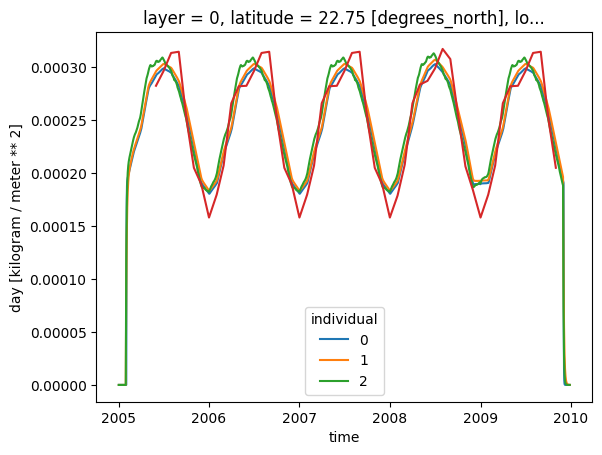

In [26]:
best_simulations.squeeze().plot.line(x="time")
observations[0].observation.squeeze().plot.line(label="Day observation")